Here I want to do generations, patching theads the while time 

Specifically, i want to generate with a

In [1]:
from tl_tools import *
from residual_stream_collection_tools import format_prompt

/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

In [4]:
model = load_llama8br1()

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [5]:
model.to_tokens("hi whats up")

tensor([[128000,   6151,  41209,    709]], device='cuda:0')

In [6]:
model.blocks[2].attn.hook_k

HookPoint()

In [30]:
from typing import List, Tuple, Union, Dict

def generate_with_patching(
    prompt_base: str,
    prompt_patch: str,
    target_head: list[tuple[int, int]] | tuple[int, int],
    max_new_tokens: int,
    base_mode: str = "reasoning",
    do_sample: bool = False,
    scale=1.0,
    average_body_patches: bool = False,
    model: HookedTransformer = model,
    debug: bool = False,
) -> str:
    """
    Generate text in two stages:
      1) "Base" generation on prompt_base, collecting activations of target_head(s).
    
    eg: 

    prompt_base = "what is the capital of the moon?"

    prompt_patch = "what is the capital of the moon?"

      2) "Patch" generation on prompt_patch, injecting those collected activations.

    Args:
        prompt_base: the base prompt. We generate on this until either </think> (if base_mode="reasoning")
                     or until EOS (if base_mode="answering"), capturing the specified head activations.
        prompt_patch: the new prompt. We re-generate from scratch on this, but at each layer/head in
                     target_head we override (or add to) the model's computed head-output with the stored
                     activations from stage 1.
        target_head: either a single (layer_idx, head_idx) tuple or a list of such tuples. All of these
                     heads will be patched in parallel.
        max_new_tokens: upper bound on how many tokens stage 1 (and stage 2) are allowed to generate.
        base_mode: "reasoning" or "answering". If "reasoning", stage 1 stops generation at the </think> token.
                   If "answering", stage 1 stops at the model's default EOS token.
        do_sample: pass through to both calls to model.generate (i.e. sampling vs. greedy).
        scale: the scale factor for the output head patch
        debug: if True, print detailed debugging information throughout execution

    Returns:
        The decoded string from the "patched" generation (stage 2).
    """

    if debug:
        print("=" * 80)
        print("STARTING generate_with_patching")
        print(f"prompt_base: '{prompt_base}'")
        print(f"prompt_patch: '{prompt_patch}'")
        print(f"target_head: {target_head}")
        print(f"max_new_tokens: {max_new_tokens}")
        print(f"base_mode: {base_mode}")
        print(f"do_sample: {do_sample}")
        print(f"scale: {scale}")
        print(f"average_body_patches: {average_body_patches}")
        print("=" * 80)

    #### Assumptions ####
    # 1. A global `model: HookedTransformer` is already defined and .eval()'d.
    # 2. A global `stop_think_id: int` is already defined (the token ID for "</think>").
    #    If base_mode=="reasoning", we use stop_think_id as eos_token_id in stage 1.
    #    Otherwise we use model.tokenizer.eos_token_id.
    #
    # If these globals aren't present, you must define them before calling:
    #   model = HookedTransformer.from_pretrained("gpt2")
    #   model.eval()
    #   stop_think_id = model.tokenizer.encode("</think>")[-1]

    # ------------- 1. Normalize target_head into a list -------------
    if isinstance(target_head, tuple):
        heads: List[tuple[int, int]] = [target_head]
    else:
        heads = target_head
    
    if debug:
        print(f"\n[DEBUG] Normalized heads: {heads}")
    
    model.eval()

    # Build a mapping from layer_idx -> list of head_idx for convenience
    layer_to_heads: Dict[int, List[int]] = {}
    for (layer_idx, head_idx) in heads:
        layer_to_heads.setdefault(layer_idx, []).append(head_idx)

    if debug:
        print(f"[DEBUG] Layer to heads mapping: {layer_to_heads}")

    # ------------- 2. Stage 1: Collect activations -------------------
    if debug:
        print(f"\n{'='*50}")
        print("STAGE 1: COLLECTING ACTIVATIONS")
        print(f"{'='*50}")
    
    # We will store, for each (layer, head), a Python list of torch.Tensor:
    #   collected[(layer, head)][0] is the activation for the ENTIRE prompt_base encoding (shape (1, prompt_len, head_dim)),
    #   collected[(layer, head)][i] for i>=1 is the activation for the i-th newly generated token (shape (1, 1, head_dim)).
    collected: Dict[tuple[int, int], List[torch.Tensor]] = {
        (layer, head): [] for (layer, head) in heads
    }
    save_hooks: List[Tuple[str, callable]] = []

    if debug:
        print(f"[DEBUG] Initialized collection dict for {len(heads)} heads")

    for layer_idx, head_list in layer_to_heads.items():
        hook_name = f"blocks.{layer_idx}.attn.hook_z"
        
        if debug:
            print(f"[DEBUG] Adding save hook for layer {layer_idx}, heads {head_list}")
            print(f"[DEBUG] Hook name: {hook_name}")

        def make_save_hook(layer_idx: int, head_list: List[int]):
            def save_hook(
                activation: torch.Tensor,  # shape (1, seq_len, n_heads, head_dim) or (1, seq_len, d_model)
                hook=None                  # catch the extra keyword that TransformerLens passes
            ) -> torch.Tensor:
                if debug:
                    print(f"[DEBUG] Save hook fired for layer {layer_idx}, activation shape: {activation.shape}")
                
                # Depending on whether we're on hook_attn_heads vs hook_z, activation
                # could be 4‐D or 3‐D. For simplicity, assume hook_attn_heads here:
                for head_idx in head_list:
                    # slice out activation[:, :, head_idx, :]
                    slice_out = activation[:, :, head_idx, :].detach().cpu().clone()
                    collected[(layer_idx, head_idx)].append(slice_out)
                    if debug:
                        print(f"[DEBUG] Collected activation for head ({layer_idx}, {head_idx}), shape: {slice_out.shape}")
                        print(f"[DEBUG] Total collected for this head: {len(collected[(layer_idx, head_idx)])}")
                
                return activation
            return save_hook

        fn = make_save_hook(layer_idx, head_list)
        model.add_hook(hook_name, fn)
        save_hooks.append((hook_name, fn))

    if debug:
        print(f"[DEBUG] Added {len(save_hooks)} save hooks total")

    # Decide which eos to use in stage 1
    if base_mode == "reasoning":
        eos_id_stage1 = model.tokenizer.encode("</think>")[-1]
        if debug:
            print(f"[DEBUG] Using reasoning mode, eos_id_stage1 = {eos_id_stage1} (</think>)")
    else:
        eos_id_stage1 = model.tokenizer.eos_token_id
        if debug:
            print(f"[DEBUG] Using answering mode, eos_id_stage1 = {eos_id_stage1} (default EOS)")

    if debug:
        print(f"[DEBUG] Starting stage 1 generation with prompt_base...")
        print(f"[DEBUG] Generation params: max_new_tokens={max_new_tokens}, do_sample={do_sample}, eos_token_id={eos_id_stage1}")

    # Run stage 1 generation
    base_generation = model.generate(
        prompt_base,
        max_new_tokens = max_new_tokens,
        do_sample       = do_sample,
        eos_token_id    = eos_id_stage1,
    )

    if debug:
        print(f"[DEBUG] Stage 1 generation complete")
        print(f"[DEBUG] Base generation result: '{base_generation}'")

    print(base_generation)

    # Remove all stage-1 save hooks
    if debug:
        print(f"[DEBUG] Removing {len(save_hooks)} save hooks...")
    
    model.reset_hooks()
    
    if debug:
        print(f"[DEBUG] All save hooks removed")

    # ------------- 3. Process collected activations ---------------------
    if debug:
        print(f"\n{'='*50}")
        print("PROCESSING COLLECTED ACTIVATIONS")
        print(f"{'='*50}")

    # Compute prompt_base length (number of tokens in the original prompt)
    prompt_base_toks  = model.to_tokens(prompt_base)  # shape (1, prompt_base_len)
    prompt_base_len   = prompt_base_toks.shape[1]

    if debug:
        print(f"[DEBUG] prompt_base_toks shape: {prompt_base_toks.shape}")
        print(f"[DEBUG] prompt_base_len: {prompt_base_len}")

    # For each (layer, head), we expect:
    #   collected[(layer, head)][0].shape == (1,  prompt_base_len, head_dim)
    #   collected[(layer, head)][i].shape == (1, 1, head_dim) for i>=1, up to i = num_generated_stage1.
    #
    # Build two structures:
    #   stored_first[(layer, head)]  -> the first element ( Tensor shape (1, prompt_base_len, head_dim) )
    #   decoded_acts[(layer, head)]  -> Python list of Tensors shape (head_dim,) for each generated token
    stored_first: Dict[tuple[int, int], torch.Tensor] = {}
    decoded_acts: Dict[tuple[int, int], List[torch.Tensor]] = {}

    for (layer_idx, head_idx) in heads:
        lst = collected[(layer_idx, head_idx)]
        if debug:
            print(f"[DEBUG] Processing head ({layer_idx}, {head_idx}): {len(lst)} collected activations")
        
        if len(lst) == 0:
            raise RuntimeError(f"No activations collected for head {(layer_idx, head_idx)}!")
        
        # First element: full-prompt encoding
        stored_first[(layer_idx, head_idx)] = lst[0]  # shape (1, prompt_base_len, head_dim)
        if debug:
            print(f"[DEBUG] stored_first[({layer_idx}, {head_idx})] shape: {lst[0].shape}")
        
        # Subsequent elements: each is shape (1,1,head_dim); squeeze to (head_dim,)
        subsequent = [lst[i].squeeze(0).squeeze(0) for i in range(1, len(lst))]
        decoded_acts[(layer_idx, head_idx)] = subsequent
        if debug:
            print(f"[DEBUG] decoded_acts[({layer_idx}, {head_idx})]: {len(subsequent)} vectors")
            if len(subsequent) > 0:
                print(f"[DEBUG] First decoded vector shape: {subsequent[0].shape}")

    copied_decoded_acts = decoded_acts.copy()
    
    if average_body_patches:
        if debug:
            print(f"[DEBUG] Averaging body patches...")
        # average the patches for each head
        for (layer_idx, head_idx) in heads:
            if len(decoded_acts[(layer_idx, head_idx)]) > 0:
                mean_patch = torch.mean(torch.stack(decoded_acts[(layer_idx, head_idx)]), dim=0)
                original_count = len(decoded_acts[(layer_idx, head_idx)])
                decoded_acts[(layer_idx, head_idx)] = [mean_patch for _ in decoded_acts[(layer_idx, head_idx)]]
                if debug:
                    print(f"[DEBUG] Averaged {original_count} patches for head ({layer_idx}, {head_idx})")
                    print(f"[DEBUG] Mean patch shape: {mean_patch.shape}")

    # Determine how many decoded tokens we actually got in stage 1
    # (Take the minimum across all heads; they should all match)
    num_decoded_per_head = min(len(decoded_acts[(layer_idx, head_idx)]) for (layer_idx, head_idx) in heads)
    
    if debug:
        print(f"[DEBUG] num_decoded_per_head: {num_decoded_per_head}")
        for (layer_idx, head_idx) in heads:
            print(f"[DEBUG] Head ({layer_idx}, {head_idx}) has {len(decoded_acts[(layer_idx, head_idx)])} decoded activations")

    # ------------- 4. Stage 2: Define patch hook(s) ------------------------
    if debug:
        print(f"\n{'='*50}")
        print("STAGE 2: SETTING UP PATCH HOOKS")
        print(f"{'='*50}")

    # We want an option `single_patch` that, if True, patches ONLY:
    #   (a) the LAST index of the first-layer activation ( i.e. stored_first[..., :, prompt_base_len - 1, :] ), and
    #   (b) all of the length-1 activations in decoded_acts (in order).
    #
    # If single_patch=False, then during prompt_patch encoding (when seq_len_current > 1),
    # we patch EVERY token position t where t < stored_first_length, using stored_first[..., t, :].
    # Then during decoding (seq_len_current == 1), we patch using decoded_acts in order.
    single_patch = True  # "for now" – you can set to False if you want the "patch as far back as possible" behavior.

    if debug:
        print(f"[DEBUG] single_patch mode: {single_patch}")

    # We'll build a hook per layer (grouped), since multiple heads can share the same layer.
    patch_hooks: List[Tuple[str, callable]] = []

    # We will need two bits of state inside each hook: (1) have we "patched encoding" yet? (bool),
    # and (2) a counter "decode_counter" to iterate through decoded_acts. We also need to know how many
    # decoded vectors are available (num_decoded_per_head).
    for layer_idx, head_list in layer_to_heads.items():
        hook_name = f"blocks.{layer_idx}.attn.hook_z"
        
        if debug:
            print(f"[DEBUG] Creating patch hook for layer {layer_idx}, heads {head_list}")
            print(f"[DEBUG] Hook name: {hook_name}")

        def make_patch_hook(
            layer_idx: int, head_list: List[int],
            stored_first: Dict[tuple[int, int], torch.Tensor],
            decoded_acts: Dict[tuple[int, int], List[torch.Tensor]],
            prompt_base_len: int,
            num_decoded_per_head: int,
            single_patch: bool,
        ):
            encoded_done   = False
            decode_counter = 0

            def patch_hook(
                activation: torch.Tensor,  # shape (1, seq_len, n_heads, head_dim)
                hook=None                  # catch the extra keyword
            ) -> torch.Tensor:
                nonlocal encoded_done, decode_counter
                seq_len_current = activation.shape[1]
                patched = activation.clone()

                if debug:
                    print(f"[DEBUG] Patch hook fired for layer {layer_idx}")
                    print(f"[DEBUG] Input activation shape: {activation.shape}")
                    print(f"[DEBUG] seq_len_current: {seq_len_current}")
                    print(f"[DEBUG] encoded_done: {encoded_done}, decode_counter: {decode_counter}")

                if seq_len_current > 1:
                    # "Encoding" step of prompt_patch
                    if debug:
                        print(f"[DEBUG] Encoding step (seq_len > 1)")
                    
                    if single_patch and not encoded_done:
                        last_pos = seq_len_current - 1
                        if debug:
                            print(f"[DEBUG] Single patch mode: patching position {last_pos}")
                        
                        for head_idx in head_list:
                            vec = stored_first[(layer_idx, head_idx)][0, prompt_base_len - 1, :].to(activation.device)
                            patched[0, last_pos, head_idx, :] = vec*scale
                            if debug:
                                print(f"[DEBUG] Patched head ({layer_idx}, {head_idx}) at pos {last_pos} with vector shape {vec.shape}, scale {scale}")
                        
                        encoded_done = True
                        if debug:
                            print(f"[DEBUG] Encoding marked as done")

                    elif not single_patch:
                        if debug:
                            print(f"[DEBUG] Multi-patch mode: patching all positions")
                        
                        first_tensor = stored_first[(layer_idx, head_list[0])]
                        max_t = min(seq_len_current, first_tensor.shape[1])
                        if debug:
                            print(f"[DEBUG] Patching {max_t} positions")
                        
                        for t in range(max_t):
                            for head_idx in head_list:
                                vec = stored_first[(layer_idx, head_idx)][0, -1 - t, :].to(activation.device)
                                patched[0, t, head_idx, :] = vec*scale
                                if debug and t < 3:  # Only log first few to avoid spam
                                    print(f"[DEBUG] Patched head ({layer_idx}, {head_idx}) at pos {t} with scale {scale}")

                else:
                    # "Decoding" step (one new token)
                    if debug:
                        print(f"[DEBUG] Decoding step (seq_len == 1)")
                    
                    if decode_counter < num_decoded_per_head:
                        if debug:
                            print(f"[DEBUG] Using decode_counter {decode_counter} (within bounds)")
                        
                        for head_idx in head_list:
                            vec = decoded_acts[(layer_idx, head_idx)][decode_counter].to(activation.device)
                            patched[0, 0, head_idx, :] = vec*scale
                            if debug:
                                print(f"[DEBUG] Patched head ({layer_idx}, {head_idx}) with decode vector {decode_counter}, shape {vec.shape}, scale {scale}")
                    else:
                        if debug:
                            print(f"[DEBUG] decode_counter {decode_counter} >= {num_decoded_per_head}, using last vector")
                        
                        for head_idx in head_list:
                            vec = decoded_acts[(layer_idx, head_idx)][-1].to(activation.device)
                            patched[0, 0, head_idx, :] = vec*scale
                            if debug:
                                print(f"[DEBUG] Patched head ({layer_idx}, {head_idx}) with last decode vector, shape {vec.shape}, scale {scale}")
                    
                    decode_counter += 1
                    if debug:
                        print(f"[DEBUG] Incremented decode_counter to {decode_counter}")

                return patched

            return patch_hook

        fn = make_patch_hook(
            layer_idx      = layer_idx,
            head_list      = head_list,
            stored_first   = stored_first,
            decoded_acts   = decoded_acts,
            prompt_base_len   = prompt_base_len,
            num_decoded_per_head = num_decoded_per_head,
            single_patch   = single_patch,
        )
        model.add_hook(hook_name, fn)
        patch_hooks.append((hook_name, fn))

    if debug:
        print(f"[DEBUG] Added {len(patch_hooks)} patch hooks total")

    # ------------- 5. Stage 2: Run patched generation ------------------------
    if debug:
        print(f"\n{'='*50}")
        print("STAGE 2: RUNNING PATCHED GENERATION")
        print(f"{'='*50}")

    # Limit how many new tokens we actually patch for:
    max_new_tokens_stage2 = min(max_new_tokens, num_decoded_per_head)
    
    if debug:
        print(f"[DEBUG] max_new_tokens_stage2: {max_new_tokens_stage2}")
        print(f"[DEBUG] prompt_patch: '{prompt_patch}'")
        print(f"[DEBUG] Generation params: max_new_tokens={max_new_tokens}, do_sample={do_sample}, temperature=0.6")
    
    tokens_patch = model.generate(
        prompt_patch,
        max_new_tokens = max_new_tokens,
        do_sample       = do_sample,
        temperature     = 0.6,
        eos_token_id = None
        # We do NOT override eos_token_id for stage 2; we let default EOS apply.
    )

    if debug:
        print(f"[DEBUG] Stage 2 generation complete")
        print(f"[DEBUG] Patched generation result: '{tokens_patch}'")

    # Remove all stage-2 patch hooks
    if debug:
        print(f"[DEBUG] Removing {len(patch_hooks)} patch hooks...")
    
    model.reset_hooks()
    
    if debug:
        print(f"[DEBUG] All patch hooks removed")
        print(f"\n{'='*80}")
        print("generate_with_patching COMPLETE")
        print(f"{'='*80}")

    # ------------- 6. Return decoded output of patched generation ------------
    return tokens_patch, copied_decoded_acts

In [31]:
base = "if prime is a list of prime numbers, what is prime[prime[3]]?"

base = "What is the seventh prime number?"

In [32]:
reasoning_prompt = format_prompt(model, raw_prompt=base, mode='base', remove_bos= True)
print(reasoning_prompt)
answer_prompt = format_prompt(model, raw_prompt=base, mode='immediate_answer', remove_bos= True)
print(answer_prompt)

<｜User｜>What is the seventh prime number?<｜Assistant｜><think>

<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>




In [41]:
patched_output, copied_decoded_acts = generate_with_patching(
    prompt_base=answer_prompt,
    prompt_patch=reasoning_prompt,
    target_head=[(2, 17), (0, 0)],
    max_new_tokens=500,
    base_mode="answering",
    do_sample=False,
    scale=1.4,
    average_body_patches=True,
    debug=False
)
print("====================")
print(patched_output)

  0%|          | 0/500 [00:00<?, ?it/s]

  2%|▏         | 9/500 [00:00<00:41, 11.86it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.23it/s]

<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


In [18]:
answer_prompt

'<｜User｜>What is the seventh prime number?<｜Assistant｜><think>\n</think>\n\n'

In [44]:
patched_output_v2, copied_decoded_acts_v2 = generate_with_patching(
    prompt_base=reasoning_prompt,
    prompt_patch=answer_prompt,
    target_head=[(2, 17), (0, 0)],
    max_new_tokens=500,
    base_mode="reasoning",
    do_sample=False,
    scale=1.4,
    average_body_patches=True,
    debug=False
)
print("====================")
print(patched_output_v2)

  0%|          | 0/500 [00:00<?, ?it/s]

 19%|█▉        | 97/500 [00:07<00:29, 13.51it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that 2 is the smallest and only even prime number.

Next, 3 is the second prime number.

Then, 5 comes after 3 as the third prime.

Following that, 7 is the fourth prime number.

The fifth prime number is 11.

After that, 13 is the sixth prime number.

Finally, 17 is the seventh prime number.
</think>


 37%|███▋      | 185/500 [00:13<00:23, 13.65it/s]

<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that a prime number is a number greater than 1 that has no positive divisors other than 1 and itself.

Starting from the smallest prime number, which is 2, I'll continue listing each subsequent prime number.

After identifying the first seven prime numbers, I can determine the seventh prime number.

**Step-by-Step Explanation:**

1. **List the prime numbers in order:**
   - 2 (prime)
   - 3 (prime)
   - 5 (prime)
   - 7 (prime)
   - 11 (prime)
   - 13 (prime)
   - 17 (prime)

2. **Identify the seventh prime number:**
   - The seventh number in this list is 17.

**Answer:** The seventh prime number is 17.


# experiment, look at what combination of heads results in the lowest scale needed to output 

In [52]:
patched_output, copied_decoded_acts = generate_with_patching(
    prompt_base=answer_prompt,
    prompt_patch=reasoning_prompt,
    target_head=[(2, 17),(0,0)], #(0, 19)],
    max_new_tokens=500,
    base_mode="answering",
    do_sample=False,
    scale=1.2,
    average_body_patches=True,
)
print("====================")
print(patched_output)

  2%|▏         | 9/500 [00:00<00:39, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 44%|████▍     | 220/500 [00:16<00:20, 13.61it/s]

<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

1. **2** is the first prime number.
2. **3** is the second prime number.
3. **5** is the third prime number.
4. **7** is the fourth prime number.
5. **11** is the fifth prime number.
6. **13** is the sixth prime number.
7. **17** is the seventh prime number.

Therefore, the seventh prime number is **17**.
</think>

To find the **seventh prime number**, let's list the prime numbers in order until we reach the seventh one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

**Final Answer:** \(\boxed{17}\)


In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

def analyze_reasoning_vs_answering(
    model,
    completion_text: str,
    reasoning_prompt: str = "Think step by step about this problem:",
    answering_prompt: str = "Answer this question directly:",
    debug: bool = False
) -> Dict:
    """
    Analyze how 'reasoning-like' vs 'answering-like' each token in a completion is.
    
    Args:
        model: HookedTransformer model
        completion_text: The text to analyze
        reasoning_prompt: Prompt that encourages reasoning behavior
        answering_prompt: Prompt that encourages direct answering
        debug: Print debugging information
    
    Returns:
        Dictionary with analysis results and visualization data
    """
    
    model.eval()
    
    # Tokenize the completion
    completion_tokens = model.to_tokens(completion_text)[0]  # Remove batch dim
    completion_str_tokens = [model.tokenizer.decode([tok]) for tok in completion_tokens]
    
    if debug:
        print(f"Analyzing {len(completion_tokens)} tokens")
        print(f"Completion: '{completion_text}'")
    
    # For each position, we'll compute log probabilities under both contexts
    reasoning_logprobs = []
    answering_logprobs = []
    reasoning_context = reasoning_prompt + completion_text
    answering_context = answering_prompt + completion_text
    
    # Get full context tokens
    reasoning_tokens = model.to_tokens(reasoning_context)[0]
    answering_tokens = model.to_tokens(answering_context)[0]
    
    reasoning_prompt_len = len(model.to_tokens(reasoning_prompt)[0])
    answering_prompt_len = len(model.to_tokens(answering_prompt)[0])
    
    if debug:
        print(f"Reasoning prompt length: {reasoning_prompt_len} tokens")
        print(f"Answering prompt length: {answering_prompt_len} tokens")
    
    # Get logits for both contexts
    with torch.no_grad():
        reasoning_logits = model(reasoning_tokens.unsqueeze(0))  # Add batch dim
        answering_logits = model(answering_tokens.unsqueeze(0))
    
    # Extract logprobs for each completion token
    for i, token_id in enumerate(completion_tokens):
        # Position in the full context (after prompt)
        reasoning_pos = reasoning_prompt_len + i - 1  # -1 because we predict next token
        answering_pos = answering_prompt_len + i - 1
        
        if reasoning_pos >= 0 and reasoning_pos < reasoning_logits.shape[1]:
            reasoning_logprob = torch.log_softmax(reasoning_logits[0, reasoning_pos], dim=-1)[token_id].item()
        else:
            reasoning_logprob = float('-inf')
            
        if answering_pos >= 0 and answering_pos < answering_logits.shape[1]:
            answering_logprob = torch.log_softmax(answering_logits[0, answering_pos], dim=-1)[token_id].item()
        else:
            answering_logprob = float('-inf')
        
        reasoning_logprobs.append(reasoning_logprob)
        answering_logprobs.append(answering_logprob)
        
        if debug and i < 5:  # Print first few
            token_str = model.tokenizer.decode([token_id])
            print(f"Token {i}: '{token_str}' | Reasoning: {reasoning_logprob:.3f} | Answering: {answering_logprob:.3f}")
    
    # Convert to numpy arrays
    reasoning_logprobs = np.array(reasoning_logprobs)
    answering_logprobs = np.array(answering_logprobs)
    
    # Compute ratios and metrics
    # Ratio > 1 means more "reasoning-like", < 1 means more "answering-like"
    logprob_diff = reasoning_logprobs - answering_logprobs  # log(P_reasoning/P_answering)
    prob_ratio = np.exp(logprob_diff)  # P_reasoning/P_answering
    
    # Normalized score: -1 (very answering-like) to +1 (very reasoning-like)
    reasoning_score = np.tanh(logprob_diff)
    
    return {
        'tokens': completion_str_tokens,
        'token_ids': completion_tokens.tolist(),
        'reasoning_logprobs': reasoning_logprobs,
        'answering_logprobs': answering_logprobs,
        'logprob_diff': logprob_diff,
        'prob_ratio': prob_ratio,
        'reasoning_score': reasoning_score,
        'completion_text': completion_text,
        'reasoning_prompt': reasoning_prompt,
        'answering_prompt': answering_prompt
    }

def visualize_reasoning_analysis(analysis_result: Dict, 
                               title: str = "Reasoning vs Answering Analysis",
                               show_plotly: bool = False,  # Default to False to avoid dependency issues
                               show_matplotlib: bool = True) -> None:
    """
    Create visualizations of the reasoning vs answering analysis.
    """
    
    tokens = analysis_result['tokens']
    reasoning_score = analysis_result['reasoning_score']
    prob_ratio = analysis_result['prob_ratio']
    logprob_diff = analysis_result['logprob_diff']
    
    if show_plotly:
        try:
            # Interactive Plotly visualization
            fig = make_subplots(
                rows=3, cols=1,
                subplot_titles=['Token-by-Token Reasoning Score', 'Probability Ratio', 'Text with Background Colors'],
                specs=[[{"secondary_y": False}],
                       [{"secondary_y": False}],
                       [{"secondary_y": False}]],
                vertical_spacing=0.1
            )
            
            # Score plot
            colors = ['red' if score < -0.2 else 'blue' if score > 0.2 else 'gray' for score in reasoning_score]
            fig.add_trace(
                go.Scatter(
                    x=list(range(len(tokens))),
                    y=reasoning_score,
                    mode='markers+lines',
                    marker=dict(color=colors, size=8),
                    text=[f"'{token}'" for token in tokens],
                    hovertemplate='Token: %{text}<br>Reasoning Score: %{y:.3f}<extra></extra>',
                    name='Reasoning Score'
                ),
                row=1, col=1
            )
            
            # Add horizontal lines for reference
            fig.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.5, row=1, col=1)
            fig.add_hline(y=0.5, line_dash="dot", line_color="blue", opacity=0.3, row=1, col=1)
            fig.add_hline(y=-0.5, line_dash="dot", line_color="red", opacity=0.3, row=1, col=1)
            
            # Probability ratio plot (log scale)
            fig.add_trace(
                go.Scatter(
                    x=list(range(len(tokens))),
                    y=np.log10(np.maximum(prob_ratio, 1e-10)),  # Avoid log(0)
                    mode='markers+lines',
                    marker=dict(color=colors, size=8),
                    text=[f"'{token}'" for token in tokens],
                    hovertemplate='Token: %{text}<br>Log10(Ratio): %{y:.3f}<extra></extra>',
                    name='Log10(Prob Ratio)'
                ),
                row=2, col=1
            )
            
            fig.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.5, row=2, col=1)
            
            # Text visualization with colored backgrounds
            # Create a heatmap-style visualization
            reasoning_score_normalized = (reasoning_score + 1) / 2  # Scale to 0-1
            
            fig.add_trace(
                go.Heatmap(
                    z=[reasoning_score_normalized],
                    x=list(range(len(tokens))),
                    y=[0],
                    colorscale=[[0, 'red'], [0.5, 'white'], [1, 'blue']],
                    showscale=True,
                    colorbar=dict(title="Reasoning Score", y=0.15, len=0.3),
                    hovertemplate='Token %{x}: %{text}<br>Score: %{customdata:.3f}<extra></extra>',
                    text=[tokens],
                    customdata=reasoning_score
                ),
                row=3, col=1
            )
            
            fig.update_layout(
                title=title,
                height=800,
                showlegend=False
            )
            
            fig.update_xaxes(title_text="Token Position", row=3, col=1)
            fig.update_yaxes(title_text="Reasoning Score (-1=Answering, +1=Reasoning)", row=1, col=1)
            fig.update_yaxes(title_text="Log10(P_reasoning/P_answering)", row=2, col=1)
            fig.update_yaxes(title_text="", showticklabels=False, row=3, col=1)
            
            # Try to show, but handle potential errors
            try:
                fig.show()
            except Exception as e:
                print(f"Could not display Plotly figure: {e}")
                print("Consider installing: pip install nbformat>=4.2.0")
                print("Falling back to matplotlib visualization...")
                show_matplotlib = True
        except Exception as e:
            print(f"Plotly visualization failed: {e}")
            print("Falling back to matplotlib visualization...")
            show_matplotlib = True
    
    if show_matplotlib:
        # Static matplotlib visualization
        fig, axes = plt.subplots(3, 1, figsize=(15, 12))
        
        # Token score plot
        colors = ['red' if score < -0.2 else 'blue' if score > 0.2 else 'gray' for score in reasoning_score]
        axes[0].scatter(range(len(tokens)), reasoning_score, c=colors, alpha=0.7, s=50)
        axes[0].plot(range(len(tokens)), reasoning_score, alpha=0.5, color='black')
        axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[0].axhline(y=0.5, color='blue', linestyle=':', alpha=0.3)
        axes[0].axhline(y=-0.5, color='red', linestyle=':', alpha=0.3)
        axes[0].set_ylabel('Reasoning Score')
        axes[0].set_title('Token-by-Token Reasoning vs Answering Score')
        axes[0].grid(True, alpha=0.3)
        
        # Probability ratio plot
        axes[1].scatter(range(len(tokens)), np.log10(np.maximum(prob_ratio, 1e-10)), c=colors, alpha=0.7, s=50)
        axes[1].plot(range(len(tokens)), np.log10(np.maximum(prob_ratio, 1e-10)), alpha=0.5, color='black')
        axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1].set_ylabel('Log10(P_reasoning/P_answering)')
        axes[1].set_title('Probability Ratio (Log Scale)')
        axes[1].grid(True, alpha=0.3)
        
        # Text with background colors
        text_viz = axes[2]
        text_viz.set_xlim(-0.5, len(tokens) - 0.5)
        text_viz.set_ylim(-0.5, 0.5)
        
        # Create background colors for each token
        for i, (token, score) in enumerate(zip(tokens, reasoning_score)):
            # Normalize score to color intensity
            if score > 0:
                color = plt.cm.Blues(min(abs(score), 1.0))
            else:
                color = plt.cm.Reds(min(abs(score), 1.0))
            
            # Add colored background rectangle
            rect = plt.Rectangle((i-0.4, -0.4), 0.8, 0.8, facecolor=color, alpha=0.7)
            text_viz.add_patch(rect)
            
            # Add token text
            text_viz.text(i, 0, token, ha='center', va='center', fontsize=8, 
                         fontweight='bold', color='white' if abs(score) > 0.5 else 'black')
        
        text_viz.set_xlabel('Token Position')
        text_viz.set_title('Text Visualization (Blue=Reasoning-like, Red=Answering-like)')
        text_viz.set_yticks([])
        text_viz.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Always show a simple text-based visualization
    print_text_visualization(analysis_result)

def print_text_visualization(analysis_result: Dict) -> None:
    """
    Print a simple text-based visualization that works in any environment.
    """
    tokens = analysis_result['tokens']
    reasoning_score = analysis_result['reasoning_score']
    
    print(f"\n{'='*80}")
    print("TEXT-BASED VISUALIZATION")
    print(f"{'='*80}")
    print("Legend: [R] = Reasoning-like, [A] = Answering-like, [ ] = Neutral")
    print(f"{'='*80}")
    
    # Print tokens with indicators
    line_length = 0
    for i, (token, score) in enumerate(zip(tokens, reasoning_score)):
        # Determine indicator
        if score > 0.2:
            indicator = "R"
            color_code = "\033[94m"  # Blue
        elif score < -0.2:
            indicator = "A"
            color_code = "\033[91m"  # Red
        else:
            indicator = " "
            color_code = "\033[0m"   # Reset
        
        # Format token with indicator and score
        token_display = f"{color_code}[{indicator}]{token}\033[0m"
        score_display = f"({score:.2f})"
        
        # Print with line wrapping
        token_length = len(token) + len(score_display) + 4  # 4 for brackets and spaces
        if line_length + token_length > 80:
            print()  # New line
            line_length = 0
        
        print(token_display + score_display, end=" ")
        line_length += token_length + 1
    
    print("\n")
    
    # Print summary statistics
    reasoning_tokens = sum(1 for s in reasoning_score if s > 0.2)
    answering_tokens = sum(1 for s in reasoning_score if s < -0.2)
    neutral_tokens = len(reasoning_score) - reasoning_tokens - answering_tokens
    avg_score = np.mean(reasoning_score)
    
    print(f"Summary Statistics:")
    print(f"  Total tokens: {len(tokens)}")
    print(f"  Reasoning-like tokens [R]: {reasoning_tokens} ({reasoning_tokens/len(tokens)*100:.1f}%)")
    print(f"  Answering-like tokens [A]: {answering_tokens} ({answering_tokens/len(tokens)*100:.1f}%)")
    print(f"  Neutral tokens [ ]: {neutral_tokens} ({neutral_tokens/len(tokens)*100:.1f}%)")
    print(f"  Average reasoning score: {avg_score:.3f}")
    
    # Show most reasoning-like and answering-like tokens
    token_scores = list(zip(tokens, reasoning_score))
    token_scores.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nMost reasoning-like tokens:")
    for token, score in token_scores[:5]:
        if score > 0:
            print(f"  '{token}': {score:.3f}")
    
    print(f"\nMost answering-like tokens:")
    for token, score in reversed(token_scores[-5:]):
        if score < 0:
            print(f"  '{token}': {score:.3f}")
    
    print(f"{'='*80}")

def create_html_visualization(analysis_result: Dict, output_file: str = "reasoning_analysis.html") -> str:
    """
    Create an HTML file with colored text visualization.
    """
    tokens = analysis_result['tokens']
    reasoning_score = analysis_result['reasoning_score']
    
    html_content = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Reasoning vs Answering Analysis</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            .token {{ display: inline-block; padding: 2px 4px; margin: 1px; border-radius: 3px; }}
            .legend {{ margin: 20px 0; }}
            .legend-item {{ display: inline-block; margin-right: 20px; }}
            .stats {{ background: #f5f5f5; padding: 10px; margin: 20px 0; border-radius: 5px; }}
        </style>
    </head>
    <body>
        <h1>Reasoning vs Answering Analysis</h1>
        
        <div class="legend">
            <div class="legend-item"><span style="background: #ff6b6b; color: white; padding: 2px 8px;">■</span> Answering-like</div>
            <div class="legend-item"><span style="background: #ffffff; color: black; padding: 2px 8px; border: 1px solid #ccc;">■</span> Neutral</div>
            <div class="legend-item"><span style="background: #4dabf7; color: white; padding: 2px 8px;">■</span> Reasoning-like</div>
        </div>
        
        <div class="text-content">
    """
    
    for token, score in zip(tokens, reasoning_score):
        # Determine background color based on score
        if score > 0.2:
            intensity = min(abs(score), 1.0)
            bg_color = f"rgba(77, 171, 247, {intensity})"  # Blue for reasoning
            text_color = "white" if intensity > 0.5 else "black"
        elif score < -0.2:
            intensity = min(abs(score), 1.0)
            bg_color = f"rgba(255, 107, 107, {intensity})"  # Red for answering
            text_color = "white" if intensity > 0.5 else "black"
        else:
            bg_color = "#f8f9fa"  # Light gray for neutral
            text_color = "black"
        
        html_content += f'<span class="token" style="background-color: {bg_color}; color: {text_color};" title="Score: {score:.3f}">{token}</span>'
    
    html_content += f"""
        </div>
        
        <div class="stats">
            <h3>Statistics</h3>
            <p><strong>Total tokens:</strong> {len(tokens)}</p>
            <p><strong>Reasoning-like tokens (score > 0.2):</strong> {sum(1 for s in reasoning_score if s > 0.2)}</p>
            <p><strong>Answering-like tokens (score < -0.2):</strong> {sum(1 for s in reasoning_score if s < -0.2)}</p>
            <p><strong>Neutral tokens:</strong> {sum(1 for s in reasoning_score if -0.2 <= s <= 0.2)}</p>
            <p><strong>Average reasoning score:</strong> {np.mean(reasoning_score):.3f}</p>
        </div>
        
        <div class="prompts">
            <h3>Prompts Used</h3>
            <p><strong>Reasoning prompt:</strong> "{analysis_result['reasoning_prompt']}"</p>
            <p><strong>Answering prompt:</strong> "{analysis_result['answering_prompt']}"</p>
        </div>
    </body>
    </html>
    """
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    return output_file

# Example usage function
def analyze_text_example(model, text: str, debug: bool = False):
    """
    Example function showing how to use the analysis tools.
    """
    # Analyze the text
    analysis = analyze_reasoning_vs_answering(
        model=model,
        completion_text=text,
        reasoning_prompt="Let me think through this step by step: ",
        answering_prompt="The answer is: ",
        debug=debug
    )
    
    # Create visualizations (matplotlib + text-based)
    visualize_reasoning_analysis(analysis, show_plotly=False, show_matplotlib=True)
    
    # Create HTML file
    html_file = create_html_visualization(analysis)
    print(f"HTML visualization saved to: {html_file}")
    
    return analysis

def analyze_text_simple(model, text=patched_output, reasoning_prompt=reasoning_prompt, answering_prompt=answer_prompt):
    """
    Simplified analysis function that only shows text-based visualization.
    """
    if reasoning_prompt is None:
        reasoning_prompt = "Let me think through this step by step: "
    if answering_prompt is None:
        answering_prompt = "The answer is: "
    
    # Analyze the text
    analysis = analyze_reasoning_vs_answering(
        model=model,
        completion_text=text,
        reasoning_prompt=reasoning_prompt,
        answering_prompt=answering_prompt,
        debug=False
    )
    
    # Show only text-based visualization
    print_text_visualization(analysis)
    
    return analysis


In [52]:
analyze_text_simple(model)


TEXT-BASED VISUALIZATION
Legend: [R] = Reasoning-like, [A] = Answering-like, [ ] = Neutral
[A]<｜begin▁of▁sentence｜>(-0.89) [A]<｜User｜>(-0.25) [R]What(0.24) 
[A] is(-0.82) [A] the(-0.91) [ ] seventh(-0.12) [R] prime(0.69) 
[R] number(0.92) [A]?(-0.99) [A]<｜Assistant｜>(-1.00) [A]<think>(-0.43) 
[A]
(-0.81) [R]The(0.41) [R] seventh(0.96) [R] prime(0.98) [R] number(0.98) 
[R] is(0.86) [A] **(-0.99) [R]17(1.00) [R]**(0.98) [ ].(-0.07) 

Summary Statistics:
  Total tokens: 21
  Reasoning-like tokens [R]: 10 (47.6%)
  Answering-like tokens [A]: 9 (42.9%)
  Neutral tokens [ ]: 2 (9.5%)
  Average reasoning score: 0.035

Most reasoning-like tokens:
  '17': 1.000
  ' prime': 0.978
  '**': 0.977
  ' number': 0.976
  ' seventh': 0.961

Most answering-like tokens:
  '<｜Assistant｜>': -0.996
  '?': -0.988
  ' **': -0.985
  ' the': -0.908
  '<｜begin▁of▁sentence｜>': -0.886


{'tokens': ['<｜begin▁of▁sentence｜>',
  '<｜User｜>',
  'What',
  ' is',
  ' the',
  ' seventh',
  ' prime',
  ' number',
  '?',
  '<｜Assistant｜>',
  '<think>',
  '\n',
  'The',
  ' seventh',
  ' prime',
  ' number',
  ' is',
  ' **',
  '17',
  '**',
  '.'],
 'token_ids': [128000,
  128011,
  3923,
  374,
  279,
  31487,
  10461,
  1396,
  30,
  128012,
  128013,
  198,
  791,
  31487,
  10461,
  1396,
  374,
  3146,
  1114,
  334,
  13],
 'reasoning_logprobs': array([-23.47869492, -25.88306999, -20.86943817, -16.34861755,
        -16.48701286, -20.71939278, -14.02440643, -15.76174164,
        -17.34756851, -29.53643417, -17.13123322, -22.78734398,
        -19.51588821, -15.98190784, -10.32307816, -12.90686131,
        -12.08818722, -16.94415283, -18.03436089, -20.15538788,
        -17.75209808]),
 'answering_logprobs': array([-22.0769558 , -25.62817764, -21.11614418, -15.19873619,
        -14.97089767, -20.59497833, -14.86909485, -17.33607101,
        -14.7756958 , -26.42368317, -16.6719

In [50]:
analyze_text_example(model, text=patched_output)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

A question we can ask is, what is the minimum scale required before our model gives the 
immediate answer reply 

In [64]:
import numpy as np
from typing import Any, Callable

def give_minimum_needed_scale(
    model: "HookedTransformer",
    answer_prompt: str,
    reasoning_prompt: str,
    other_head: tuple[int, int] | None = None,
    *,
    min_scale: float = 1.0,
    max_scale: float = 3.0,
    num_scales: int = 10,
    start_scale: float | None = None,
    verbose: bool = True,
) -> float:
    """
    Return the smallest scale (drawn from a fixed grid) at which the patched
    model output collapses to the `max_scale` output.

    The search strategy is:
    1. Compute the reference output at `max_scale`.
    2. Establish a sorted list of candidate scales: `np.linspace(min_scale, max_scale, num_scales)`.
    3. Optionally shrink the search interval if `start_scale` is given
       and already yields the reference output.
    4. Binary-search that list until the smallest matching scale is found.

    Args
    ----
    model, answer_prompt, reasoning_prompt, other_head:
        Same meaning as in the original function.
    min_scale, max_scale:
        Inclusive range within which to search.
    num_scales:
        Number of grid points between `min_scale` and `max_scale` (inclusive).
    start_scale:
        Optional first probe; if supplied, we test it before entering the
        binary search and tighten the high bound when appropriate.
    verbose:
        Print diagnostic information if True.

    Returns
    -------
    float
        The minimum scale on the grid that reproduces the `max_scale` output.
    """
    # 1. Reference output at max_scale
    ref_output, _ = generate_with_patching(
        prompt_base=answer_prompt,
        prompt_patch=reasoning_prompt,
        target_head=[(2, 17), other_head] if other_head is not None else [(2, 17)],
        max_new_tokens=500,
        base_mode="answering",
        do_sample=False,
        scale=max_scale,
    )
    if verbose:
        print(f"[max_scale={max_scale:.3g}] → {ref_output!r}")

    # 2. Candidate scales (ascending)
    scales: list[float] = np.linspace(min_scale, max_scale, num_scales).tolist()

    # Utility: does a scale produce the reference output?
    def matches_reference(scale: float) -> bool:
        out, _ = generate_with_patching(
            prompt_base=answer_prompt,
            prompt_patch=reasoning_prompt,
            target_head=[(2, 17), other_head] if other_head is not None else [(2, 17)],
            max_new_tokens=model.to_tokens(ref_output)[0].shape[0],
            base_mode="answering",
            do_sample=False,
            scale=scale,
        )
        return out == ref_output

    # 3. Optional early probe
    low_idx: int = 0
    high_idx: int = len(scales) - 1
    if start_scale is not None:
        # Clamp to grid and test
        start_idx = int(np.searchsorted(scales, start_scale, side="left"))
        start_idx = min(start_idx, high_idx)  # bounds check
        if verbose:
            print(f"[probe start_scale={scales[start_idx]:.3g}]")
        if matches_reference(scales[start_idx]):
            # Reference reached at or before start_idx → shrink high bound
            high_idx = start_idx
        else:
            # Reference NOT reached → shrink low bound
            low_idx = start_idx + 1

    # 4. Binary search over [low_idx, high_idx]
    while low_idx < high_idx:
        mid_idx: int = (low_idx + high_idx) // 2
        scale_mid: float = scales[mid_idx]
        if verbose:
            print(f"[probe {scale_mid:.3g}] (idx {mid_idx})")
        if matches_reference(scale_mid):
            high_idx = mid_idx  # still matches → go lower
        else:
            low_idx = mid_idx + 1  # doesn't match → go higher

    final_scale: float = scales[low_idx]
    if verbose:
        print(f"Minimum matching scale: {final_scale:.3g}")
    return final_scale


In [65]:
# sweep over first 3 layers

base_scale = give_minimum_needed_scale(model, answer_prompt, reasoning_prompt, other_head=None, verbose=False)

scales = np.zeros((3, 32)) # layers x heads
for layer in range(3):
    for head in range(32):
        scales[layer, head] = give_minimum_needed_scale(
            model, answer_prompt, reasoning_prompt, other_head=(layer, head), verbose=False
            )

# now plot the scales
fig, ax = plt.subplots()
ax.imshow(scales-base_scale)
ax.set_title("Minimum scale needed to get immediate answer reply")
ax.set_xlabel("Head")
ax.set_ylabel("Layer")
plt.show()







  0%|          | 0/500 [00:00<?, ?it/s]

  2%|▏         | 9/500 [00:00<00:41, 11.86it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.21it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.25it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.23it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.23it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.20it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.25it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.23it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.22it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.25it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.13it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.23it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.20it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.24it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.24it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.24it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.24it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  7%|▋         | 9/123 [00:00<00:09, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  7%|▋         | 9/123 [00:00<00:09, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  7%|▋         | 9/123 [00:00<00:09, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.25it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.22it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.22it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.40it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.41it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.41it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.41it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.41it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.40it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.40it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.40it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.40it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.41it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.39it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.39it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.39it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.39it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.39it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.39it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.22it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.25it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.25it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.39it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.39it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.39it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.42it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.43it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.39it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.39it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.41it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.45it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.45it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.39it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.20it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.40it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.43it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.41it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.45it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.44it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.45it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.44it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.45it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.45it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.44it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.44it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.44it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.45it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.42it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.29it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.21it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.40it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.12it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.18it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 43%|████▎     | 9/21 [00:00<00:00, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  0%|          | 1/500 [00:00<01:10,  7.12it/s]


RuntimeError: expand(torch.cuda.FloatTensor{[14, 128]}, size=[128]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

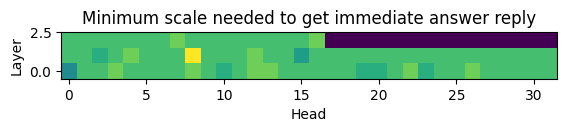

In [68]:
# now plot the scales
fig, ax = plt.subplots()
ax.imshow(scales-base_scale)
ax.set_title("Minimum scale needed to get immediate answer reply")
ax.set_xlabel("Head")
ax.set_ylabel("Layer")
ax.invert_yaxis()
plt.show()


In [69]:
scales

array([[1.44444444, 2.11111111, 2.11111111, 2.33333333, 2.11111111,
        2.11111111, 2.11111111, 2.11111111, 2.33333333, 2.11111111,
        1.88888889, 2.11111111, 2.33333333, 2.33333333, 2.11111111,
        2.11111111, 2.11111111, 2.11111111, 2.11111111, 1.88888889,
        1.88888889, 2.11111111, 2.33333333, 1.88888889, 2.11111111,
        2.11111111, 2.33333333, 2.11111111, 2.11111111, 2.11111111,
        2.11111111, 2.11111111],
       [2.11111111, 2.11111111, 1.88888889, 2.11111111, 2.33333333,
        2.11111111, 2.11111111, 2.11111111, 3.        , 2.11111111,
        2.11111111, 2.11111111, 2.33333333, 2.11111111, 2.11111111,
        1.66666667, 2.11111111, 2.11111111, 2.11111111, 2.11111111,
        2.11111111, 2.11111111, 2.11111111, 2.11111111, 2.11111111,
        2.11111111, 2.11111111, 2.11111111, 2.11111111, 2.11111111,
        2.11111111, 2.11111111],
       [2.11111111, 2.11111111, 2.11111111, 2.11111111, 2.11111111,
        2.11111111, 2.11111111, 2.33333333, 2.1111

In [ ]:
scales

In [134]:
scales = np.linspace(1, 3.0, 10)
patched_outs = []
contains_stop_think = []
num_tokens = []
for scale in scales:
    patched_output = generate_with_patching(
        prompt_base=answer_prompt,
        prompt_patch=reasoning_prompt,
        target_head=[(2, 17), (0, 19)],
        max_new_tokens=500,
        base_mode="answering",
        do_sample=False,
        scale=scale,
    )
    print("====================")
    print(patched_output)
    patched_outs.append(patched_output)
    contains_stop_think.append("</think>" in patched_output)
    num_tokens.append(len(model.to_str_tokens(patched_output)))

  2%|▏         | 9/500 [00:00<00:40, 12.19it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 40%|███▉      | 198/500 [00:14<00:22, 13.55it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that a prime number is a number greater than 1 that has no positive divisors other than 1 and itself.

Starting from the smallest prime number, which is 2, I'll continue listing each subsequent prime number.

After listing the first seven prime numbers, I can identify the seventh one.
</think>

To find the **7th prime number**, let's list the prime numbers in order until we reach the 7th one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

**Final Answer:** \(\boxed{17}\)


  2%|▏         | 9/500 [00:00<00:40, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 40%|███▉      | 198/500 [00:14<00:22, 13.55it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that a prime number is a number greater than 1 that has no positive divisors other than 1 and itself.

Starting from the smallest prime number, which is 2, I'll continue listing each subsequent prime number.

After identifying the first seven prime numbers, I can determine the seventh one.
</think>

To find the **7th prime number**, let's list the prime numbers in order until we reach the 7th one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

**Final Answer:** \(\boxed{17}\)


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 51%|█████     | 253/500 [00:18<00:18, 13.54it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that a prime number is a number greater than 1 that has no positive divisors other than 1 and itself.

Starting from the smallest prime number:

1. **2** is the first prime number.
2. **3** is the second prime number.
3. **5** is the third prime number.
4. **7** is the fourth prime number.
5. **11** is the fifth prime number.
6. **13** is the sixth prime number.
7. **17** is the seventh prime number.

Therefore, the seventh prime number is **17**.
</think>

To find the **7th prime number**, let's list the prime numbers in order until we reach the seventh one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

**Final Answer

  2%|▏         | 9/500 [00:00<00:39, 12.30it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 44%|████▎     | 218/500 [00:16<00:20, 13.54it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

1. **2** is the first prime number.
2. **3** is the second prime number.
3. **5** is the third prime number.
4. **7** is the fourth prime number.
5. **11** is the fifth prime number.
6. **13** is the sixth prime number.
7. **17** is the seventh prime number.

Therefore, the seventh prime number is **17**.
</think>

To find the **seventh prime number**, let's list the prime numbers in order until we reach the seventh one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

**Final Answer:** \boxed{17}


  2%|▏         | 9/500 [00:00<00:40, 12.26it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.25it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:39, 12.28it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.18it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.27it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.27it/s]

<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


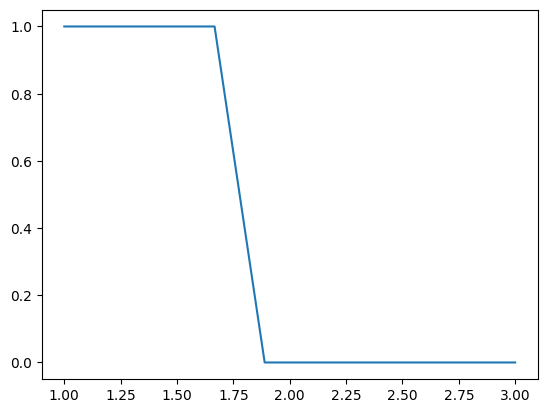

In [135]:
fig, ax = plt.subplots()
ax.plot(scales, contains_stop_think)
plt.show()


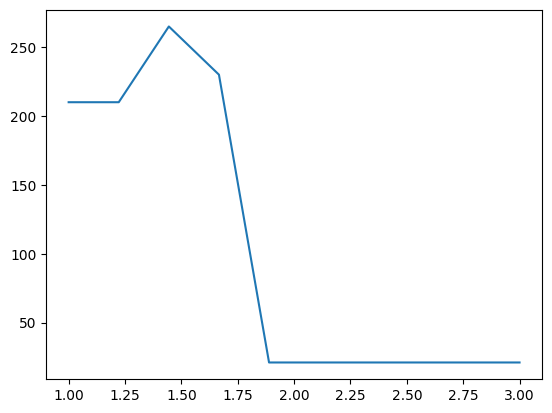

In [136]:

fig, ax = plt.subplots()
ax.plot(scales, num_tokens)
plt.show()


In [137]:
scales = np.linspace(1, 3.0, 25)
patched_outs_sample = []
contains_stop_think_sample = []
num_tokens_sample = []
for scale in scales:
    patched_output = generate_with_patching(
        prompt_base=answer_prompt,
        prompt_patch=reasoning_prompt,
        target_head=[(2, 17), (0, 19)],
        max_new_tokens=500,
        base_mode="answering",
        do_sample=True,
        scale=scale,
    )
    print("====================")
    print(patched_output)
    patched_outs_sample.append(patched_output)
    contains_stop_think_sample.append("</think>" in patched_output)
    num_tokens_sample.append(len(model.to_str_tokens(patched_output)))

 22%|██▏       | 109/500 [00:08<00:29, 13.42it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

**Question:** What is the seventh prime number?

**Solution:**

A **prime number** is a natural number greater than 1 that has no positive divisors other than 1 and itself.

Let's list the prime numbers in order:

1. **2** (the smallest and only even prime number)
2. **3**
3. **5**
4. **7**
5. **11**
6. **13**
7. **17**

So, the **seventh prime number** is:

\boxed{17}


 52%|█████▏    | 262/500 [00:19<00:17, 13.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I need to start by listing the prime numbers in order.

First, I'll consider the number 2, which is the smallest and only even prime number.

Next, I'll list the odd numbers starting from 3 and check if they are prime.

3 is a prime number because it has no divisors other than 1 and itself.

5 is also a prime number as it is not divisible by any number other than 1 and 5.

7 is a prime number as well, with no divisors apart from 1 and 7.

Continuing this process, 11, 13, and 17 are all prime numbers.

After listing out the first few prime numbers, I can identify the seventh one.
</think>

To find the **7th prime number**, let's list the prime numbers in order:

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The

  2%|▏         | 9/500 [00:00<00:40, 12.11it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 72%|███████▏  | 358/500 [00:26<00:10, 13.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

First, I list the prime numbers sequentially:

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

By following this sequence, I identify that the seventh prime number is **17**.
</think>

To find the **seventh prime number**, let's list the prime numbers in order until we reach the seventh one.

**Prime numbers** are natural numbers greater than 1 that have no positive divisors other than 1 and themselves.

Here is the sequence of prime numbers:

1. **2**  
2. **3**  
3. **5**  
4. **7**  
5. **11**  
6. **13**  
7. **17**  

**Step-b

  2%|▏         | 9/500 [00:00<00:40, 12.11it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


 82%|████████▏ | 411/500 [00:30<00:06, 13.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in ascending order.

First, I know that a prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

Starting from the smallest prime number, which is 2, I'll continue listing each subsequent prime number by checking if it has any divisors other than 1 and itself.

After identifying the first seven prime numbers, I can then determine the seventh one.
</think>

To find the **7th prime number**, let's list the prime numbers in ascending order and identify the seventh one.

### Steps:

1. **Prime Number Definition:**
   - A **prime number** is a natural number greater than 1 that has no positive divisors other than 1 and itself.

2. **List of Prime Numbers:**
   - Start from the smallest prime number and move upwards.
   
   | Position | Prime Number |
   |-----------|---------------|
   | 1st      | 2    

  7%|▋         | 36/500 [00:02<00:35, 13.13it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is:

2, 3, 5, 7, **11**, 13, 17, ...

**11** is the seventh prime number.


 62%|██████▏   | 309/500 [00:23<00:14, 13.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order beginning from 1.

1 is not considered a prime number.

2 is the first prime number because it has no divisors other than 1 and itself.

3 is the next prime number as it is only divisible by 1 and 3.

4 is not a prime number because it can be divided by 2.

5 is a prime number since its only divisors are 1 and 5.

6 is not a prime number because it can be divided by 2 and 3.

7 is a prime number as it is only divisible by 1 and 7.

8 is not a prime number because it can be divided by 2.

9 is not a prime number because it can be divided by 3.

10 is not a prime number because it can be divided by 2.

Continuing this process, I'll identify the seventh prime number in the sequence.
</think>

To find the **seventh prime number**, let's list the prime numbers in order:

1. **2** - The first prime number.
2. **3** - The second prime number.
3.

 79%|███████▉  | 397/500 [00:29<00:07, 13.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

Let's find the seventh prime number.

**Step 1: List the numbers in order**

Starting with 1 and moving upwards:

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...

**Step 2: Identify Prime Numbers**

A prime number is defined as a number greater than 1 that has no positive divisors other than 1 and itself.

- **1** is not a prime number.
- **2** is a prime number (only divisors are 1 and 2).
- **3** is a prime number (only divisors are 1 and 3).
- **4** is not a prime number (divisors include 1, 2, and 4).
- **5** is a prime number (only divisors are 1 and 5).
- **6** is not a prime number (divisors include 1, 2, 3, and 6).
- **7** is a prime number (only divisors are 1 and 7).
- **8** is not a prime number.
- **9** is not a prime number (divisors include 1, 3, and 9).
- **10** is not a prime number.
- **11** is a prime number (only divisors are 1 and 11).

**Step 3: Count the Prime Numbers**

Let's count the prime numbers i

 75%|███████▌  | 377/500 [00:28<00:09, 13.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I will start by listing the prime numbers in order.

First, I know that a prime number is a number greater than 1 that has no positive divisors other than 1 and itself.

Starting from the smallest prime number:

1 is not considered a prime number.

2 is the first prime number.

3 is the second prime number.

4 is not a prime number because it can be divided by 2.

5 is the third prime number.

6 is not a prime number because it can be divided by 2 and 3.

7 is the fourth prime number.

8 is not a prime number because it can be divided by 2.

9 is not a prime number because it can be divided by 3.

10 is not a prime number because it can be divided by 2 and 5.

11 is the fifth prime number.

12 is not a prime number because it can be divided by 2, 3, and 6.

13 is the sixth prime number.

14 is not a prime number because it can be divided by 2 and 7.

15 is not a prime number because it 

 28%|██▊       | 138/500 [00:10<00:26, 13.41it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.

A prime number is a natural number greater than **1** that has no positive divisors other than **1** and itself. The sequence of prime numbers begins with **2, 3, 5, 7, 11, 13**, and then **17**.

Let’s verify:

1. **2** is prime.
2. **3** is prime.
3. **5** is prime.
4. **7** is prime.
5. **11** is prime.
6. **13** is prime.
7. **17** is prime.

So, the seventh prime number is indeed **17**.


 73%|███████▎  | 367/500 [00:27<00:09, 13.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that prime numbers are numbers greater than 1 that have no positive divisors other than 1 and themselves.

Starting from the smallest prime number:

1 is not considered a prime number.

2 is the first prime number.

3 is the second prime number.

4 is not a prime number because it can be divided by 2.

5 is the third prime number.

6 is not a prime number because it can be divided by 2 and 3.

7 is the fourth prime number.

8 is not a prime number because it can be divided by 2.

9 is not a prime number because it can be divided by 3.

10 is not a prime number because it can be divided by 2 and 5.

11 is the fifth prime number.

12 is not a prime number because it can be divided by 2, 3, and 4.

13 is the sixth prime number.

14 is not a prime number because it can be divided by 2 and 7.

15 is not a prime number because i

 19%|█▊        | 93/500 [00:06<00:30, 13.34it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh **prime number** is **19**.

**Sequence of Prime Numbers:** 
1. **2**  
2. **3**  
3. **5**  
4. **7**  
5. **11**  
6. **13**  
7. **17**  
8. **19**  
9. **23**  
10. **29**

Thus, the number **19** is the **7th** prime number.


  2%|▏         | 9/500 [00:00<00:40, 12.06it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 29%|██▉       | 146/500 [00:10<00:26, 13.41it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

To determine the seventh prime number, let's list out the prime numbers in order until we reach the seventh one.

1. **2** - Prime (only divisible by 1 and itself)
2. **3** - Prime (only divisible by 1 and itself)
3. **5** - Prime (only divisible by 1 and itself)
4. **7** - Prime (only divisible by 1 and itself)
5. **11** - Prime (only divisible by 1 and itself)
6. **13** - Prime (only divisible by 1 and itself)
7. **17** - Prime (only divisible by 1 and itself)

So, the seventh prime number is **17**.


 90%|████████▉ | 448/500 [00:33<00:03, 13.32it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I will start by listing prime numbers in order.

1. **Prime Number 1**: Let's begin by considering the number 2 as the first prime number.
2. **Prime Number 2**: After 2, the next prime number is 3.
3. **Prime Number 3**: Following 3, the next prime number is 5.
4. **Prime Number 4**: Next, 7 is a prime number.
5. **Prime Number 5**: The number 11 comes after 7.
6. **Prime Number 6**: After 11, the next prime number is 13.
7. **Prime Number 7**: Finally, 17 is the seventh prime number.

So, the seventh prime number is 17.
</think>

To determine the **7th prime number**, let's list the prime numbers in order until we reach the 7th one.

1. **Prime Number 1**: **2**  
   - 2 is a prime number because it has no divisors other than 1 and itself.
   
2. **Prime Number 2**: **3**  
   - 3 is a prime number as it is only divisible by 1 and 3.

3. **Prime Number 3**: **5**  
   - 5 is a prime n

  2%|▏         | 9/500 [00:00<00:40, 12.12it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.12it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.14it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.10it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 22%|██▏       | 109/500 [00:08<00:29, 13.33it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

**Solution:**

Prime numbers are numbers greater than 1 that have no positive divisors other than 1 and themselves. Let's list the prime numbers in order:

1. **2** (Prime)
2. **3** (Prime)
3. **5** (Prime)
4. **7** (Prime)
5. **11** (Prime)
6. **13** (Prime)
7. **17** (Prime)

So, the **7th prime number** is **17**.

\boxed{17}


 59%|█████▉    | 295/500 [00:22<00:15, 13.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

1. **Prime Number 1**: 2  
   - 2 is the first prime number.
   
2. **Prime Number 2**: 3  
   - 3 is the second prime number.
   
3. **Prime Number 3**: 5  
   - 5 is the third prime number.
   
4. **Prime Number 4**: 7  
   - 7 is the fourth prime number.
   
5. **Prime Number 5**: 11  
   - 11 is the fifth prime number.
   
6. **Prime Number 6**: 13  
   - 13 is the sixth prime number.
   
7. **Prime Number 7**: 17  
   - 17 is the seventh prime number.

Therefore, the seventh prime number is **17**.
</think>

To find the **seventh prime number**, let's list the prime numbers in order until we reach the seventh one.

1. **1st prime number**: **2**
2. **2nd prime number**: **3**
3. **3rd prime number**: **5**
4. **4th prime number**: **7**
5. **5th prime number**: **11**
6. **6th prime number**: **13**
7. **7th prime number**: **17**


 52%|█████▏    | 261/500 [00:19<00:17, 13.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

To determine the **seventh prime number**, let's follow these steps:

1. **List out the prime numbers in order**:
   
   A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

   Starting from the smallest prime numbers:

   1. **2** (prime)
   2. **3** (prime)
   3. **5** (prime)
   4. **7** (prime)
   5. **11** (prime)
   6. **13** (prime)
   7. **17** (prime)
   
2. **Count to the seventh position** in the list of prime numbers.

   Let's enumerate them:

   - 1st prime: **2**
   - 2nd prime: **3**
   - 3rd prime: **5**
   - 4th prime: **7**
   - 5th prime: **11**
   - 6th prime: **13**
   - 7th prime: **17**

3. **Identify the seventh prime**.

   From the enumeration above, the **seventh prime number** is:

   \[
   \boxed{17}
   \]


 43%|████▎     | 213/500 [00:15<00:21, 13.42it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, let's follow these steps:

1. **List the numbers in order**: Start with the natural numbers beginning from 1.

2. **Identify prime numbers**: A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

3. **Check each number**:
   - **1**: Not a prime number (by definition).
   - **2**: Prime (only divisors are 1 and 2).
   - **3**: Prime (only divisors are 1 and 3).
   - **4**: Not prime (divisible by 2).
   - **5**: Prime (only divisors are 1 and 5).
   - **6**: Not prime (divisible by 2 and 3).
   - **7**: Prime (only divisors are 1 and 7).

4. **Determine the seventh prime**: Counting them in order, the seventh prime number is **7**.

**Answer:** 7


 12%|█▏        | 61/500 [00:04<00:32, 13.35it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.

**List of Prime Numbers:**
1. **2**
2. **3**
3. **5**
4. **7**
5. **11**
6. **13**
7. **17**

Let me know if you'd like further clarification!


  2%|▏         | 9/500 [00:00<00:40, 12.20it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 18%|█▊        | 88/500 [00:06<00:30, 13.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.

Let's list out the prime numbers in order to confirm:

1. **2** (Prime)
2. **3** (Prime)
3. **5** (Prime)
4. **7** (Prime)
5. **11** (Prime)
6. **13** (Prime)
7. **17** (Prime)

So, the seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.15it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 19%|█▉        | 96/500 [00:07<00:30, 13.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**. 

Here’s a list of the first ten prime numbers for reference:

1. **2**
2. **3**
3. **5**
4. **7**
5. **11**
6. **13**
7. **17**
8. **19**
9. **23**
10. **29**

Each prime number is only divisible by **1** and itself, making them the building blocks of all other numbers.


  2%|▏         | 9/500 [00:00<00:40, 12.16it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.13it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.12it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.12it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.


  2%|▏         | 9/500 [00:00<00:40, 12.11it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 15%|█▌        | 77/500 [00:05<00:31, 13.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh **prime number** is **17**.

**List of prime numbers in order:**
1. 2
2. 3
3. 5
4. 7
5. 11
6. 13
7. **17**

Prime numbers are natural numbers greater than 1 that have no positive divisors other than 1 and themselves.


  2%|▏         | 9/500 [00:00<00:40, 12.11it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 20%|██        | 100/500 [00:07<00:29, 13.38it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh **prime number** is **17**.

**Prime numbers** are natural numbers greater than 1 that have no positive divisors other than 1 and themselves. The sequence of prime numbers starts as follows:

1. **2** (the only even prime number)
2. **3**
3. **5**
4. **7**
5. **11**
6. **13**
7. **17**

So, the seventh prime number is \(\boxed{17}\).


  2%|▏         | 9/500 [00:00<00:40, 12.17it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 24%|██▍       | 122/500 [00:09<00:28, 13.31it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

To find the **7th prime number**, we'll list the prime numbers in order until we reach the 7th one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The **7th** prime number.

**Answer:**  
The 7th prime number is \boxed{17}.


  2%|▏         | 9/500 [00:00<00:40, 12.12it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 43%|████▎     | 216/500 [00:16<00:21, 13.37it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh **prime number** is **17**.

**Step-by-step explanation:**

1. **Understanding prime numbers:** A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

2. **Listing prime numbers in order:**
   1. **2** (Prime)
   2. **3** (Prime)
   3. **5** (Prime)
   4. **7** (Prime)
   5. **11** (Prime)
   6. **13** (Prime)
   7. **17** (Prime)

3. **Identifying the seventh one:** Counting through the list:
   - 1st: 2
   - 2nd: 3
   - 3rd: 5
   - 4th: 7
   - 5th: 11
   - 6th: 13
   - 7th: 17

**Final Answer:** \boxed{17}


  2%|▏         | 9/500 [00:00<00:40, 12.05it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 29%|██▊       | 143/500 [00:10<00:26, 13.36it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

To find the **7th prime number**, we'll list the prime numbers in order until we reach the 7th one.

**Prime numbers** are numbers greater than 1 that have no positive divisors other than 1 and themselves.

Here's the sequence of prime numbers starting from the smallest:

1. **2** (first prime number)
2. **3** (second prime number)
3. **5** (third prime number)
4. **7** (fourth prime number)
5. **11** (fifth prime number)
6. **13** (sixth prime number)
7. **17** (seventh prime number)

**Answer:** \boxed{17}


  2%|▏         | 9/500 [00:00<00:40, 12.23it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 31%|███       | 155/500 [00:11<00:25, 13.47it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh **prime number** is **17**.

**Here’s how to find it:**

1. **List of prime numbers in order:**
   - 2
   - 3
   - 5
   - 7
   - **11**
   - **13**
   - **17**

2. **Count them sequentially:**
   - 1st prime: **2**
   - 2nd prime: **3**
   - 3rd prime: **5**
   - 4th prime: **7**
   - 5th prime: **11**
   - 6th prime: **13**
   - 7th prime: **17**

So, the seventh prime number is **17**!


  2%|▏         | 9/500 [00:00<00:40, 12.23it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 69%|██████▉   | 344/500 [00:25<00:11, 13.46it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.

**Step-by-Step Explanation:**

1. **Understanding Prime Numbers:** A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.
   
2. **Listing Prime Numbers:** Let's list the prime numbers in order starting from the smallest:
   - 2 (Prime)
   - 3 (Prime)
   - 4 (Not Prime, divisible by 2)
   - 5 (Prime)
   - 6 (Not Prime, divisible by 2 and 3)
   - 7 (Prime)
   - 8 (Not Prime, divisible by 2)
   - **9 (Not Prime, divisible by 3)** 
   - 10 (Not Prime, divisible by 2 and 5)
   - 11 (Prime)
   - 12 (Not Prime, divisible by 2 and 3)
   - 13 (Prime)
   - 14 (Not Prime, divisible by 2)
   - **15 (Not Prime, divisible by 3 and 5)**
   - 16 (Not Prime, divisible by 2)
   - 17 (Prime)

3. **Counting the Primes:** Now, count the prime numbers up to 17:
   - 2 (1st prime)
   - 3 (2nd prime)
   - 5 (3rd prime)
   - 7 (4th prime)
   - 11 (5th p

  2%|▏         | 9/500 [00:00<00:40, 12.22it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


 25%|██▌       | 125/500 [00:09<00:27, 13.44it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

**Solution:**

A **prime number** is a natural number greater than 1 that has no positive divisors other than 1 and itself.

Let's list the **prime numbers** in order until we reach the seventh one:

1. **2** - Prime (Only divisor is 1 and itself)
2. **3** - Prime
3. **5** - Prime
4. **7** - Prime
5. **11** - Prime
6. **13** - Prime
7. **17** - **Prime**

**Answer:** The seventh prime number is \boxed{17}.


  2%|▏         | 9/500 [00:00<00:40, 12.26it/s]

<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
The seventh prime number is **17**.


In [146]:
patched_outs_sample

'<｜User｜>What is the seventh prime number?<｜Assistant｜><think>\nThe seventh prime number is **17**.'

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

def rolling_average(data, window_size=5):
    """Compute rolling average with specified window size."""
    if len(data) < window_size:
        return np.full(len(data), np.mean(data))
    
    padded = np.pad(data, (window_size//2, window_size//2), mode='edge')
    return np.convolve(padded, np.ones(window_size)/window_size, mode='valid')

def rolling_probability(boolean_data, window_size=5):
    """Compute rolling probability for boolean data."""
    if len(boolean_data) < window_size:
        return np.full(len(boolean_data), np.mean(boolean_data))
    
    padded = np.pad(boolean_data, (window_size//2, window_size//2), mode='edge')
    return np.convolve(padded.astype(float), np.ones(window_size)/window_size, mode='valid')

# Convert your data
scales = np.linspace(1, 3.0, 25)
contains_stop_think_bool = np.array(contains_stop_think_sample, dtype=bool)
num_tokens_array = np.array(num_tokens_sample)

# Compute rolling statistics
window_size = 5  # Adjust as needed
rolling_prob = rolling_probability(contains_stop_think_bool, window_size)
rolling_avg_tokens = rolling_average(num_tokens_array, window_size)

# Create the visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot 1: Rolling probability of containing "</think>"
ax1.scatter(scales, contains_stop_think_bool.astype(float), 
           alpha=0.4, s=30, color='lightcoral', label='Individual samples')
ax1.plot(scales, rolling_prob, color='darkred', linewidth=2.5, 
         label=f'Rolling probability (window={window_size})')
ax1.set_ylabel('Probability of containing "</think>"')
ax1.set_ylim(-0.05, 1.05)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_title('Stop-Think Pattern vs Scale')

# Plot 2: Rolling average of token count with variance visualization
ax2.scatter(scales, num_tokens_array, alpha=0.4, s=30, color='lightsteelblue', 
           label='Individual samples')
ax2.plot(scales, rolling_avg_tokens, color='steelblue', linewidth=2.5,
         label=f'Rolling average (window={window_size})')

# Add confidence band to show variance
rolling_std = []
half_window = window_size // 2
for i in range(len(scales)):
    start_idx = max(0, i - half_window)
    end_idx = min(len(num_tokens_array), i + half_window + 1)
    rolling_std.append(np.std(num_tokens_array[start_idx:end_idx]))

rolling_std = np.array(rolling_std)
ax2.fill_between(scales, 
                 rolling_avg_tokens - rolling_std, 
                 rolling_avg_tokens + rolling_std,
                 alpha=0.2, color='steelblue', label='±1 std dev')

ax2.set_xlabel('Scale')
ax2.set_ylabel('Number of tokens')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_title('Token Count vs Scale')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Scale range: {scales[0]:.2f} to {scales[-1]:.2f}")
print(f"Stop-think probability range: {rolling_prob.min():.3f} to {rolling_prob.max():.3f}")
print(f"Token count range: {rolling_avg_tokens.min():.1f} to {rolling_avg_tokens.max():.1f}")
print(f"Average variance in token count: {np.mean(rolling_std):.1f}")

# Optional: Correlation analysis
correlation = stats.pearsonr(scales, rolling_prob)[0]
print(f"Correlation between scale and stop-think probability: {correlation:.3f}")

correlation_tokens = stats.pearsonr(scales, rolling_avg_tokens)[0]
print(f"Correlation between scale and token count: {correlation_tokens:.3f}")
    

NameError: name 'contains_stop_think_sample' is not defined

In [100]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Any, Optional
from transformer_lens import HookedTransformer

def head_patch_experiment(
    model: HookedTransformer,
    reasoning_prompt: str,
    reasoning_completion: str,
    answering_prompt: str,
    answering_completion: str,
    max_layer: Optional[int] = None,
    additional_patched_heads: Optional[List[Tuple[int, int]]] = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Comprehensive attention head patching experiment to identify reasoning vs answering heads.
    
    For each (layer, head), measures two effects:
    1) Reasoning effect: How much reasoning_completion average logprob changes when we patch 
       reasoning head activations into answering context (vs unpatched answering context)
    2) Answering effect: How much answering_completion average logprob changes when we patch
       answering head activations into reasoning context (vs unpatched reasoning context)
    
    Args:
        model: HookedTransformer model
        reasoning_prompt: Prompt that elicits reasoning
        reasoning_completion: The reasoning text to measure
        answering_prompt: Prompt that elicits direct answers  
        answering_completion: The answer text to measure
        max_layer: Maximum layer to test (None = test all layers)
        additional_patched_heads: List of (layer, head) pairs to patch in ALL experiments
                                 (for studying head interactions)
    
    Returns:
        Tuple of (reasoning_effects, answering_effects) - both shape (n_layers, n_heads)
    """
    model.reset_hooks()    
    model.eval()
    device = next(model.parameters()).device
    
    if additional_patched_heads is None:
        additional_patched_heads = []

    # Tokenize all components
    # note, to_tokens adds bos token to the beginning of the sequence
    tokens_rp = model.to_tokens(reasoning_prompt, prepend_bos=True)[0]       # reasoning prompt
    tokens_rc = model.to_tokens(reasoning_completion, prepend_bos=False)[0]   # reasoning completion
    tokens_ap = model.to_tokens(answering_prompt, prepend_bos=True)[0]       # answering prompt  
    tokens_ac = model.to_tokens(answering_completion, prepend_bos=False)[0]   # answering completion

    rpL, rcL, apL, acL = len(tokens_rp), len(tokens_rc), len(tokens_ap), len(tokens_ac)

    print(f"Sequence lengths - Reasoning prompt: {rpL}, completion: {rcL}")
    print(f"                   Answering prompt: {apL}, completion: {acL}")
    if additional_patched_heads:
        print(f"Additional heads always patched: {additional_patched_heads}")

    # Build full sequences
    full_reason = torch.cat([tokens_rp, tokens_rc]).unsqueeze(0).to(device)
    full_answer = torch.cat([tokens_ap, tokens_ac]).unsqueeze(0).to(device)

    # assert that bos only occurs once in each, and at the beginning
    assert full_reason[0, 0] == model.tokenizer.bos_token_id
    assert full_answer[0, 0] == model.tokenizer.bos_token_id
    assert full_reason[0, 1:].tolist().count(model.tokenizer.bos_token_id) == 0
    assert full_answer[0, 1:].tolist().count(model.tokenizer.bos_token_id) == 0

    # Prepare input/target pairs (shift by 1 for language modeling)
    inp_r = full_reason[:, :-1]   # input tokens
    tgt_r = full_reason[:, 1:]    # target tokens (shifted)
    inp_a = full_answer[:, :-1]
    tgt_a = full_answer[:, 1:]

    # Determine testing range
    n_layers = model.cfg.n_layers if max_layer is None else min(max_layer, model.cfg.n_layers)
    n_heads = model.cfg.n_heads

    print(f"Testing {n_layers} layers × {n_heads} heads = {n_layers * n_heads} combinations")

    # =============================================================================
    # STEP 1: Baseline runs to capture head activations 
    # =============================================================================
    
    print("Running baseline: reasoning context...")
    stored_reason_heads = {}  # layer -> [1, seq_len, n_heads, head_dim]
    
    def save_reason_heads(activation, hook):
        layer_idx = int(hook.name.split('.')[1])
        if layer_idx < n_layers:  # Only store if we're testing this layer
            stored_reason_heads[layer_idx] = activation.detach().cpu().clone()
        return activation

    # Add hooks for layers we're testing
    for layer in range(n_layers):
        hook_name = f"blocks.{layer}.attn.hook_z"
        model.add_hook(hook_name, save_reason_heads)

    # Forward pass on reasoning context
    with torch.no_grad():
        logits_r = model(inp_r)  # [1, seq_len, vocab_size]
    model.reset_hooks()

    # -------------------------------------------------------------------------
    
    print("Running baseline: answering context...")
    stored_answer_heads = {}
    
    def save_answer_heads(activation, hook):
        layer_idx = int(hook.name.split('.')[1])
        if layer_idx < n_layers:  # Only store if we're testing this layer
            stored_answer_heads[layer_idx] = activation.detach().cpu().clone()
        return activation

    # Add hooks for layers we're testing
    for layer in range(n_layers):
        hook_name = f"blocks.{layer}.attn.hook_z"
        model.add_hook(hook_name, save_answer_heads)

    # Forward pass on answering context
    with torch.no_grad():
        logits_a = model(inp_a)
    model.reset_hooks()

    # =============================================================================
    # STEP 2: Patching experiments for each head
    # =============================================================================
    
    effect_reasoning = np.zeros((n_layers, n_heads))
    effect_answering = np.zeros((n_layers, n_heads))

    print(f"\nStarting patching experiments...")

    for layer in range(n_layers):
        print(f"  Testing layer {layer}...")
        
        reason_heads = stored_reason_heads[layer]  # [1, rpL+rcL-1, n_heads, head_dim]
        answer_heads = stored_answer_heads[layer]  # [1, apL+acL-1, n_heads, head_dim]

        for head in range(n_heads):
            
            # ================================================================
            # EXPERIMENT A: Patch reasoning head → answering context
            # Test: answering_prompt + reasoning_completion
            # ================================================================
            
            # Build patched sequence: answering_prompt + reasoning_completion
            full_patch_r = torch.cat([tokens_ap, tokens_rc]).unsqueeze(0).to(device)
            inp_patch_r = full_patch_r[:, :-1]
            
            # Get UNPATCHED baseline for this context first
            with torch.no_grad():
                baseline_logits_r = model(inp_patch_r)
            baseline_avg_logprob_r = compute_completion_logprob(
                baseline_logits_r, full_patch_r[:, 1:], start_idx=apL-1, length=rcL, return_average=True
            )
            
            # Create patching hook
            def patch_reasoning_head(activation, hook):
                patched = activation.clone()
                target_layer = int(hook.name.split('.')[1])
                
                # Always patch additional heads
                for add_layer, add_head in additional_patched_heads:
                    if add_layer == target_layer:
                        # Map positions from reasoning context to patch context
                        for j in range(rcL):
                            reason_pos = (rpL - 1) + j  
                            patch_pos = (apL - 1) + j   
                            
                            if (reason_pos < reason_heads.shape[1] and 
                                patch_pos < patched.shape[1] and
                                add_layer < len(stored_reason_heads)):
                                patched[0, patch_pos, add_head, :] = \
                                    stored_reason_heads[add_layer][0, reason_pos, add_head, :].to(device)
                
                # Patch the target head (if it's the right layer)
                if target_layer == layer:
                    for j in range(rcL):
                        reason_pos = (rpL - 1) + j  
                        patch_pos = (apL - 1) + j   
                        
                        if reason_pos < reason_heads.shape[1] and patch_pos < patched.shape[1]:
                            patched[0, patch_pos, head, :] = reason_heads[0, reason_pos, head, :].to(device)
                
                return patched

            # Add hooks for all layers (since additional heads might be in any layer)
            hook_names = []
            for l in range(max(n_layers, max([ah[0] for ah in additional_patched_heads] + [0]) + 1)):
                hook_name = f"blocks.{l}.attn.hook_z"
                model.add_hook(hook_name, patch_reasoning_head)
                hook_names.append(hook_name)
            
            with torch.no_grad():
                logits_patch_r = model(inp_patch_r)
            model.reset_hooks()

            # Measure reasoning completion logprob in patched context
            patched_avg_logprob_r = compute_completion_logprob(
                logits_patch_r, full_patch_r[:, 1:], start_idx=apL-1, length=rcL, return_average=True
            )
            
            effect_reasoning[layer, head] = patched_avg_logprob_r - baseline_avg_logprob_r

            # ================================================================
            # EXPERIMENT B: Patch answering head → reasoning context  
            # Test: reasoning_prompt + answering_completion
            # ================================================================
            
            # Build patched sequence: reasoning_prompt + answering_completion
            full_patch_a = torch.cat([tokens_rp, tokens_ac]).unsqueeze(0).to(device)
            inp_patch_a = full_patch_a[:, :-1]
            
            # Get UNPATCHED baseline for this context
            with torch.no_grad():
                baseline_logits_a = model(inp_patch_a)
            baseline_avg_logprob_a = compute_completion_logprob(
                baseline_logits_a, full_patch_a[:, 1:], start_idx=rpL-1, length=acL, return_average=True
            )
            
            # Create patching hook
            def patch_answering_head(activation, hook):
                patched = activation.clone()
                target_layer = int(hook.name.split('.')[1])
                
                # Always patch additional heads
                for add_layer, add_head in additional_patched_heads:
                    if add_layer == target_layer:
                        # Map positions from answering context to patch context
                        for j in range(acL):
                            answer_pos = (apL - 1) + j  
                            patch_pos = (rpL - 1) + j   
                            
                            if (answer_pos < answer_heads.shape[1] and 
                                patch_pos < patched.shape[1] and
                                add_layer < len(stored_answer_heads)):
                                patched[0, patch_pos, add_head, :] = \
                                    stored_answer_heads[add_layer][0, answer_pos, add_head, :].to(device)
                
                # Patch the target head (if it's the right layer)
                if target_layer == layer:
                    for j in range(acL):
                        answer_pos = (apL - 1) + j  
                        patch_pos = (rpL - 1) + j   
                        
                        if answer_pos < answer_heads.shape[1] and patch_pos < patched.shape[1]:
                            patched[0, patch_pos, head, :] = answer_heads[0, answer_pos, head, :].to(device)
                
                return patched

            # Add hooks for all layers
            for l in range(max(n_layers, max([ah[0] for ah in additional_patched_heads] + [0]) + 1)):
                hook_name = f"blocks.{l}.attn.hook_z"
                model.add_hook(hook_name, patch_answering_head)
            
            with torch.no_grad():
                logits_patch_a = model(inp_patch_a)
            model.reset_hooks()

            # Measure answering completion logprob in patched context
            patched_avg_logprob_a = compute_completion_logprob(
                logits_patch_a, full_patch_a[:, 1:], start_idx=rpL-1, length=acL, return_average=True
            )
            
            effect_answering[layer, head] = patched_avg_logprob_a - baseline_avg_logprob_a

    print("Patching experiments complete!")
    return effect_reasoning, effect_answering


def compute_completion_logprob(logits: torch.Tensor, targets: torch.Tensor, 
                             start_idx: int, length: int, return_average: bool = True) -> float:
    """
    Compute log probabilities for a completion.
    
    Args:
        logits: Model logits [batch, seq_len, vocab_size]  
        targets: Target token IDs [batch, seq_len]
        start_idx: Index where completion starts (0-indexed)
        length: Length of completion to measure
        return_average: If True, return average logprob per token; if False, return sum
    
    Returns:
        Average (or sum) of log probabilities
    """
    if length <= 0:
        return 0.0
    
    # Get logits for the completion positions
    completion_logits = logits[0, start_idx:start_idx+length]  # [length, vocab_size]
    completion_targets = targets[0, start_idx:start_idx+length]  # [length]
    
    if len(completion_logits) != length or len(completion_targets) != length:
        print(f"Warning: Requested length {length} but got {len(completion_logits)} logits")
        return 0.0
    
    # Compute log probabilities
    log_probs = torch.log_softmax(completion_logits, dim=-1)  # [length, vocab_size]
    token_log_probs = log_probs[range(length), completion_targets]  # [length]
    
    total_logprob = token_log_probs.sum().item()
    return total_logprob / length if return_average else total_logprob


def plot_patching_results(reasoning_effects: np.ndarray, answering_effects: np.ndarray, 
                         figsize=(16, 6), model_name="Model", 
                         additional_patched_heads: Optional[List[Tuple[int, int]]] = None):
    """
    Plot the head patching results with beautiful plasma heatmaps.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Determine symmetric color scale
    
    # Plot reasoning effects
    im1 = ax1.imshow(reasoning_effects, cmap='plasma', aspect='auto', 
                     vmin=reasoning_effects.min(), vmax=reasoning_effects.max())
    title1 = 'Reasoning Heads Effect\n(Reasoning → Answering Context)'
    if additional_patched_heads:
        title1 += f'\n(+ {additional_patched_heads} always patched)'
    ax1.set_title(title1, fontsize=14)
    ax1.set_xlabel('Head Index', fontsize=12)
    ax1.set_ylabel('Layer Index', fontsize=12)
    ax1.set_xticks(range(0, reasoning_effects.shape[1], 4))
    ax1.set_yticks(range(reasoning_effects.shape[0]))
    ax1.invert_yaxis()
    plt.colorbar(im1, ax=ax1, shrink=0.8, label='Avg Log Prob Change')
    
    # Plot answering effects  
    im2 = ax2.imshow(answering_effects, cmap='plasma', aspect='auto',
                     vmin=answering_effects.min(), vmax=answering_effects.max())
    title2 = 'Answering Heads Effect\n(Answering → Reasoning Context)'
    if additional_patched_heads:
        title2 += f'\n(+ {additional_patched_heads} always patched)'
    ax2.set_title(title2, fontsize=14)
    ax2.set_xlabel('Head Index', fontsize=12)
    ax2.set_ylabel('Layer Index', fontsize=12)
    ax2.set_xticks(range(0, answering_effects.shape[1], 4))
    ax2.set_yticks(range(answering_effects.shape[0]))
    ax2.invert_yaxis()
    plt.colorbar(im2, ax=ax2, shrink=0.8, label='Avg Log Prob Change')
    
    plt.suptitle(f'{model_name} - Attention Head Specialization Analysis', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print top heads
    print_top_heads(reasoning_effects, answering_effects)


def print_top_heads(reasoning_effects: np.ndarray, answering_effects: np.ndarray, top_k=5):
    """Print the most important heads for each behavior."""
    
    # Find top reasoning heads
    reasoning_flat = reasoning_effects.flatten()
    top_reasoning_idx = np.argpartition(reasoning_flat, -top_k)[-top_k:]
    top_reasoning_idx = sorted(top_reasoning_idx, key=lambda x: reasoning_flat[x], reverse=True)
    
    print(f"\n🧠 Top {top_k} REASONING heads (most help reasoning in answering context):")
    for i, idx in enumerate(top_reasoning_idx, 1):
        layer = idx // reasoning_effects.shape[1]
        head = idx % reasoning_effects.shape[1]
        effect = reasoning_flat[idx]
        print(f"  {i}. Layer {layer:2d}, Head {head:2d}: {effect:+.4f}")
    
    # Find top answering heads
    answering_flat = answering_effects.flatten()
    top_answering_idx = np.argpartition(answering_flat, -top_k)[-top_k:]
    top_answering_idx = sorted(top_answering_idx, key=lambda x: answering_flat[x], reverse=True)
    
    print(f"\n💡 Top {top_k} ANSWERING heads (most help answering in reasoning context):")
    for i, idx in enumerate(top_answering_idx, 1):
        layer = idx // answering_effects.shape[1]
        head = idx % answering_effects.shape[1]
        effect = answering_flat[idx]
        print(f"  {i}. Layer {layer:2d}, Head {head:2d}: {effect:+.4f}")


# Example usage function
def run_reasoning_vs_answering_experiment(
    model: HookedTransformer,
    reasoning_prompt: str = "Let me think step by step about this problem:",
    reasoning_completion: str = "First, I need to identify the key variables. Then I'll work through the logic systematically to reach a conclusion.",
    answering_prompt: str = "The answer is:",
    answering_completion: str = "42",
    model_name: str = "Model",
    max_layer: Optional[int] = None,
    additional_patched_heads: Optional[List[Tuple[int, int]]] = None
):
    """
    Run the complete reasoning vs answering experiment.
    
    Args:
        max_layer: Test only layers 0 to max_layer-1 (None = all layers)
        additional_patched_heads: Always patch these heads in addition to the target head
    """
    
    print("=" * 80)
    print(f"🔬 ATTENTION HEAD SPECIALIZATION EXPERIMENT - {model_name}")
    print("=" * 80)
    print(f"Reasoning prompt: '{reasoning_prompt}'")
    print(f"Reasoning completion: '{reasoning_completion}'")
    print(f"Answering prompt: '{answering_prompt}'") 
    print(f"Answering completion: '{answering_completion}'")
    if max_layer is not None:
        print(f"Testing layers: 0 to {max_layer-1}")
    if additional_patched_heads:
        print(f"Additional heads always patched: {additional_patched_heads}")
    print()
    
    # Run the experiment
    reasoning_effects, answering_effects = head_patch_experiment(
        model=model,
        reasoning_prompt=reasoning_prompt,
        reasoning_completion=reasoning_completion,
        answering_prompt=answering_prompt,
        answering_completion=answering_completion,
        max_layer=max_layer,
        additional_patched_heads=additional_patched_heads
    )
    
    # Plot results
    plot_patching_results(reasoning_effects, answering_effects, 
                         model_name=model_name, additional_patched_heads=additional_patched_heads)
    
    return reasoning_effects, answering_effects

In [101]:
model.reset_hooks()

In [102]:
reasoning_output = model.generate(reasoning_prompt, max_new_tokens=500, do_sample=False, eos_token_id=model.tokenizer.encode("</think>"))
reasoning_completion = reasoning_output[len(reasoning_prompt):]

answering_output = model.generate(answer_prompt, max_new_tokens=500, do_sample=False)
answering_completion = answering_output[len(answer_prompt):]


  0%|          | 1/500 [00:00<00:50,  9.93it/s]

  2%|▏         | 9/500 [00:00<00:39, 12.34it/s]


In [103]:
reasoning_completion

"To determine the seventh prime number, I'll start by listing the prime numbers in order.\n\nFirst, I know that 2 is the smallest and only even prime number.\n\nNext, 3 is the second prime number.\n\nThen, 5 comes after 3 as the third prime.\n\nFollowing that, 7 is the fourth prime number.\n\nThe fifth prime number is 11.\n\nAfter that, 13 is the sixth prime number.\n\nFinally, 17 is the seventh prime number.\n</think>"

In [104]:
print("reasoning_output: ", reasoning_output)
print("answering_output: ", answering_output)
print("reasoning_completion: ", reasoning_completion)
print("answering_completion: ", answering_completion)











reasoning_output:  <｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that 2 is the smallest and only even prime number.

Next, 3 is the second prime number.

Then, 5 comes after 3 as the third prime.

Following that, 7 is the fourth prime number.

The fifth prime number is 11.

After that, 13 is the sixth prime number.

Finally, 17 is the seventh prime number.
</think>
answering_output:  <｜User｜>What is the seventh prime number?<｜Assistant｜><think>
</think>

The seventh prime number is **17**.
reasoning_completion:  To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that 2 is the smallest and only even prime number.

Next, 3 is the second prime number.

Then, 5 comes after 3 as the third prime.

Following that, 7 is the fourth prime number.

The fifth prime number is 11.

After that, 13 is the sixth prime number.

Final

In [108]:
# Example usage

results = head_patch_experiment(
    model=model,  # Your model
    reasoning_prompt=reasoning_prompt,
    reasoning_completion=reasoning_completion,
    answering_prompt=answer_prompt,
    answering_completion=answering_completion,
    max_layer=4,
    additional_patched_heads=None, #[(2, 17)]
)


Sequence lengths - Reasoning prompt: 12, completion: 98
                   Answering prompt: 14, completion: 9
Testing 4 layers × 32 heads = 128 combinations
Running baseline: reasoning context...
Running baseline: answering context...

Starting patching experiments...
  Testing layer 0...
  Testing layer 1...
  Testing layer 2...
  Testing layer 3...
Patching experiments complete!


In [109]:
reasoning_effects, answering_effects =results

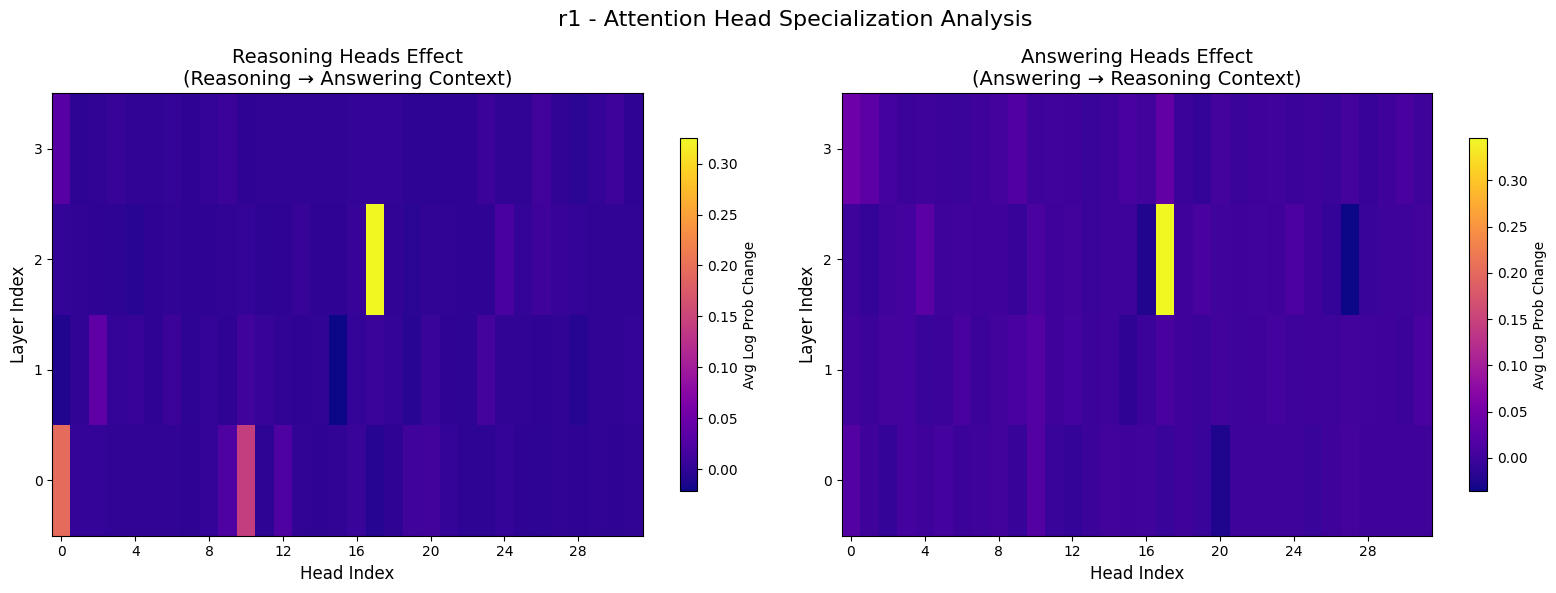


🧠 Top 5 REASONING heads (most help reasoning in answering context):
  1. Layer  2, Head 17: +0.3256
  2. Layer  0, Head  0: +0.1947
  3. Layer  0, Head 10: +0.1422
  4. Layer  1, Head  2: +0.0385
  5. Layer  3, Head  0: +0.0314

💡 Top 5 ANSWERING heads (most help answering in reasoning context):
  1. Layer  2, Head 17: +0.3464
  2. Layer  3, Head  0: +0.0434
  3. Layer  3, Head 17: +0.0339
  4. Layer  3, Head  1: +0.0265
  5. Layer  2, Head  4: +0.0258


In [110]:
plot_patching_results(reasoning_effects, answering_effects, model_name="r1")

In [111]:
results_with_fixed_head = head_patch_experiment(
    model=model,  # Your model
    reasoning_prompt=reasoning_prompt,
    reasoning_completion=reasoning_completion,
    answering_prompt=answer_prompt,
    answering_completion=answering_completion,
    max_layer=4,
    additional_patched_heads=[(2, 17)]
)


Sequence lengths - Reasoning prompt: 12, completion: 98
                   Answering prompt: 14, completion: 9
Additional heads always patched: [(2, 17)]
Testing 4 layers × 32 heads = 128 combinations
Running baseline: reasoning context...
Running baseline: answering context...

Starting patching experiments...
  Testing layer 0...
  Testing layer 1...
  Testing layer 2...
  Testing layer 3...
Patching experiments complete!


In [112]:
reasoning_effects_with_fixed_head, answering_effects_with_fixed_head =results_with_fixed_head

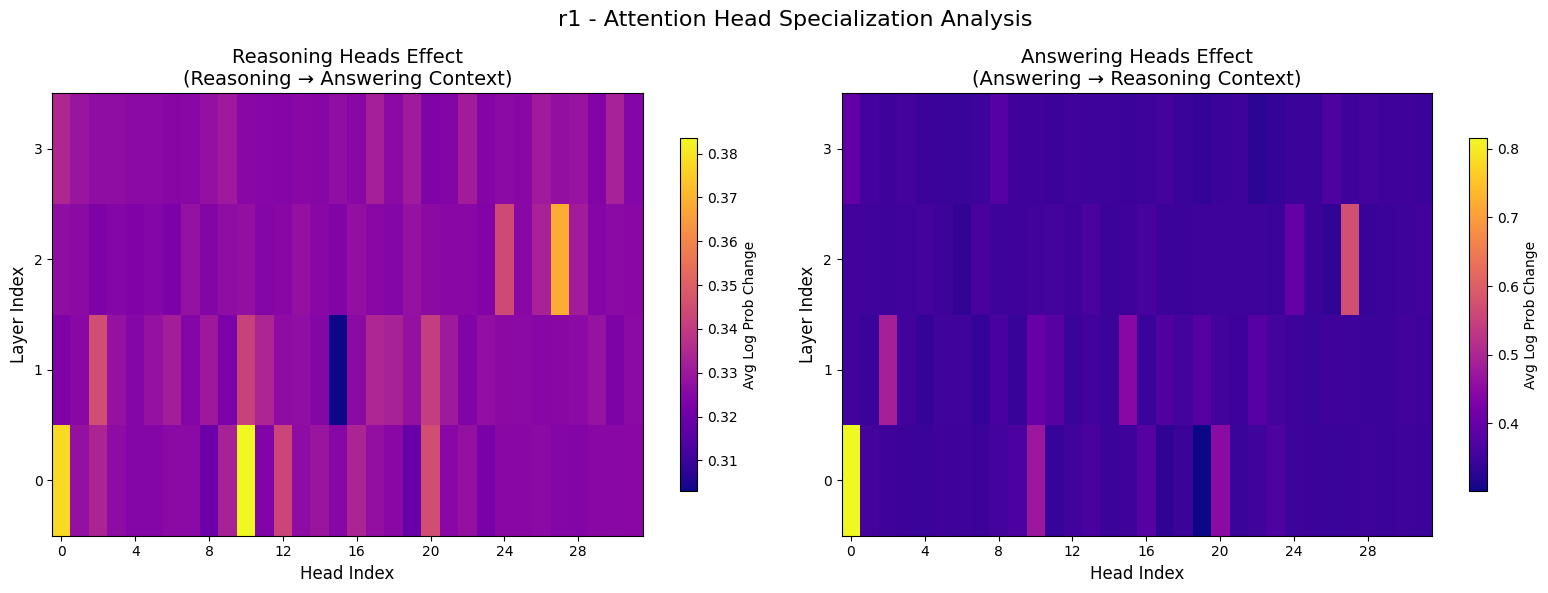


🧠 Top 5 REASONING heads (most help reasoning in answering context):
  1. Layer  0, Head 10: +0.3836
  2. Layer  0, Head  0: +0.3778
  3. Layer  2, Head 27: +0.3686
  4. Layer  0, Head 20: +0.3454
  5. Layer  1, Head  2: +0.3450

💡 Top 5 ANSWERING heads (most help answering in reasoning context):
  1. Layer  0, Head  0: +0.8163
  2. Layer  2, Head 27: +0.5729
  3. Layer  1, Head  2: +0.4881
  4. Layer  0, Head 10: +0.4724
  5. Layer  0, Head 20: +0.4516


In [113]:
plot_patching_results(reasoning_effects_with_fixed_head, answering_effects_with_fixed_head, model_name="r1")

In [59]:
print_top_heads(reasoning_effects=reasoning_effects, answering_effects=answering_effects, top_k=10)


🧠 Top 10 REASONING heads (most help reasoning in answering context):
  1. Layer  2, Head 17: -0.9828
  2. Layer  0, Head  0: -6.2103
  3. Layer  0, Head 10: -8.0367
  4. Layer 13, Head 31: -10.1172
  5. Layer 20, Head 31: -10.3242
  6. Layer 16, Head  6: -10.9471
  7. Layer 12, Head 23: -11.1340
  8. Layer  5, Head 24: -11.4061
  9. Layer 22, Head 16: -11.5335
  10. Layer 11, Head  2: -11.7991

💡 Top 10 ANSWERING heads (most help answering in reasoning context):
  1. Layer 26, Head 17: -6.9932
  2. Layer 17, Head  8: -7.0025
  3. Layer 29, Head 16: -7.1708
  4. Layer 12, Head 23: -7.2149
  5. Layer  2, Head 17: -7.3176
  6. Layer 30, Head 18: -7.3960
  7. Layer 31, Head 26: -7.4457
  8. Layer 16, Head 31: -7.4811
  9. Layer 13, Head 31: -7.5001
  10. Layer 15, Head  5: -7.5226


# Extract attention heads 

In [10]:
from transformer_lens import HookedTransformer
import torch
from typing import Tuple, List, Dict, Any

def generate_and_return_attention(
    model: HookedTransformer,
    prompt: str,
    target_head: Tuple[int, int],
    max_new_tokens: int = 50,
    do_sample: bool = False
) -> Dict[str, Any]:
    """
    Generate text and return full attention maps for a specific head.
    Uses run_with_cache to properly capture attention during generation.
    
    Args:
        model: HookedTransformer model
        prompt: Input text prompt
        target_head: Tuple of (layer_idx, head_idx)
        max_new_tokens: Number of tokens to generate
        do_sample: Whether to sample or use greedy decoding
    
    Returns:
        Dict with:
        - "generated_text": The full generated text
        - "attention_weights": List of full attention matrices
        - "tokens": List of all tokens
    """
    layer_idx, head_idx = target_head
    model.eval()
    
    # Store all attention matrices from each generation step
    all_attention_matrices = []
    current_text = prompt
    
    # Generate token by token to capture attention at each step
    for step in range(max_new_tokens):
        # Tokenize current text
        tokens = model.to_tokens(current_text)
        
        # Run with cache to capture all activations
        with torch.no_grad():
            logits, cache = model.run_with_cache(tokens)
        
        # Extract attention weights for the target head
        attn_key = f"blocks.{layer_idx}.attn.hook_attn_weights"
        if attn_key in cache:
            # Shape: (batch, n_heads, seq_len, seq_len)
            attn_weights = cache[attn_key][0, head_idx].cpu().clone()
            all_attention_matrices.append(attn_weights)
        else:
            # Try alternative hook names
            possible_keys = [
                f"blocks.{layer_idx}.attn.hook_pattern",
                f"blocks.{layer_idx}.hook_attn_weights",
                f"blocks.{layer_idx}.attn.hook_attn_scores"
            ]
            found = False
            for key in possible_keys:
                if key in cache:
                    attn_data = cache[key]
                    if "scores" in key:
                        # Apply softmax if these are scores
                        attn_weights = torch.softmax(attn_data[0, head_idx], dim=-1).cpu().clone()
                    else:
                        attn_weights = attn_data[0, head_idx].cpu().clone()
                    all_attention_matrices.append(attn_weights)
                    found = True
                    break
            
            if not found:
                available_keys = [k for k in cache.keys() if f"blocks.{layer_idx}" in k and "attn" in k]
                raise KeyError(f"Could not find attention weights. Available keys: {available_keys}")
        
        # Get next token
        next_token_logits = logits[0, -1, :]
        if do_sample:
            # Sample from the distribution
            probs = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probs, 1).item()
        else:
            # Greedy decoding
            next_token_id = torch.argmax(next_token_logits).item()
        
        # Convert to text and append
        next_token_str = model.to_string(next_token_id)
        current_text += next_token_str
        
        # Stop if we hit an end token (optional)
        if next_token_id == model.tokenizer.eos_token_id:
            break
    
    # Get final tokens
    final_tokens = model.to_str_tokens(current_text)
    
    return {
        "generated_text": current_text,
        "attention_weights": all_attention_matrices,
        "tokens": final_tokens
    }

def plot_attention_maps(attention_data: Dict[str, Any], step_to_plot=None, figsize=(12, 10)):
    """
    Plot attention maps as proper square heatmaps.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    attention_weights = attention_data["attention_weights"]
    tokens = attention_data["tokens"]
    
    if len(attention_weights) == 0:
        print("No attention weights captured!")
        return
    
    if step_to_plot is None:
        step_to_plot = len(attention_weights) - 1
    
    if step_to_plot >= len(attention_weights):
        print(f"Step {step_to_plot} not available. Max step: {len(attention_weights)-1}")
        return
    
    attn_matrix = attention_weights[step_to_plot]
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    attn_np = attn_matrix.numpy()
    seq_len = attn_np.shape[0]
    step_tokens = tokens[:seq_len]
    
    print(f"Plotting attention matrix shape: {attn_np.shape}")
    print(f"Sequence length: {seq_len}")
    print(f"Tokens: {step_tokens}")
    
    # Create the square heatmap
    im = ax.imshow(attn_np, cmap='plasma', aspect='equal', vmin=0, vmax=1)
    
    # Set ticks and labels
    ax.set_xticks(range(len(step_tokens)))
    ax.set_yticks(range(len(step_tokens)))
    ax.set_xticklabels(step_tokens, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(step_tokens, fontsize=10)
    
    ax.set_title(f'Attention Map - Step {step_to_plot+1} (seq_len={seq_len})')
    ax.set_xlabel('Keys (attended to)')
    ax.set_ylabel('Queries (attending from)')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, shrink=0.8)
    
    # Add grid for better readability
    ax.set_xticks(np.arange(-0.5, len(step_tokens), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(step_tokens), 1), minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

def plot_multiple_steps(attention_data: Dict[str, Any], steps_to_show=6, figsize=(20, 15)):
    """Plot multiple attention matrices in a grid"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    attention_weights = attention_data["attention_weights"]
    tokens = attention_data["tokens"]
    
    n_steps = min(len(attention_weights), steps_to_show)
    cols = 3
    rows = (n_steps + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_steps):
        row, col = i // cols, i % cols
        ax = axes[row, col]
        
        attn_matrix = attention_weights[i]
        attn_np = attn_matrix.numpy()
        seq_len = attn_np.shape[0]
        step_tokens = tokens[:seq_len]
        im = ax.imshow(attn_np, cmap='Blues', aspect='equal', vmin=0, vmax=1)
        
        # Labels
        if seq_len <= 15:  # Only show labels if not too crowded
            ax.set_xticks(range(len(step_tokens)))
            ax.set_yticks(range(len(step_tokens)))
            ax.set_xticklabels(step_tokens, rotation=45, ha='right', fontsize=8)
            ax.set_yticklabels(step_tokens, fontsize=8)
        
        ax.set_title(f'Step {i+1} (len={seq_len})', fontsize=12)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Hide empty subplots
    for i in range(n_steps, rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Example usage
def example_usage():
    """Example of how to use the function"""
    # model = HookedTransformer.from_pretrained("gpt2-small")
    
    attention_maps = generate_and_return_attention(
        model=model,
        prompt="The cat sat on the",
        target_head=(2, 17),
        max_new_tokens=5,
        do_sample=True
    )
    
    print(f"Generated: {attention_maps['generated_text']}")
    print(f"Number of steps: {len(attention_maps['attention_weights'])}")
    
    # Plot the final step
    plot_attention_maps(attention_maps)
    
    # Plot multiple steps
    plot_multiple_steps(attention_maps)

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', '**', 'Question', ':**', ' What', ' is', ' the', ' seventh', ' prime', ' number']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


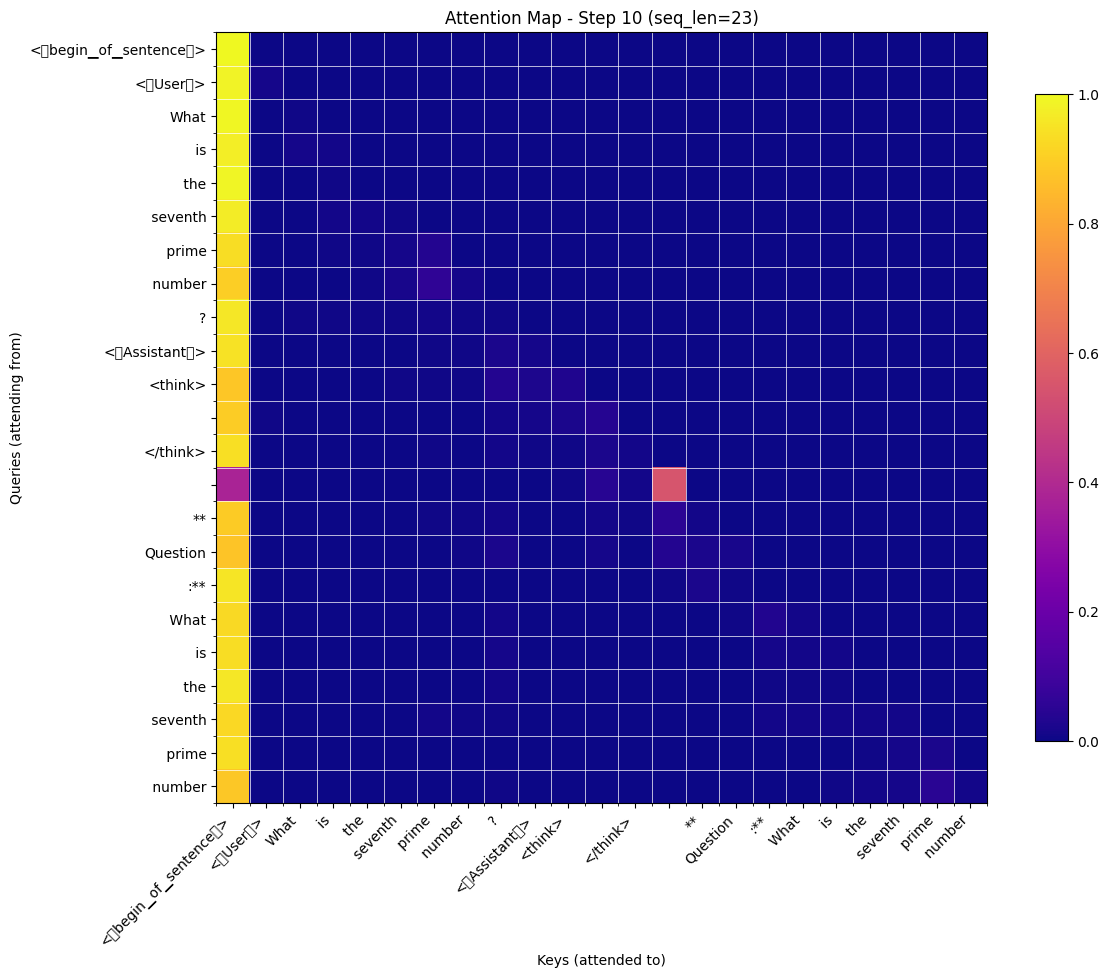

In [14]:

attention_maps = generate_and_return_attention(
    model=model,  # Your model
    prompt=answer_prompt,
    target_head=(2, 17),
    max_new_tokens=10,
    do_sample=True
)
    
plot_attention_maps(attention_maps)

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


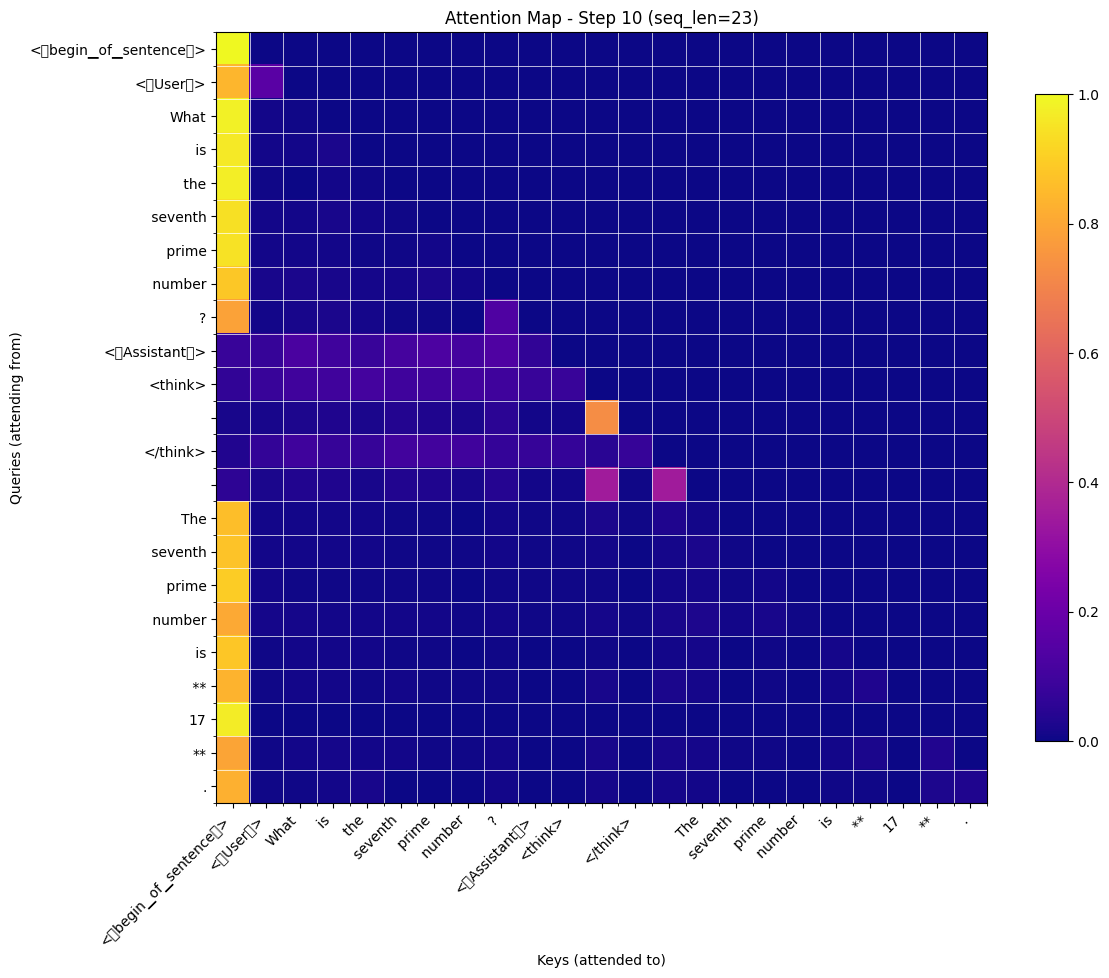

In [15]:
attention_maps = generate_and_return_attention(
    model=model,  # Your model
    prompt=answer_prompt,
    target_head=(0, 19),
    max_new_tokens=10,
    do_sample=True
)
    
plot_attention_maps(attention_maps)

Plotting attention matrix shape: (21, 21)
Sequence length: 21
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', 'I', ' need', ' to', ' identify', ' the', ' seventh', ' prime', ' number', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


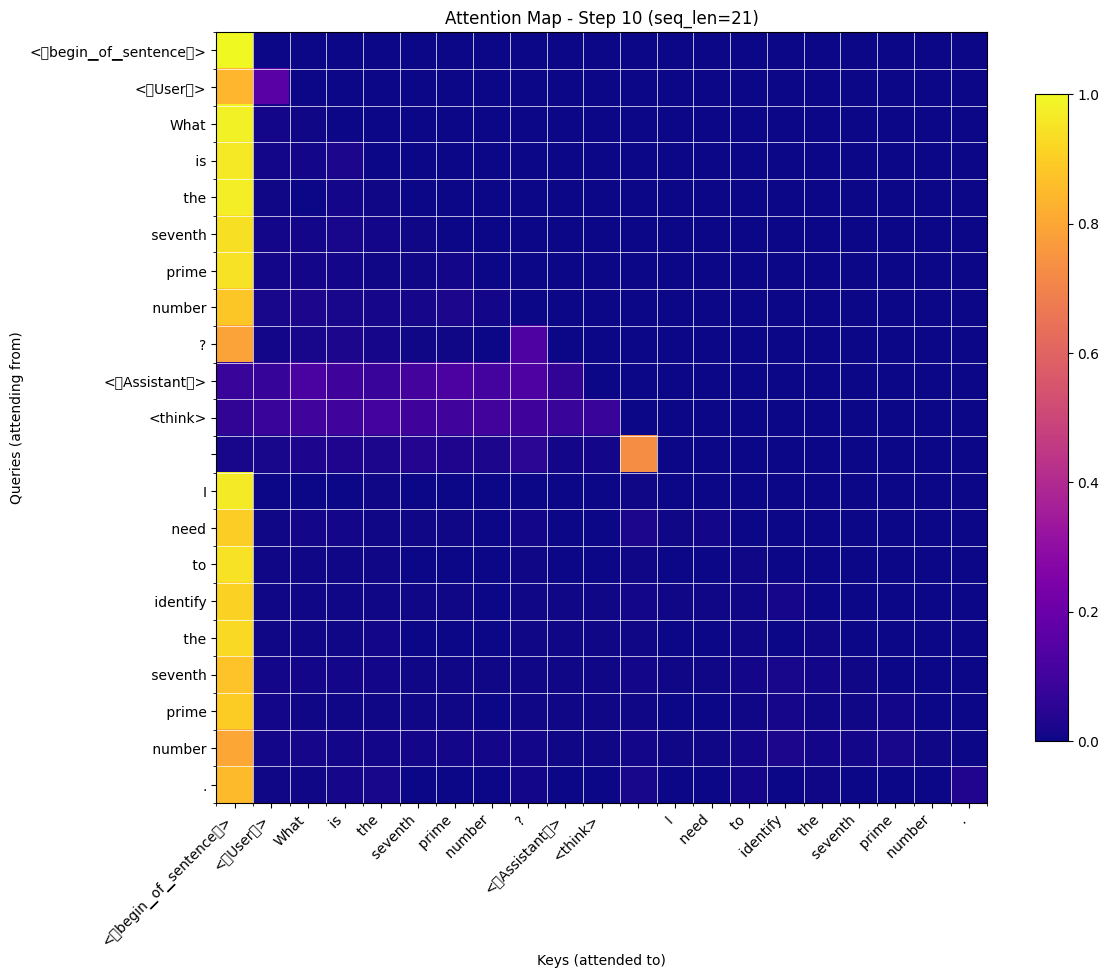

In [16]:
attention_maps = generate_and_return_attention(
    model=model,  # Your model
    prompt=reasoning_prompt,
    target_head=(0, 19),
    max_new_tokens=10,
    do_sample=True
)
    
plot_attention_maps(attention_maps)

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


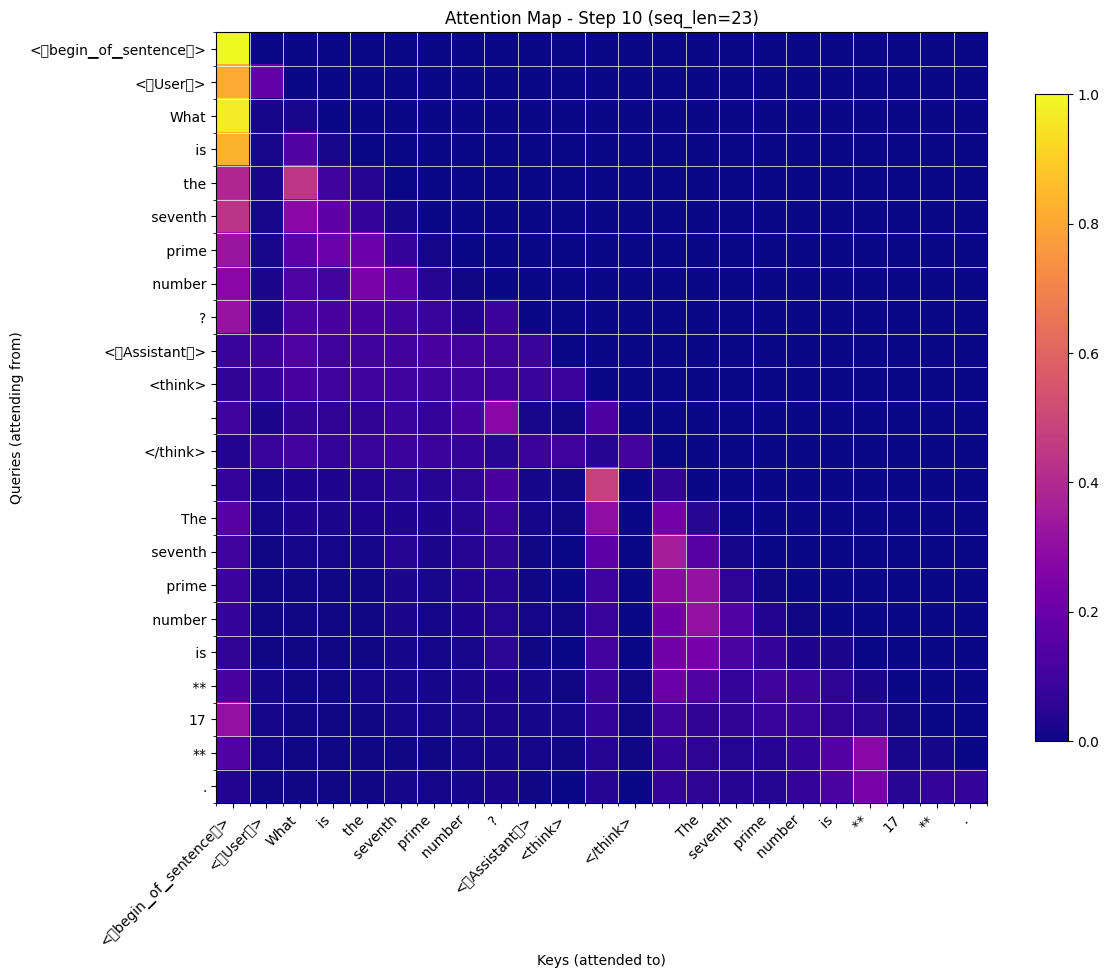

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


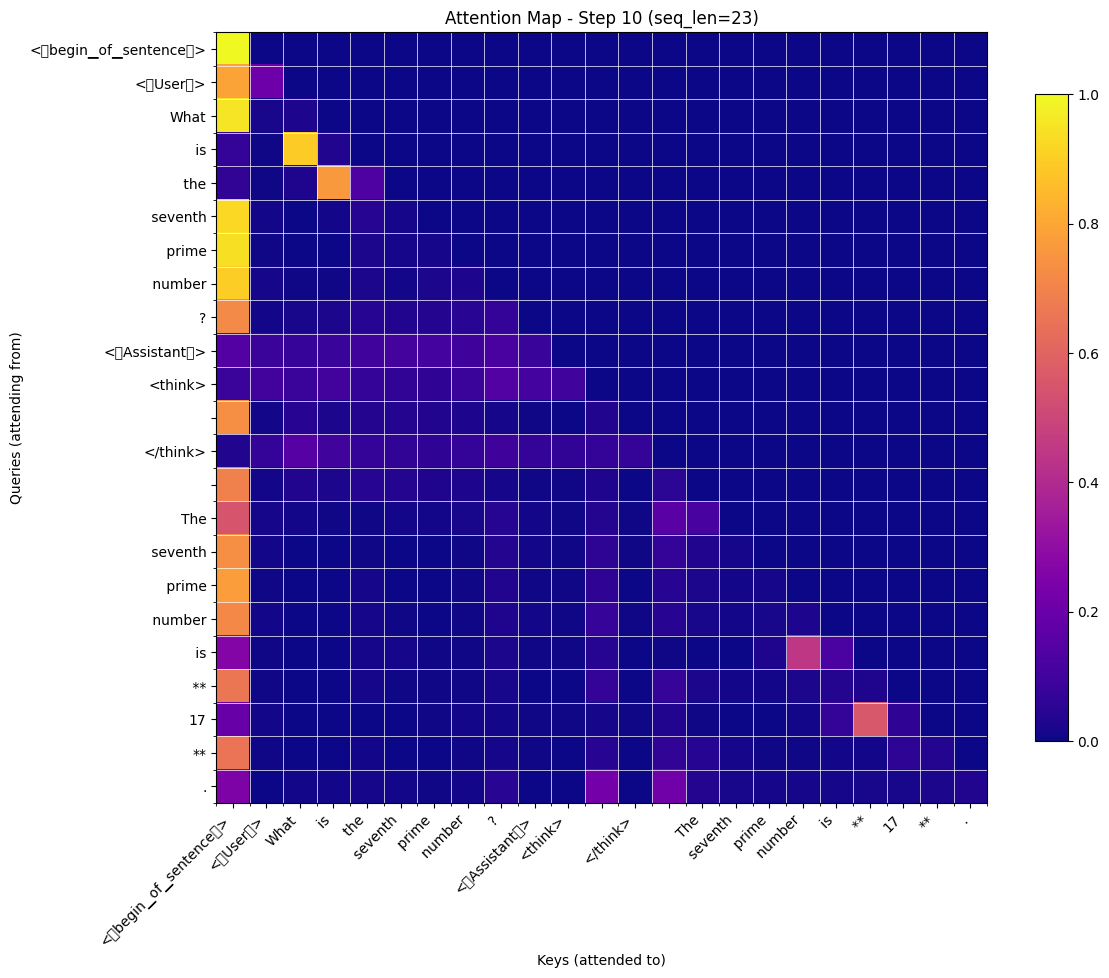

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


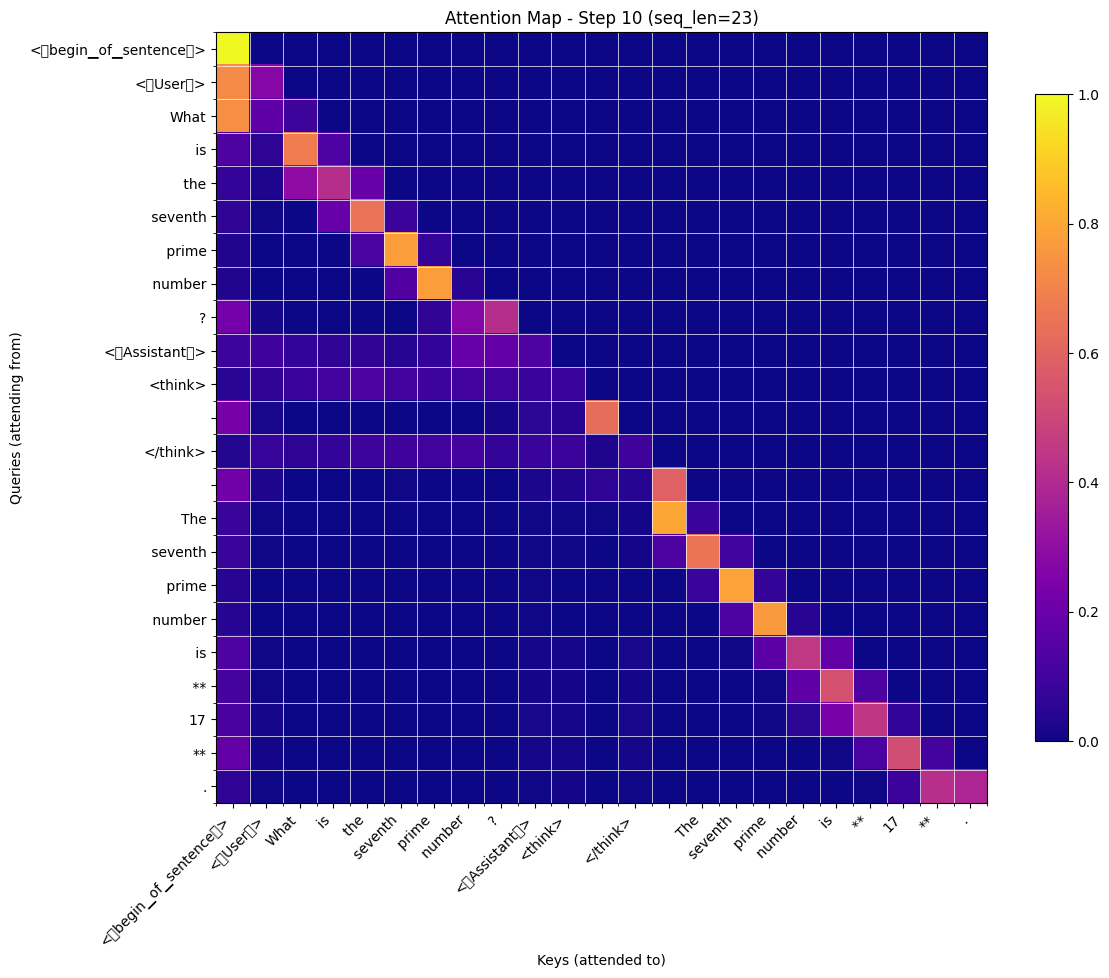

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


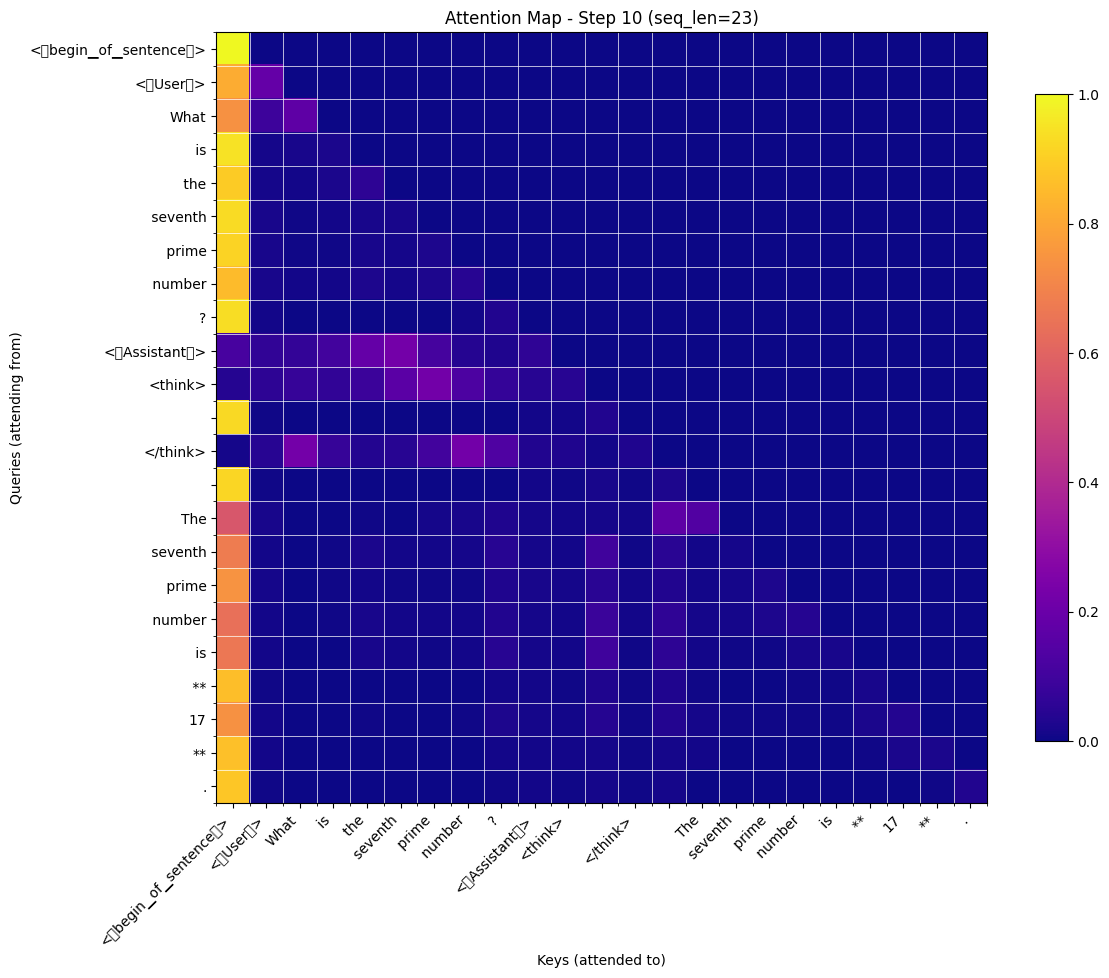

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


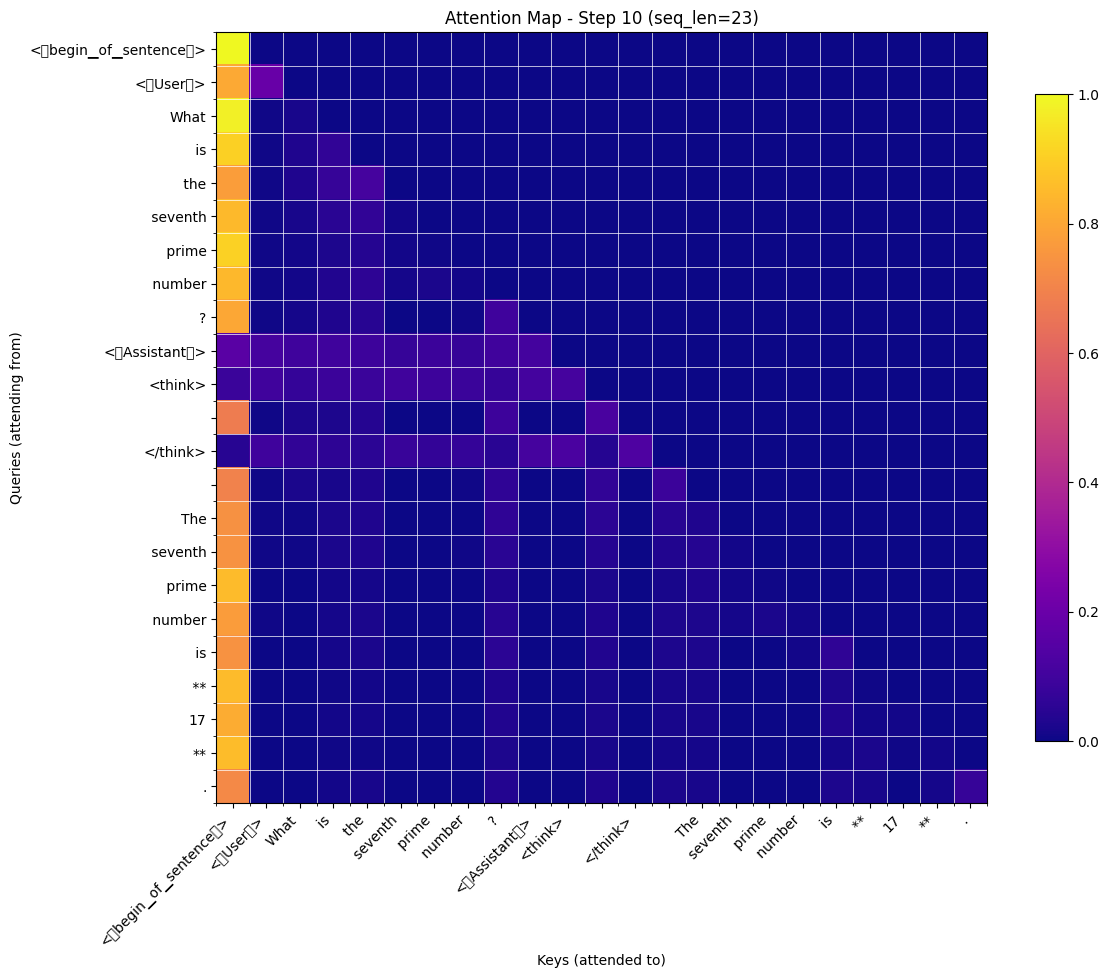

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


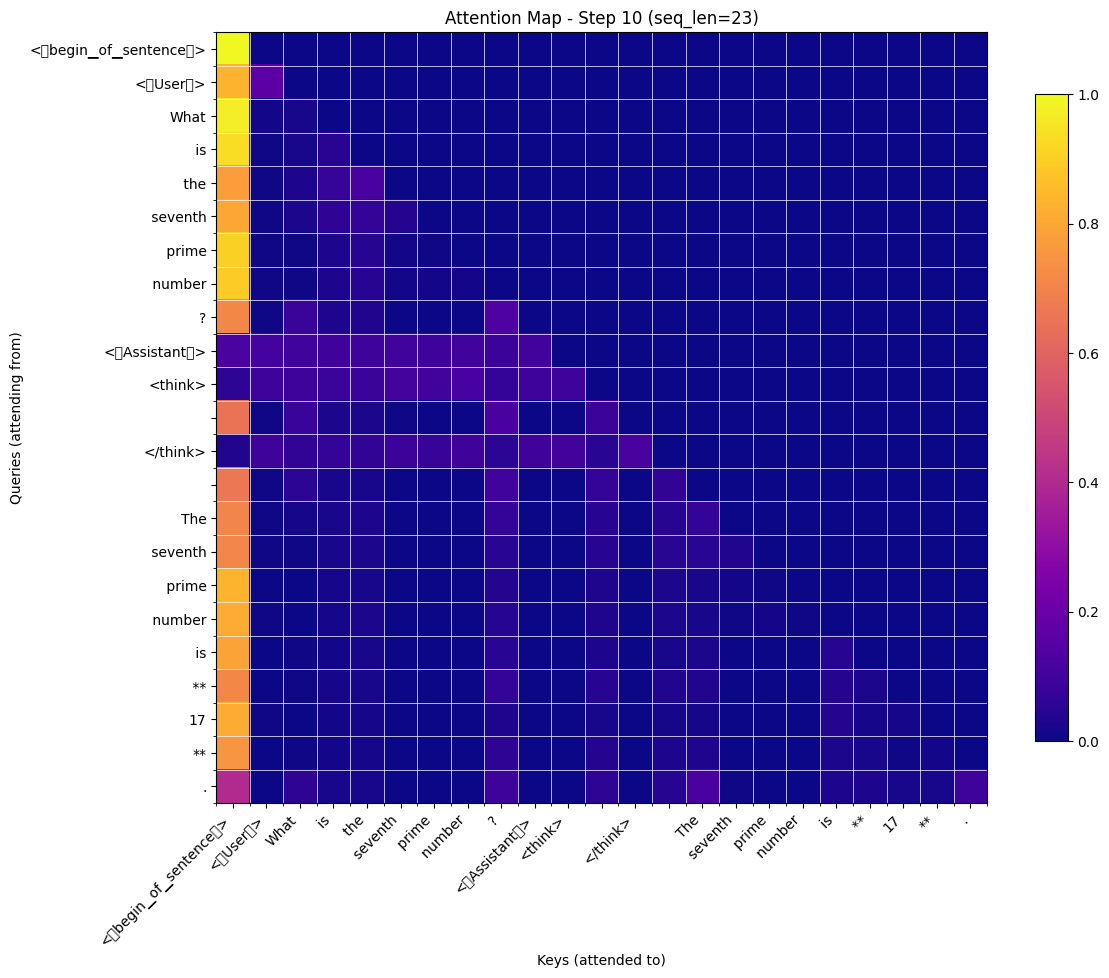

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


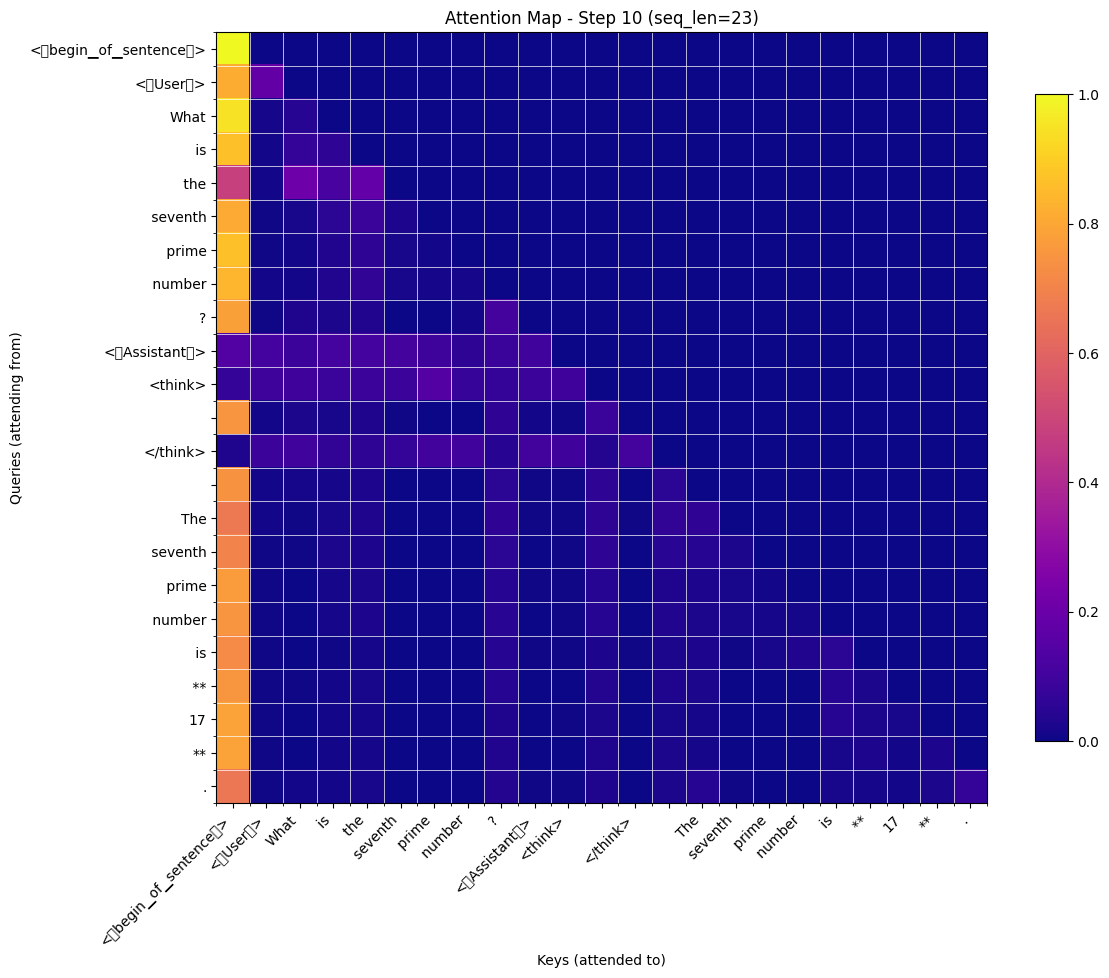

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


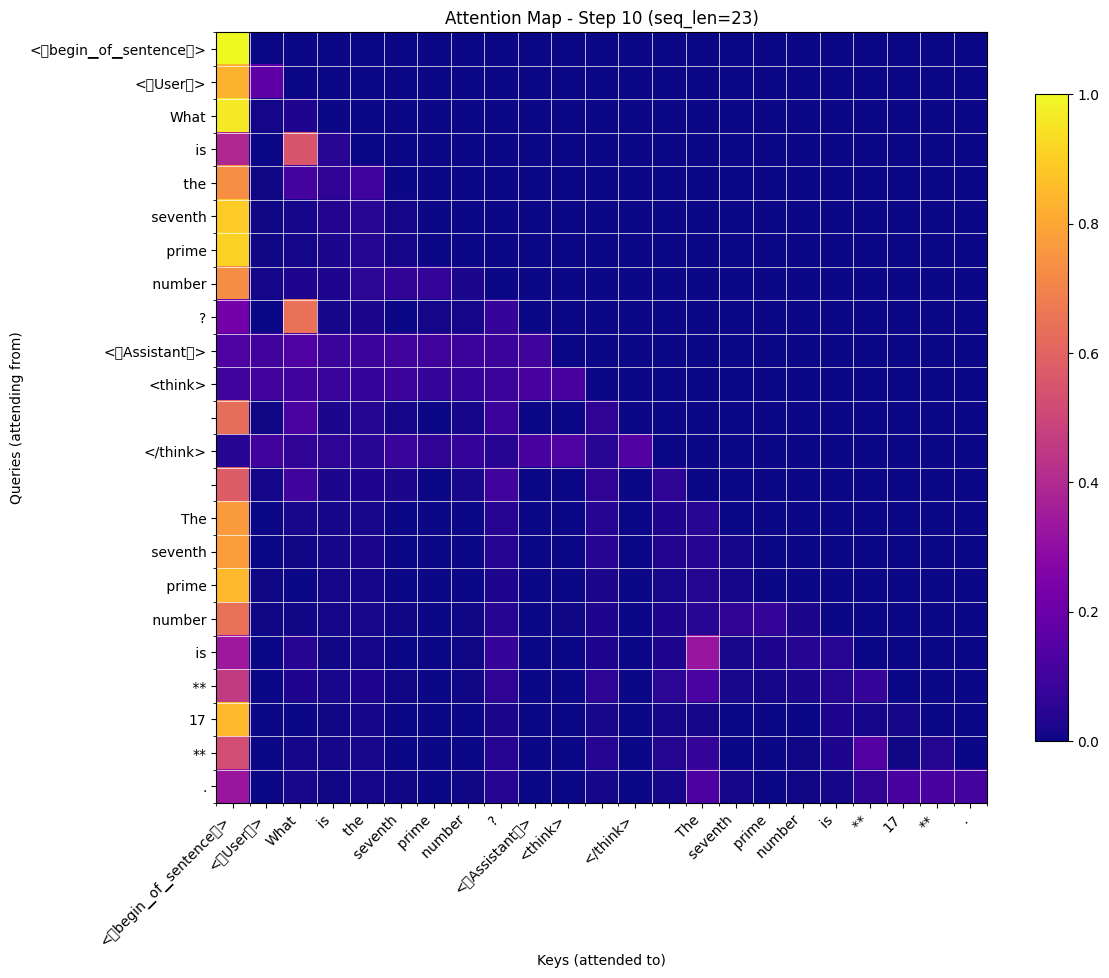

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


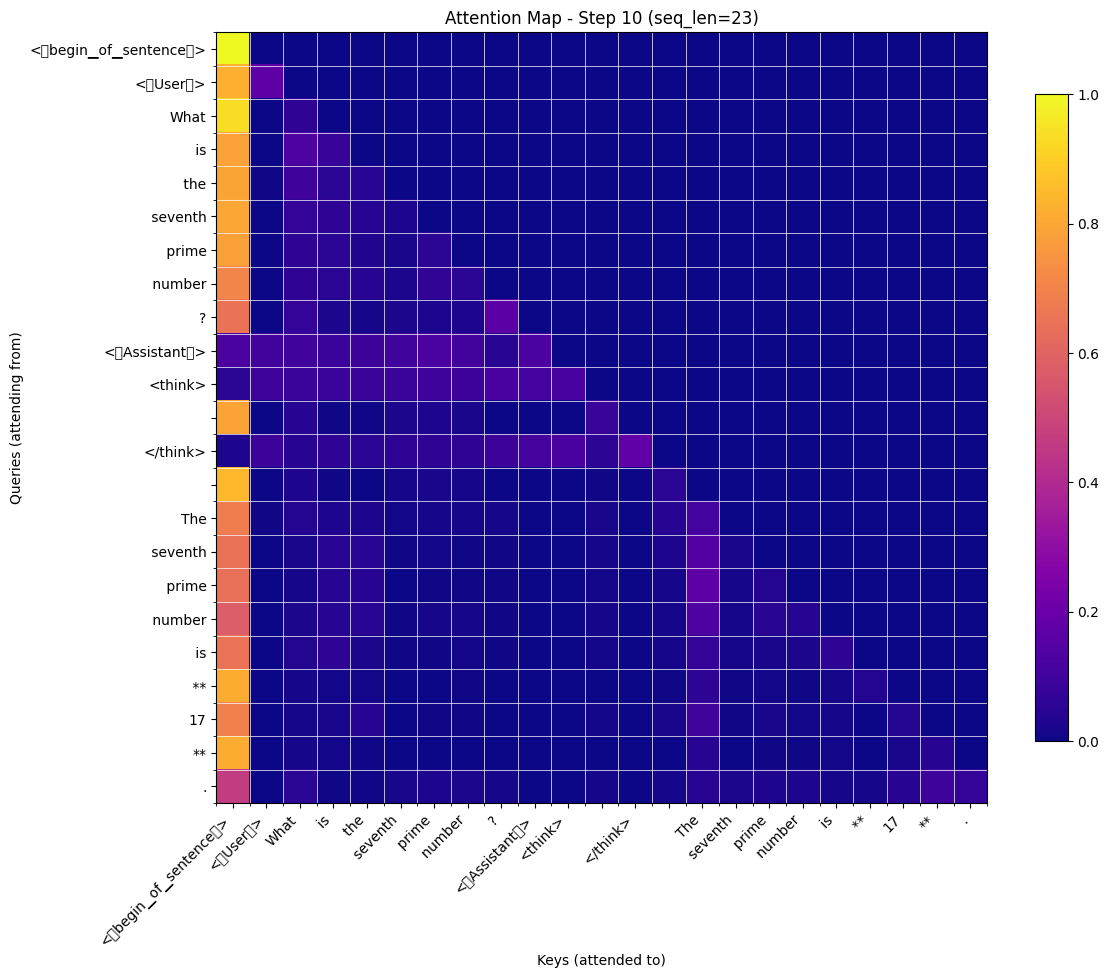

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


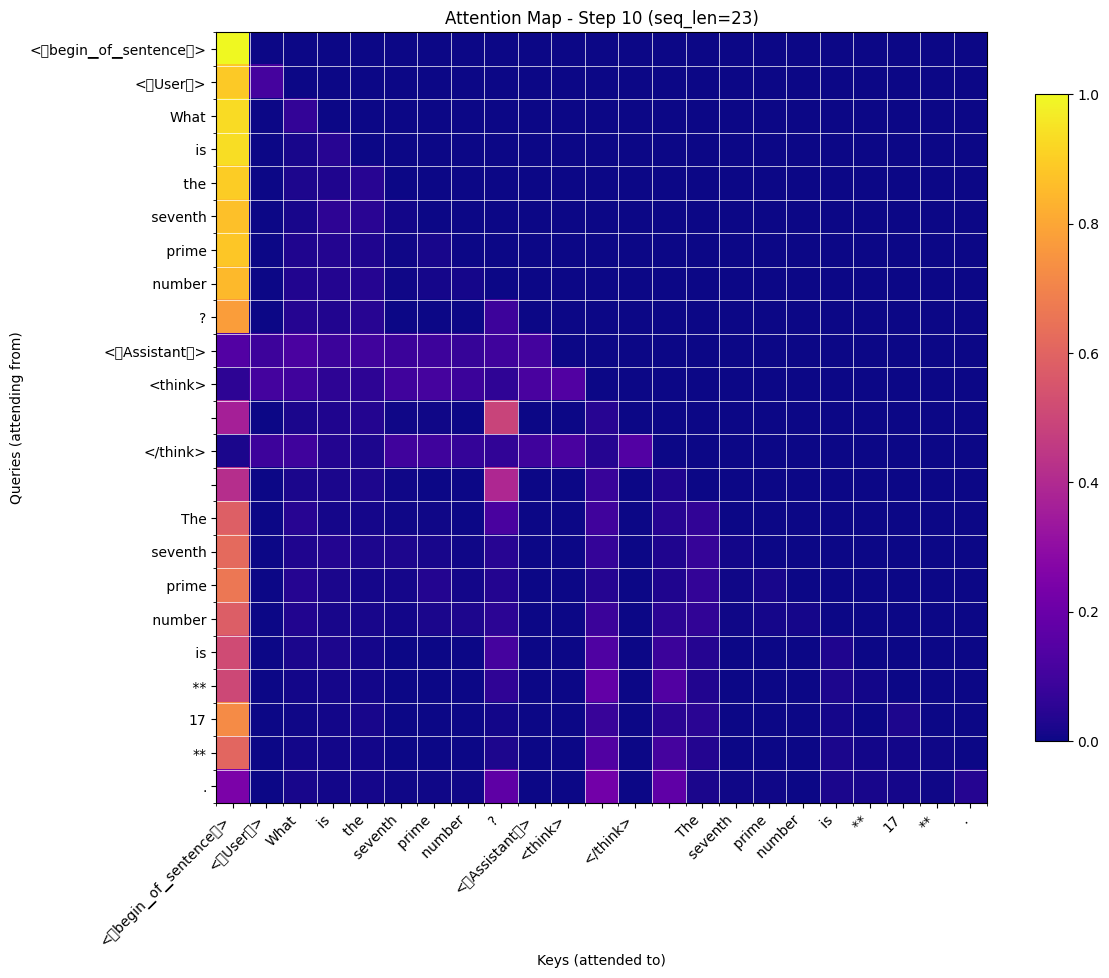

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


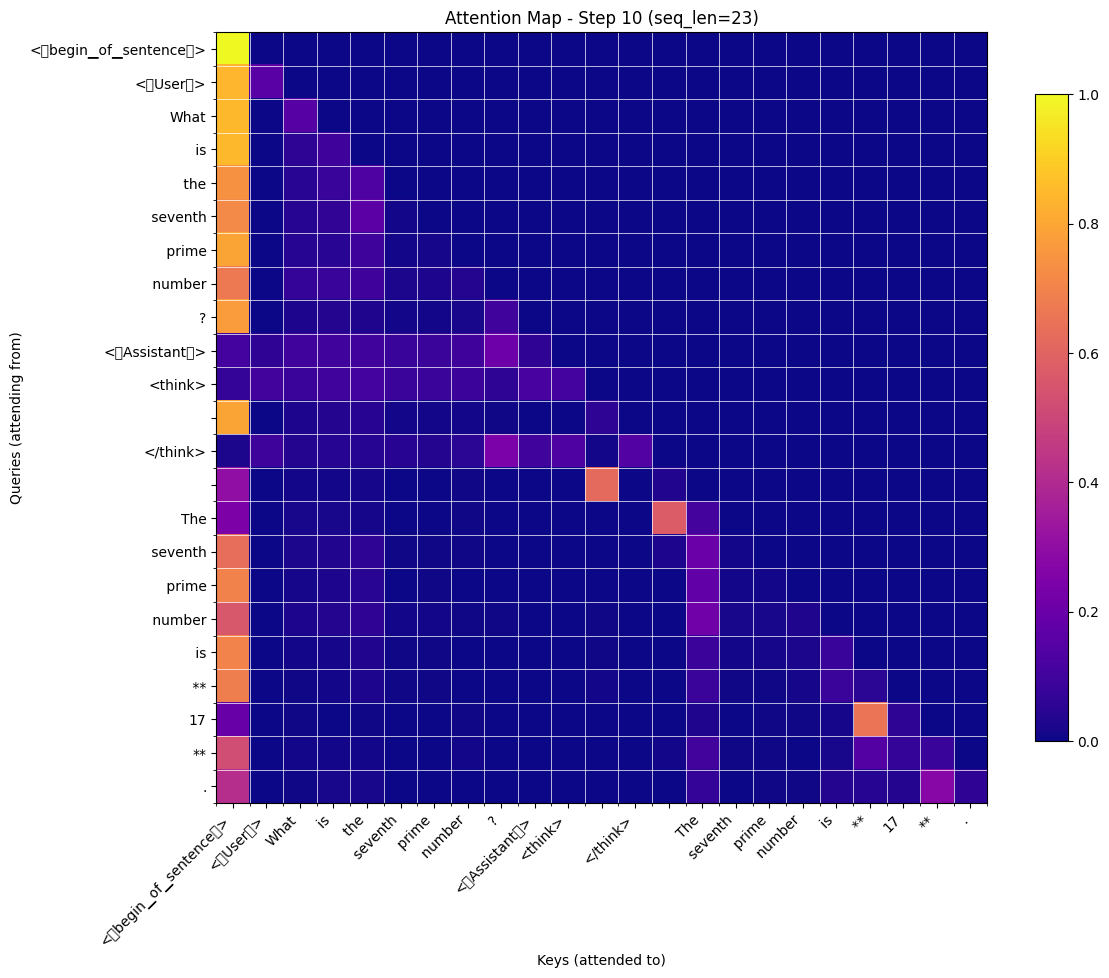

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


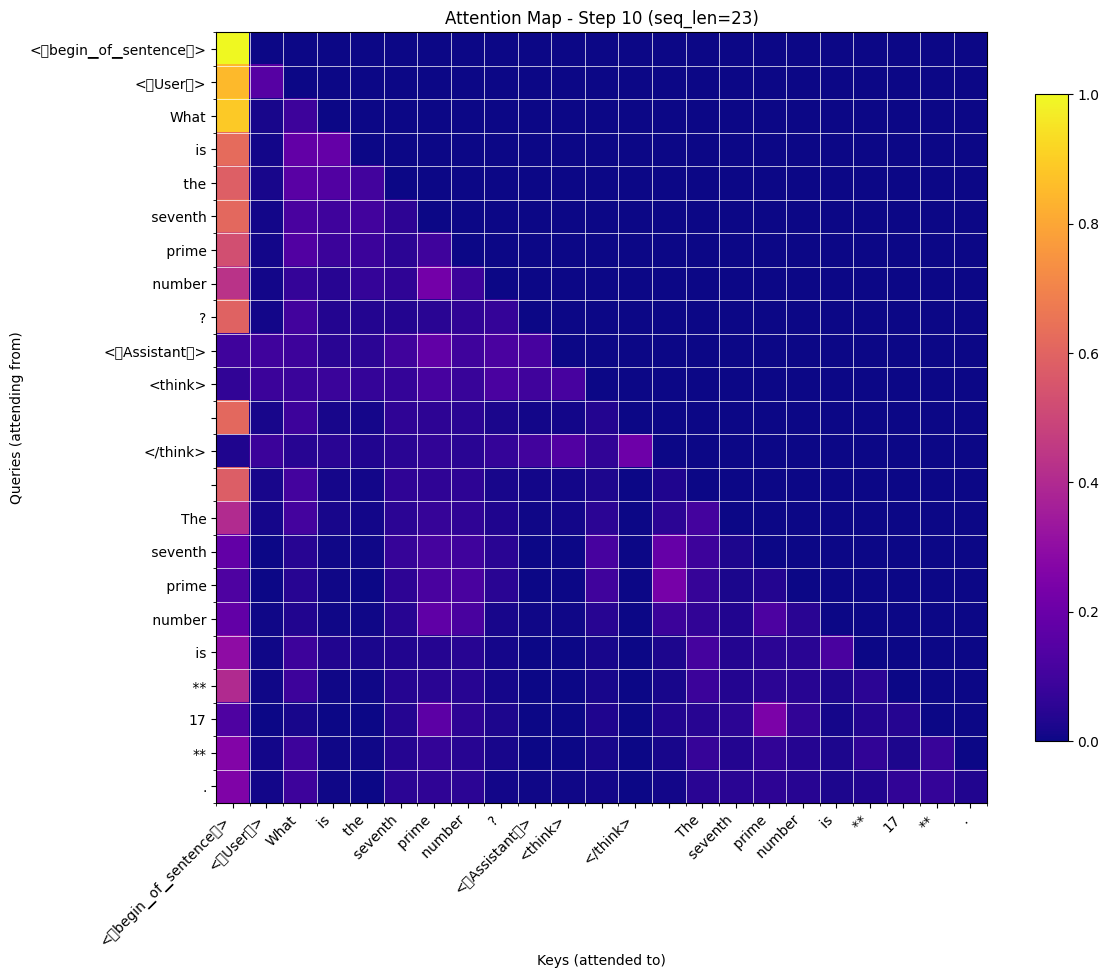

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


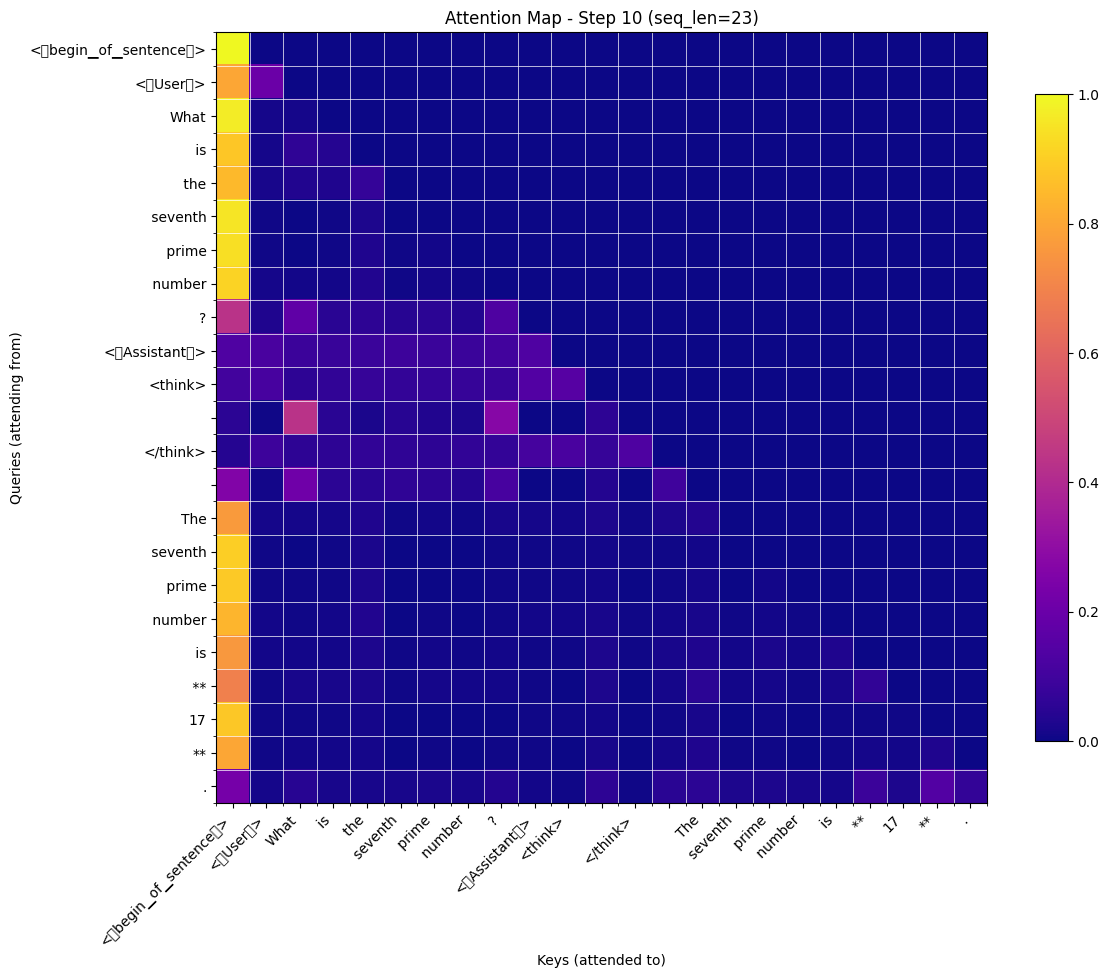

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


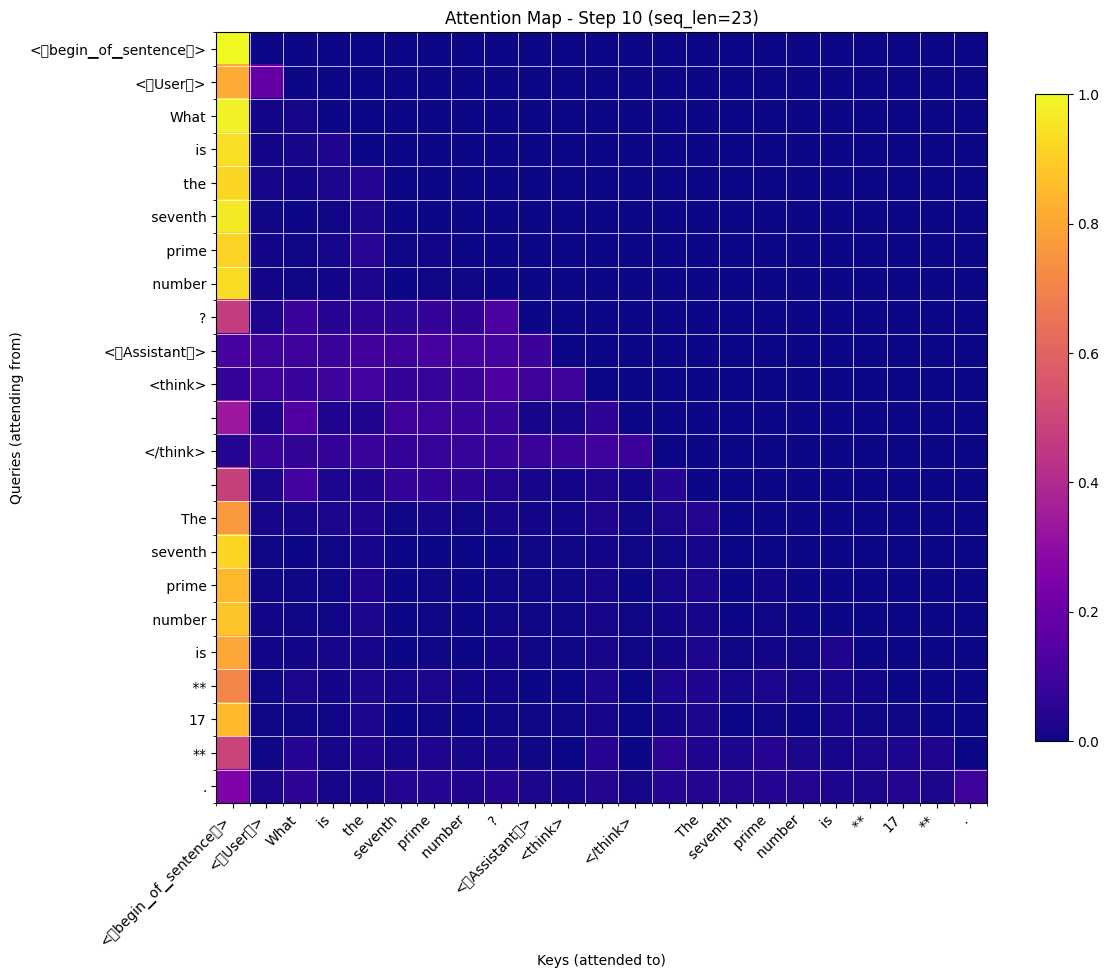

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


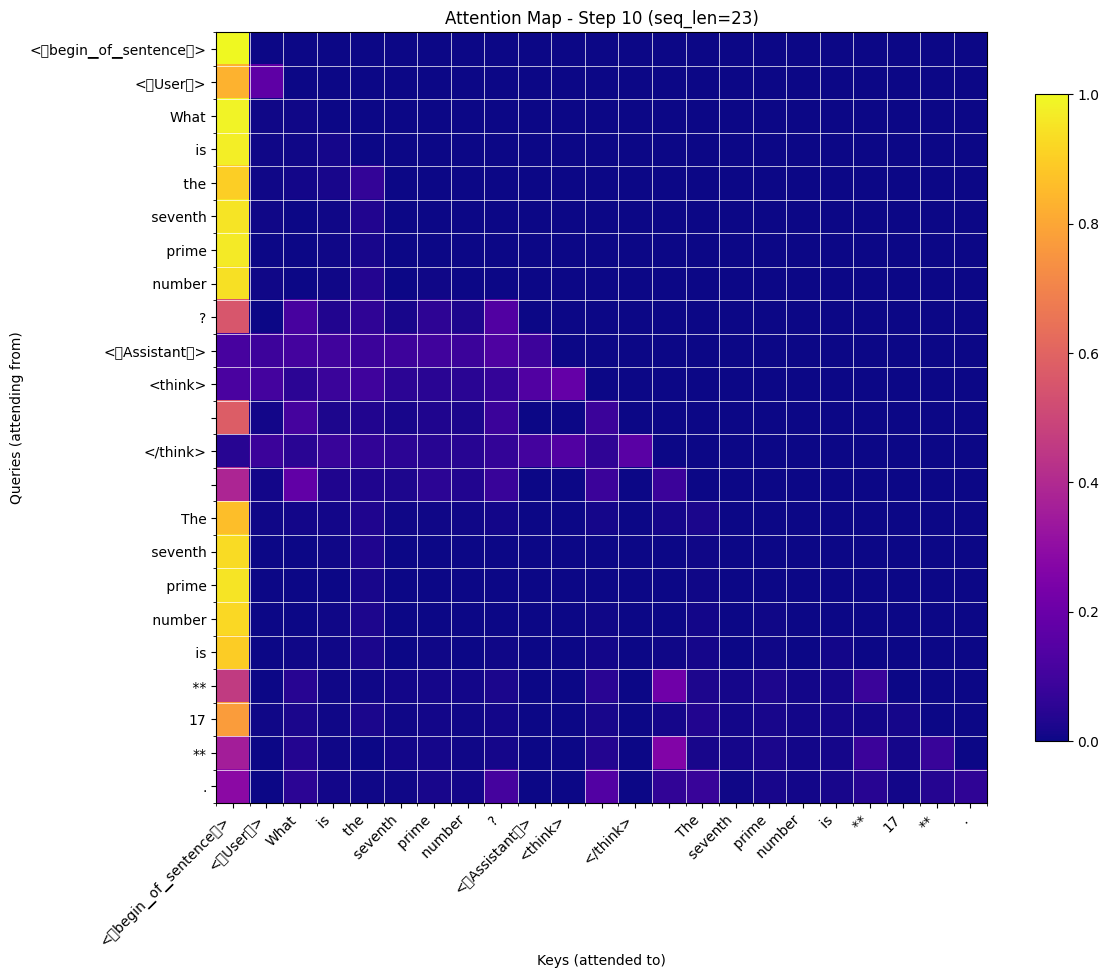

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


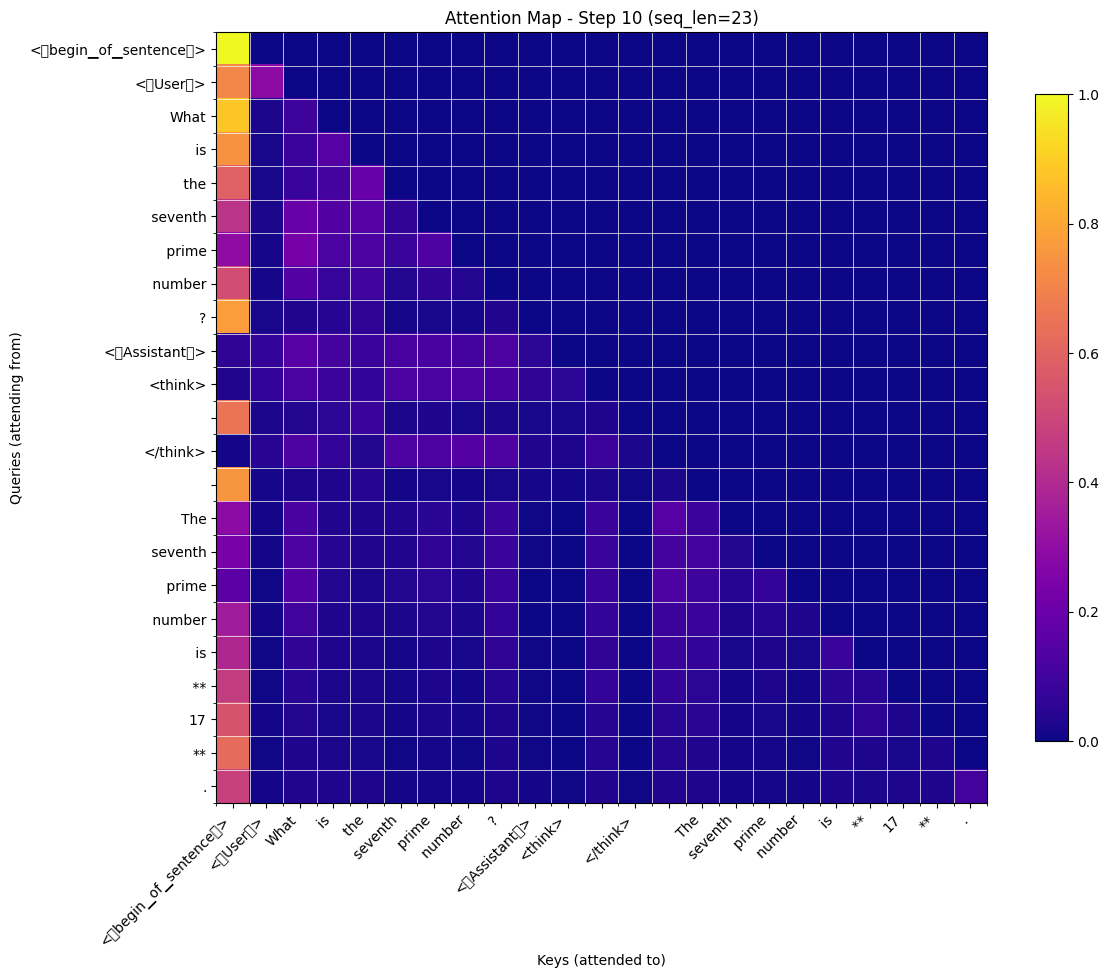

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


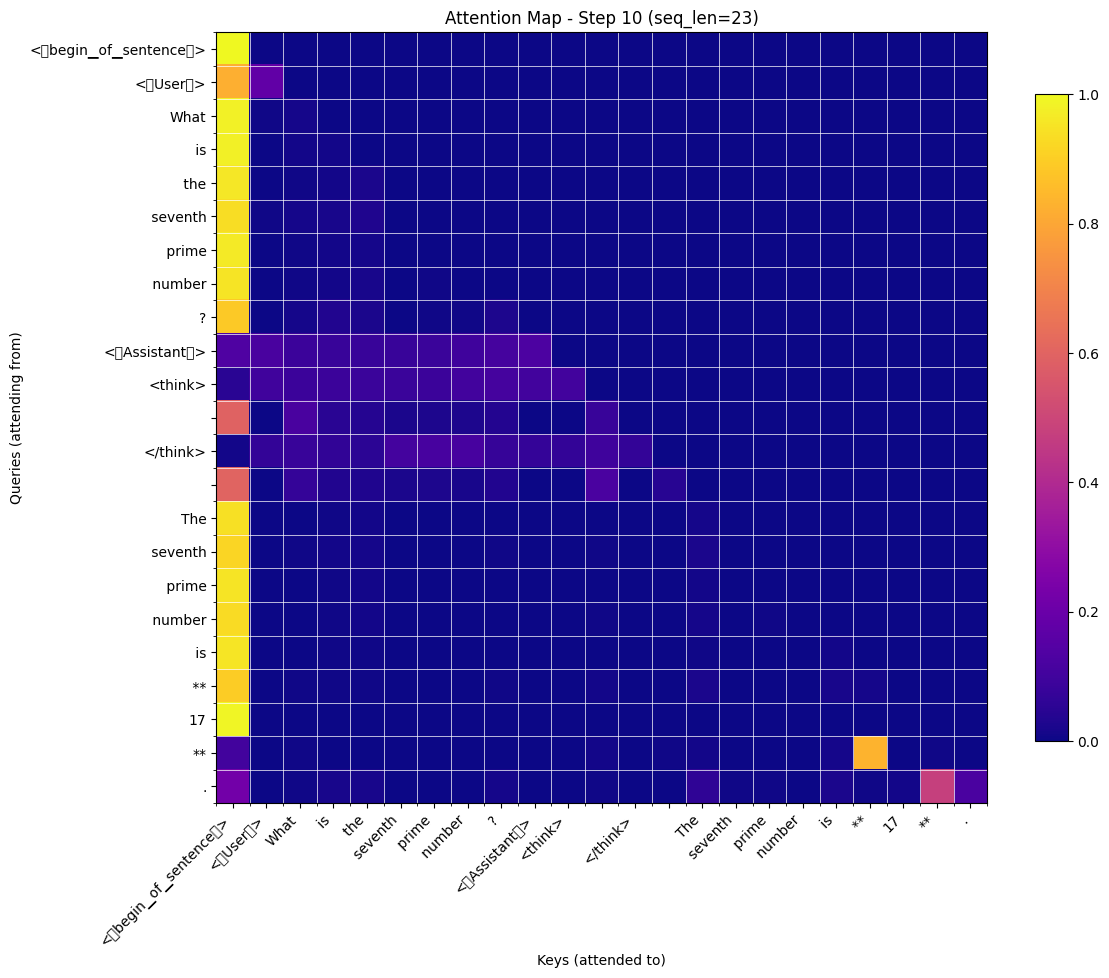

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


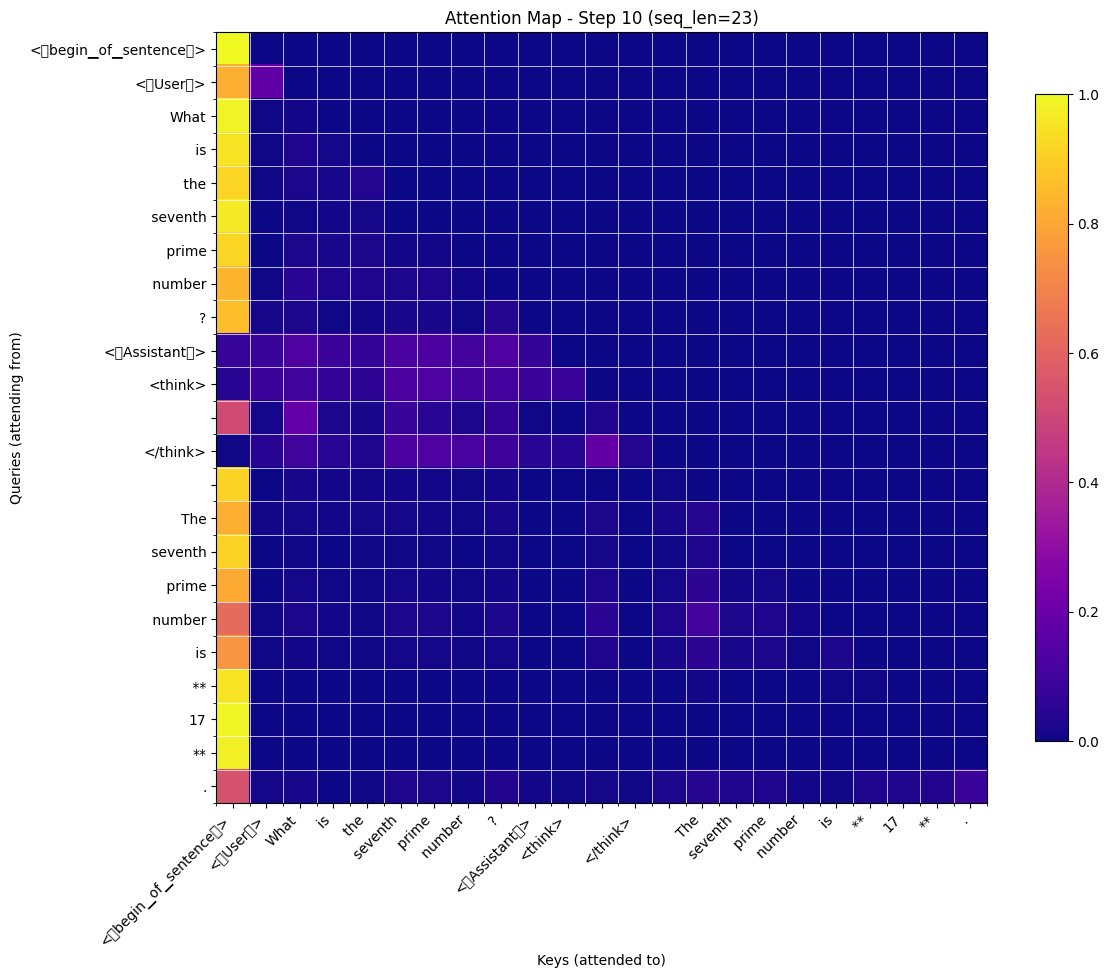

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


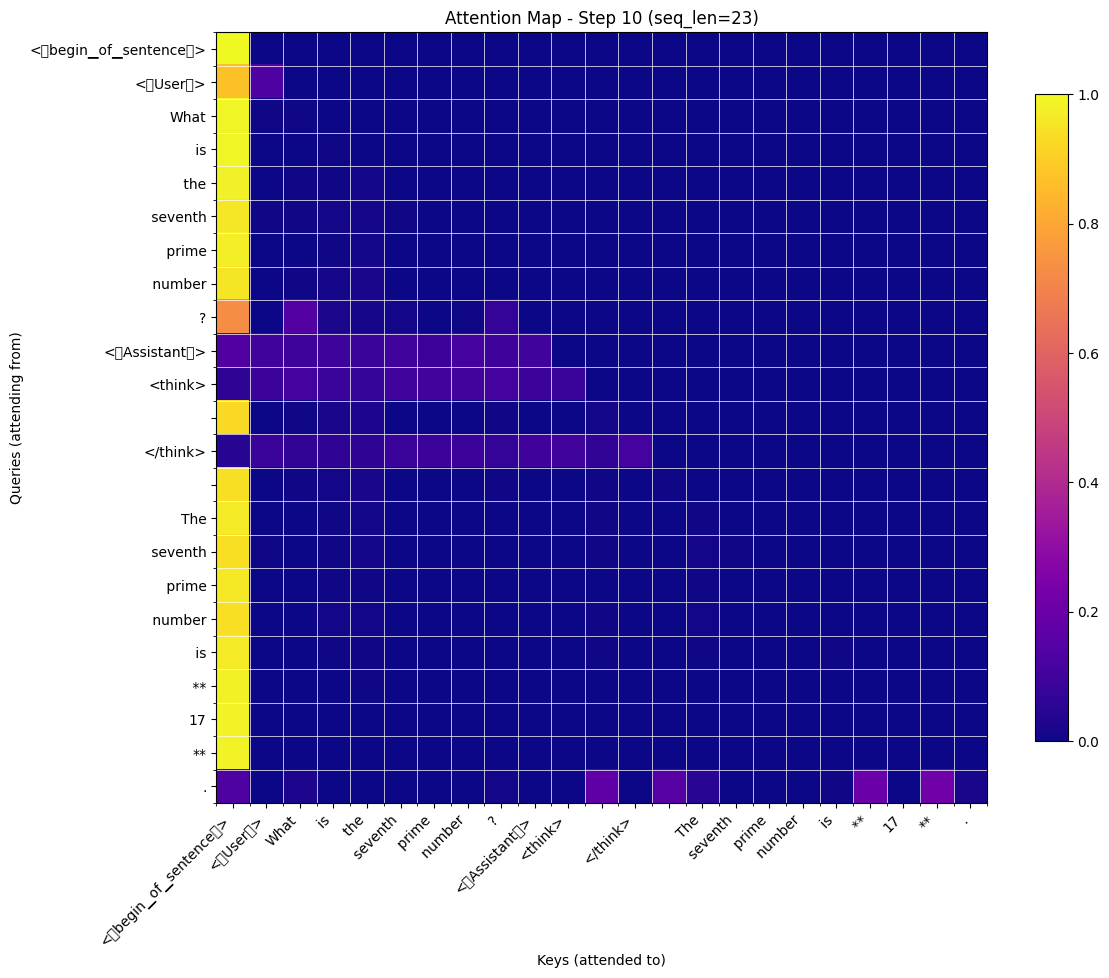

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


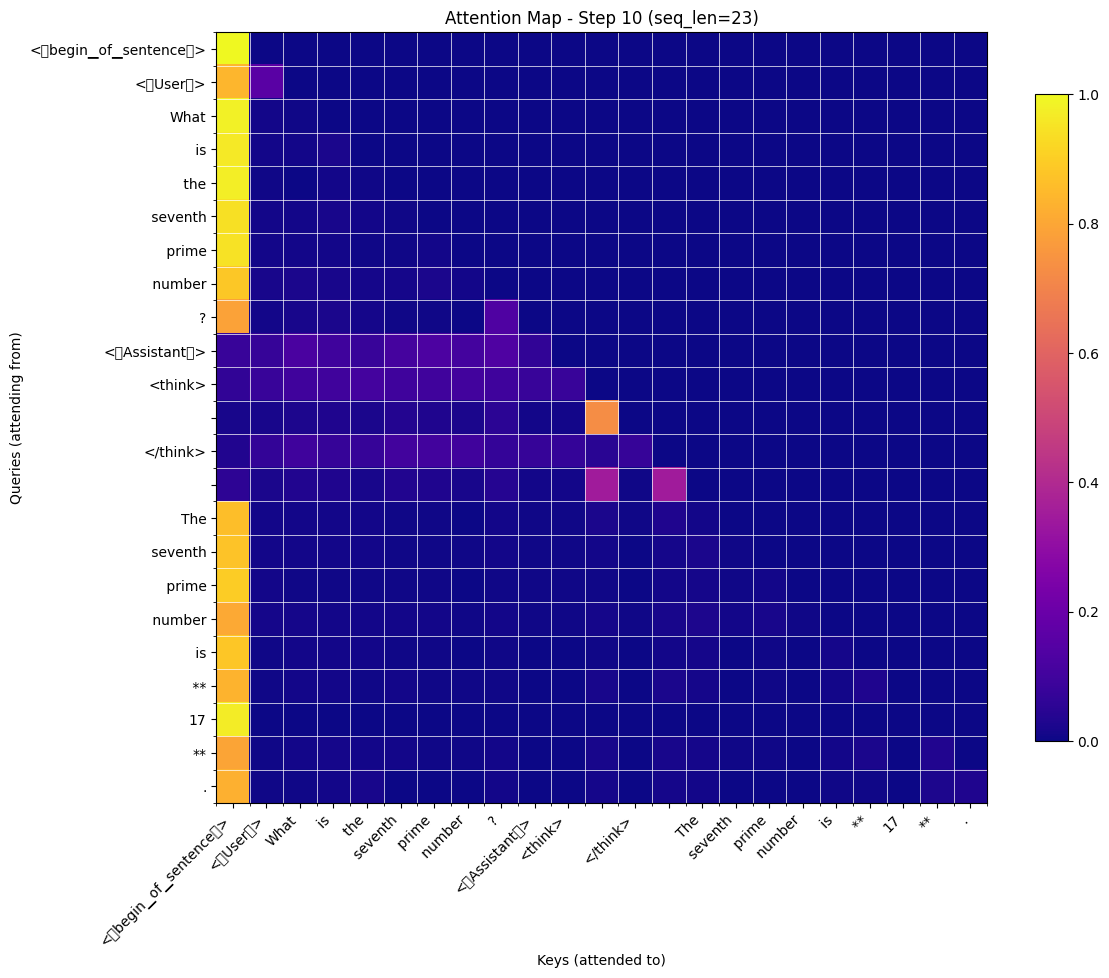

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


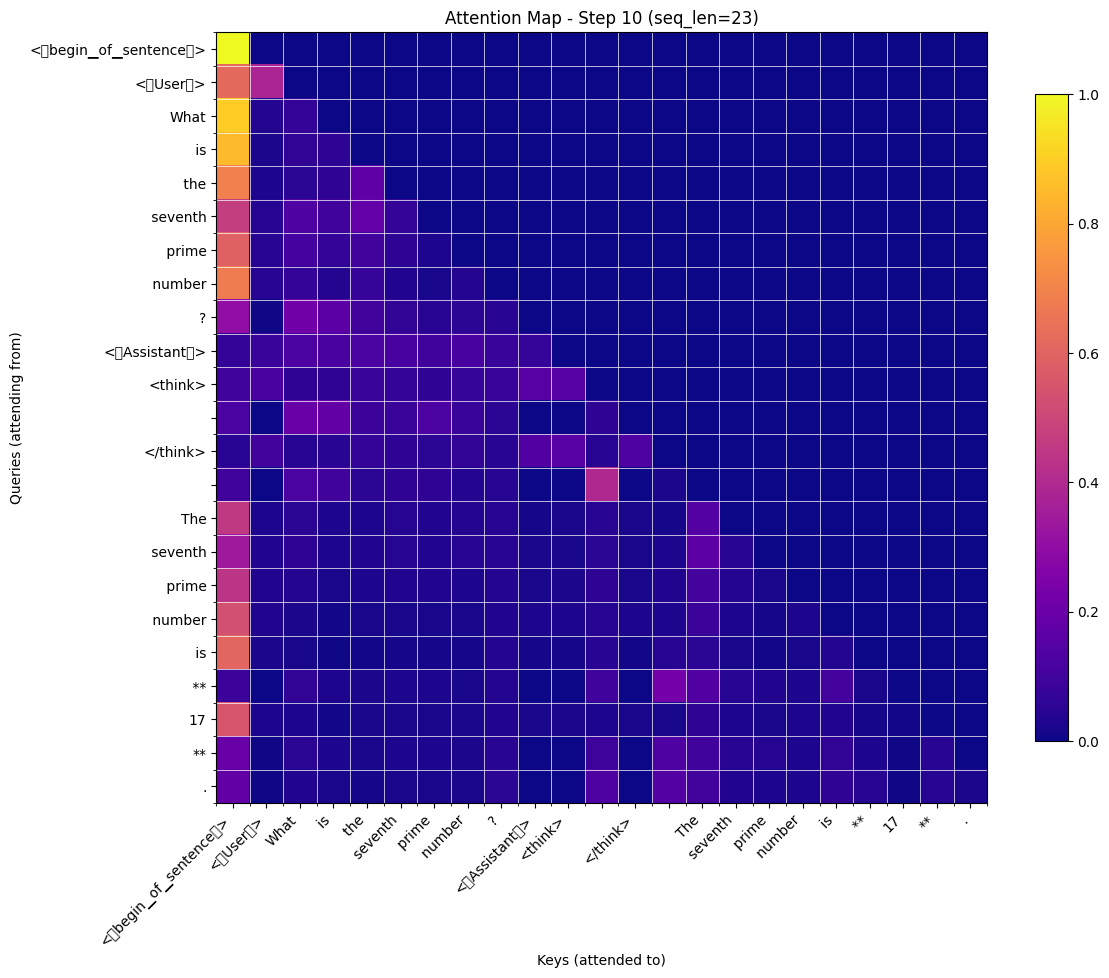

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


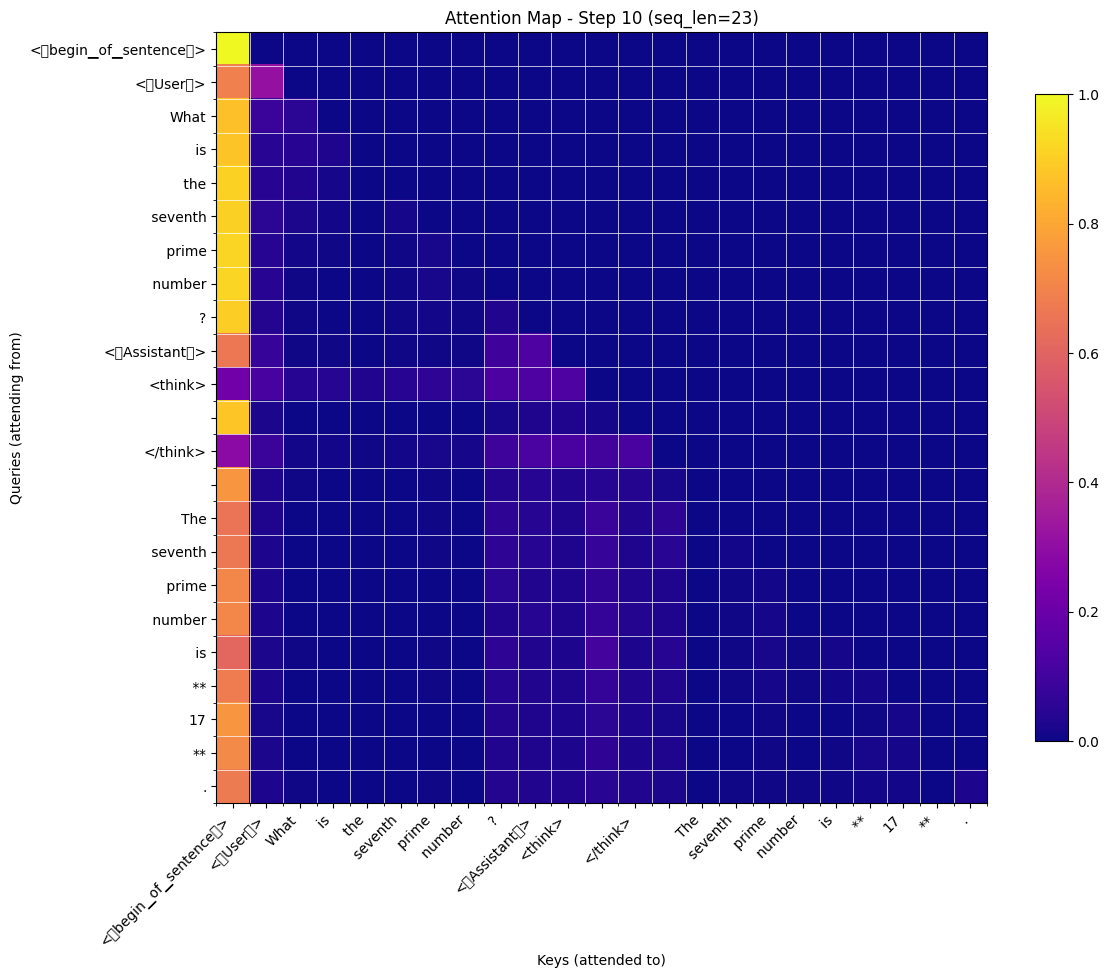

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


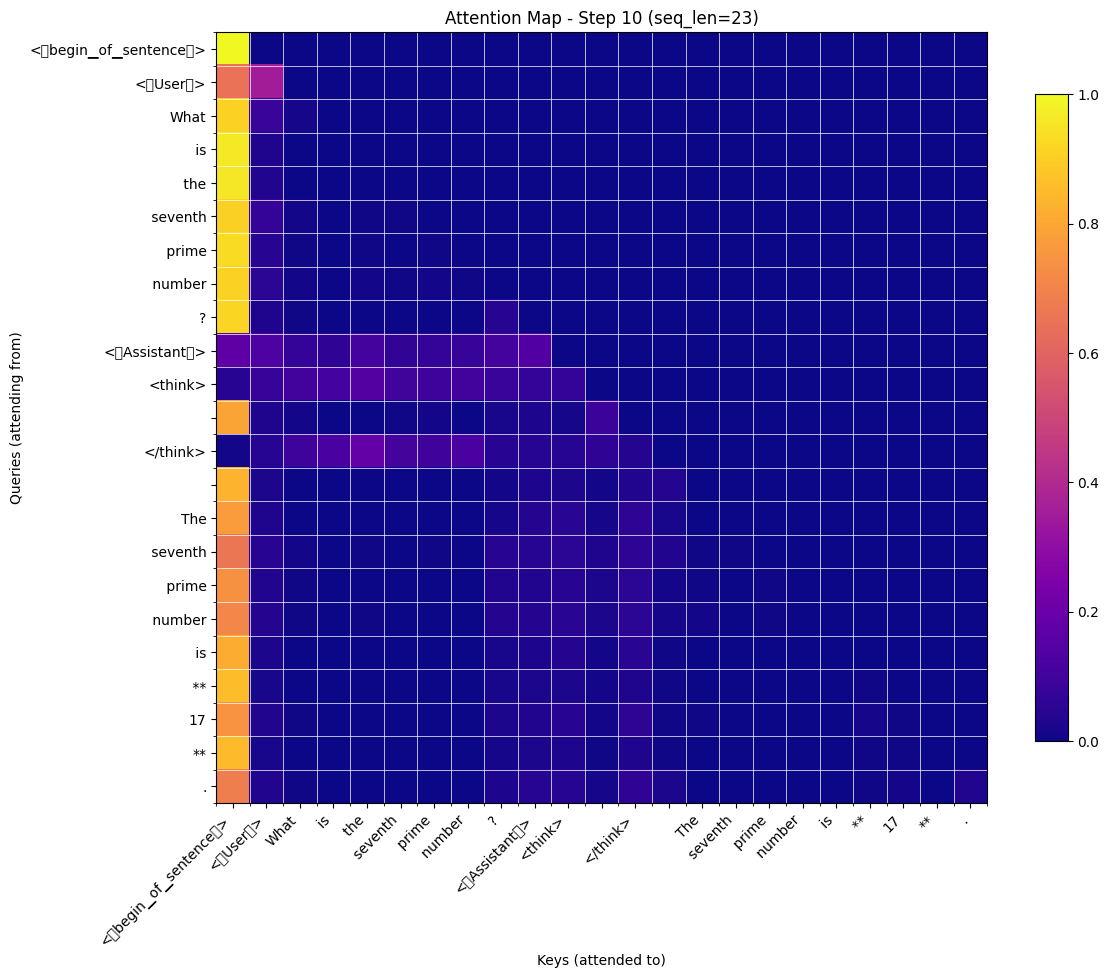

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


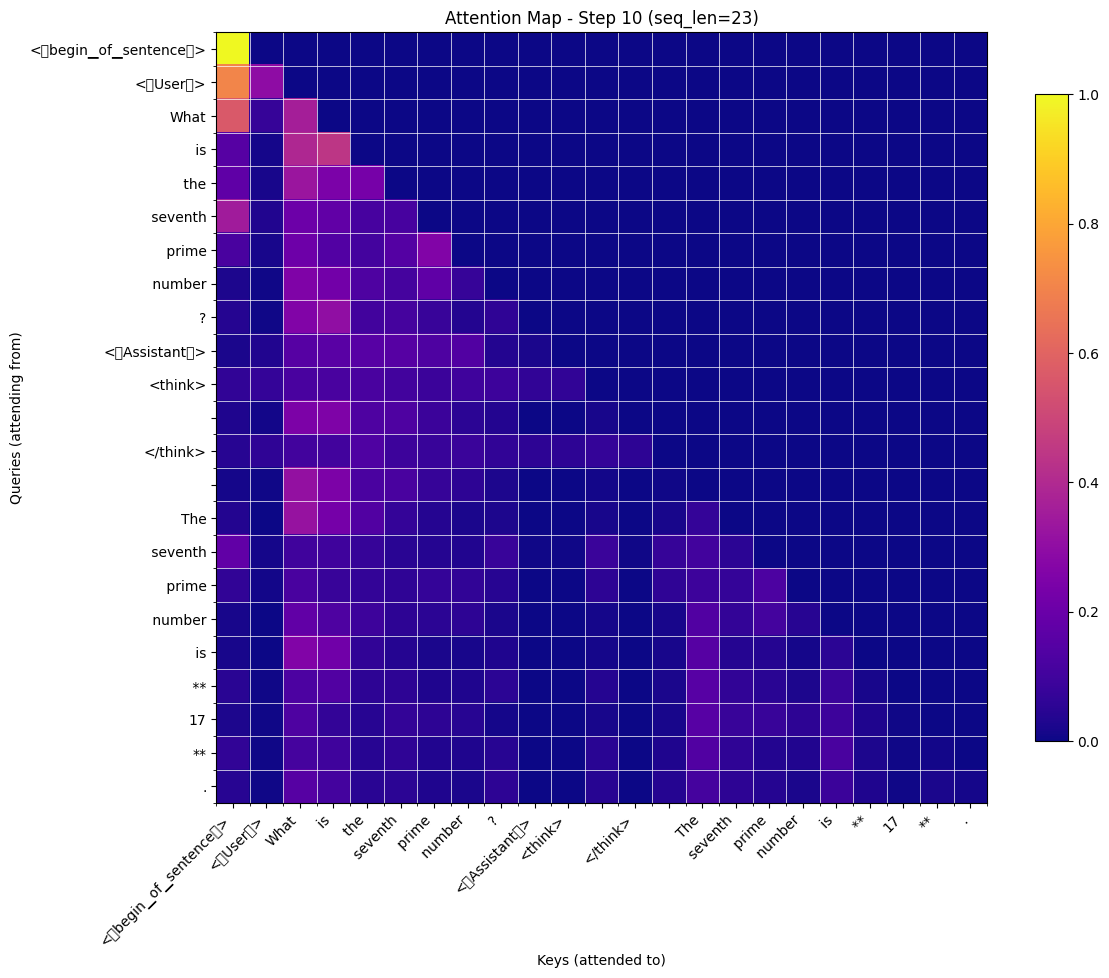

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


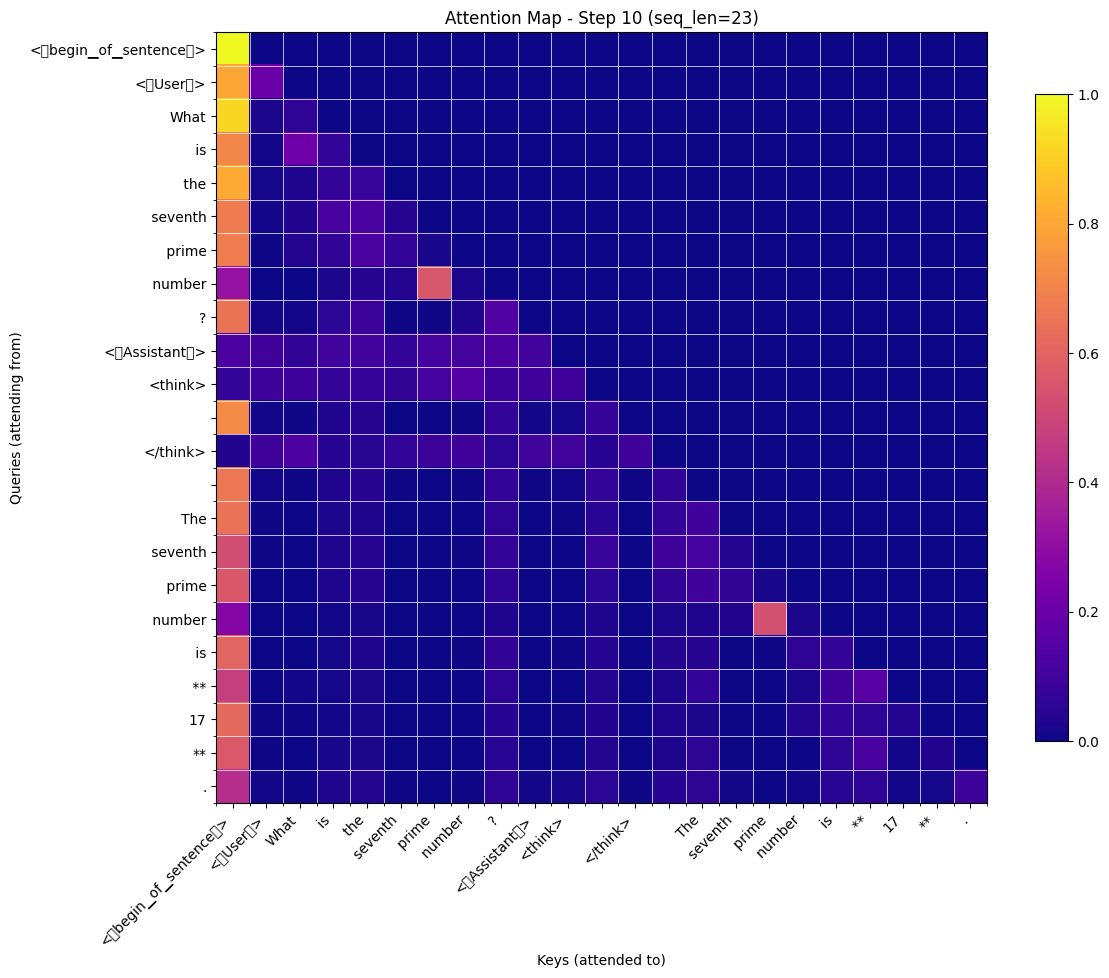

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


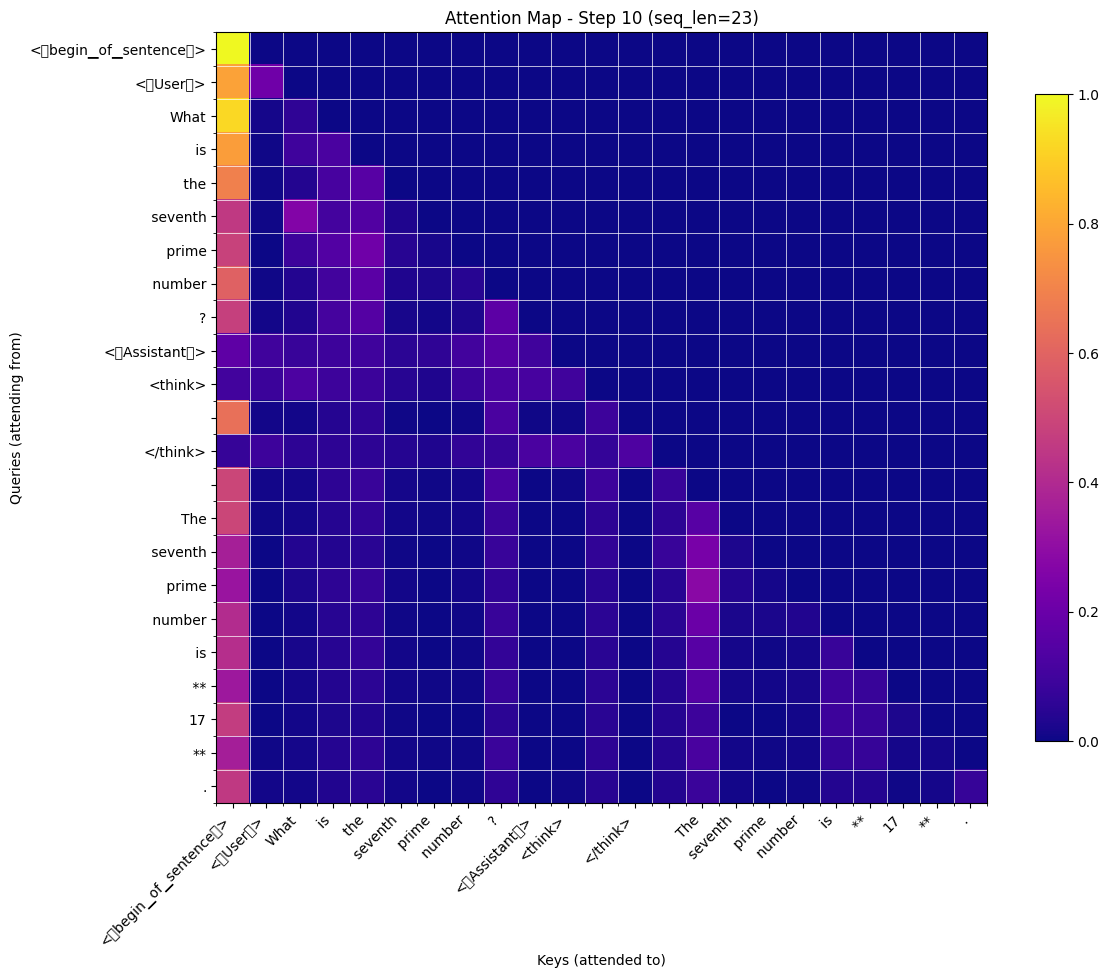

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


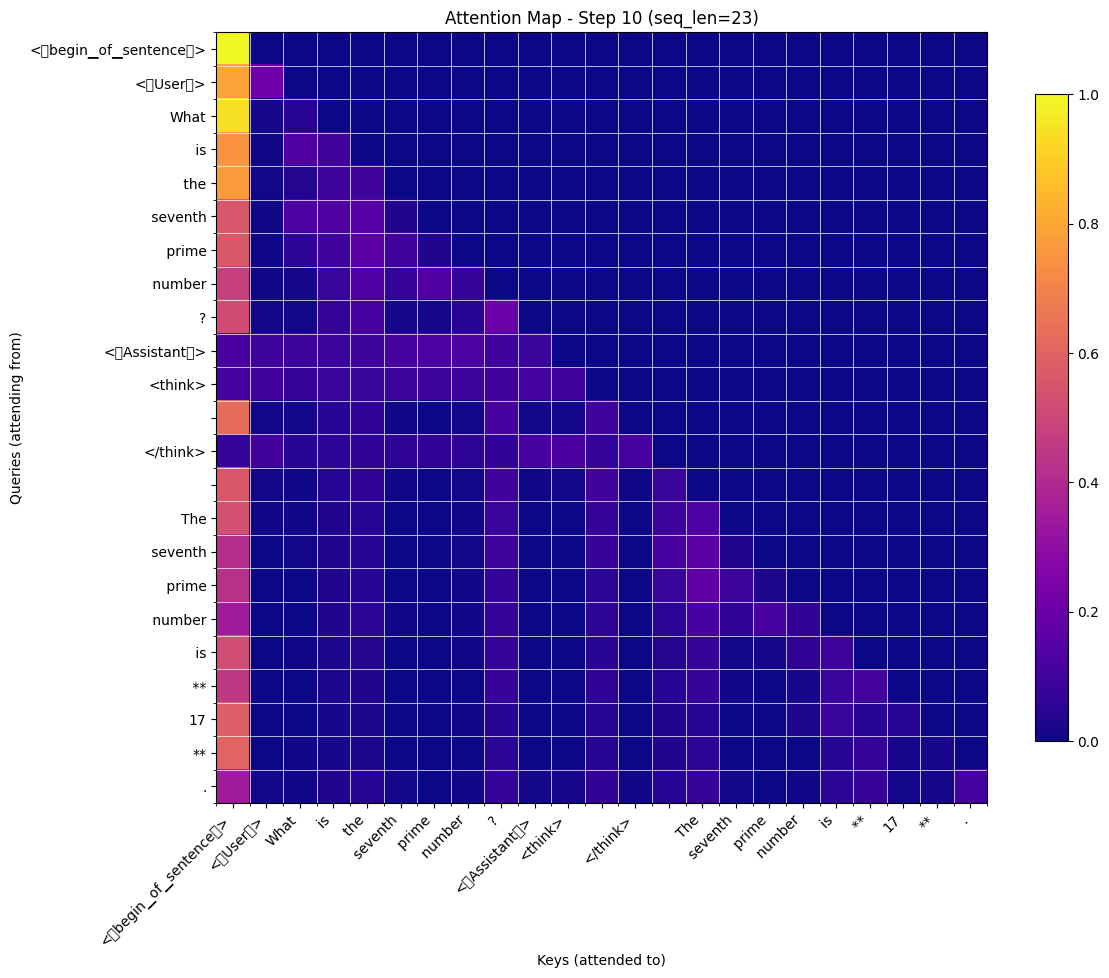

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


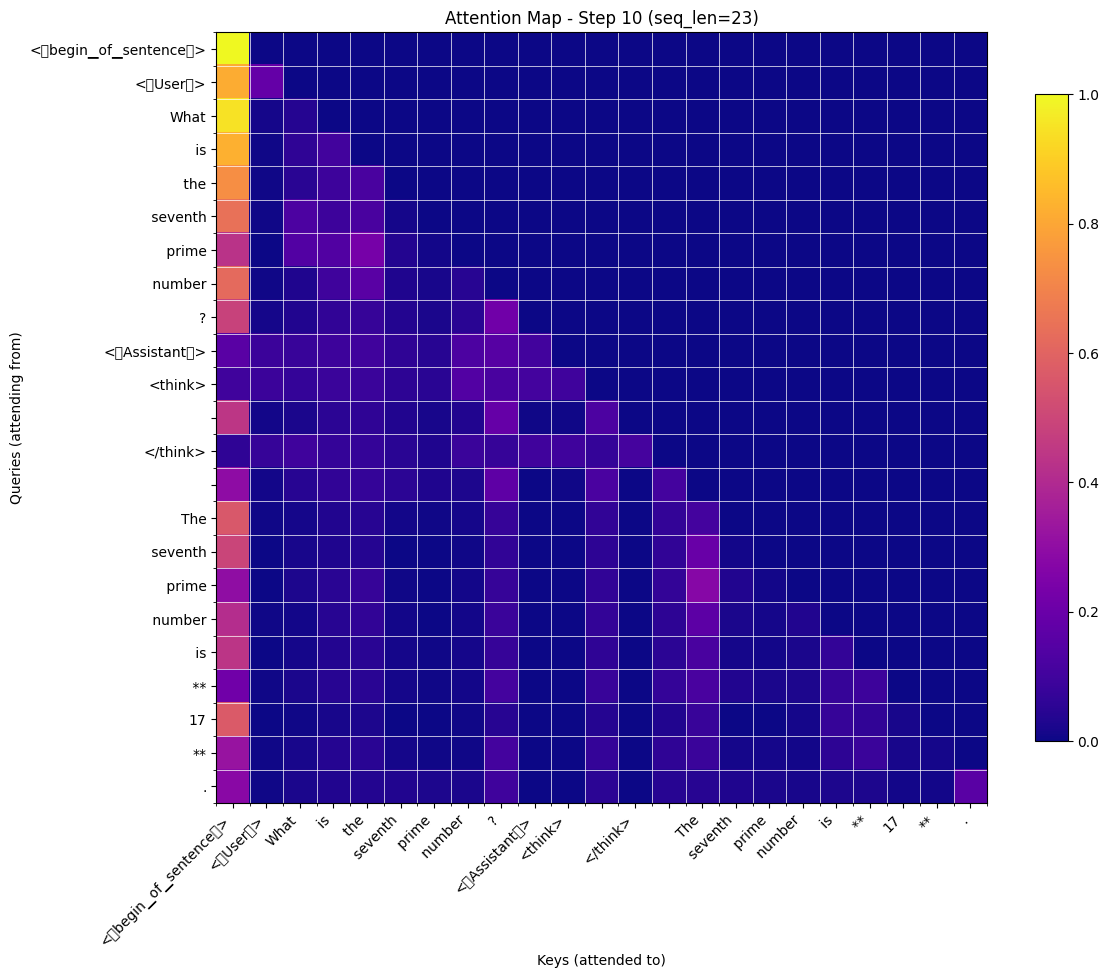

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


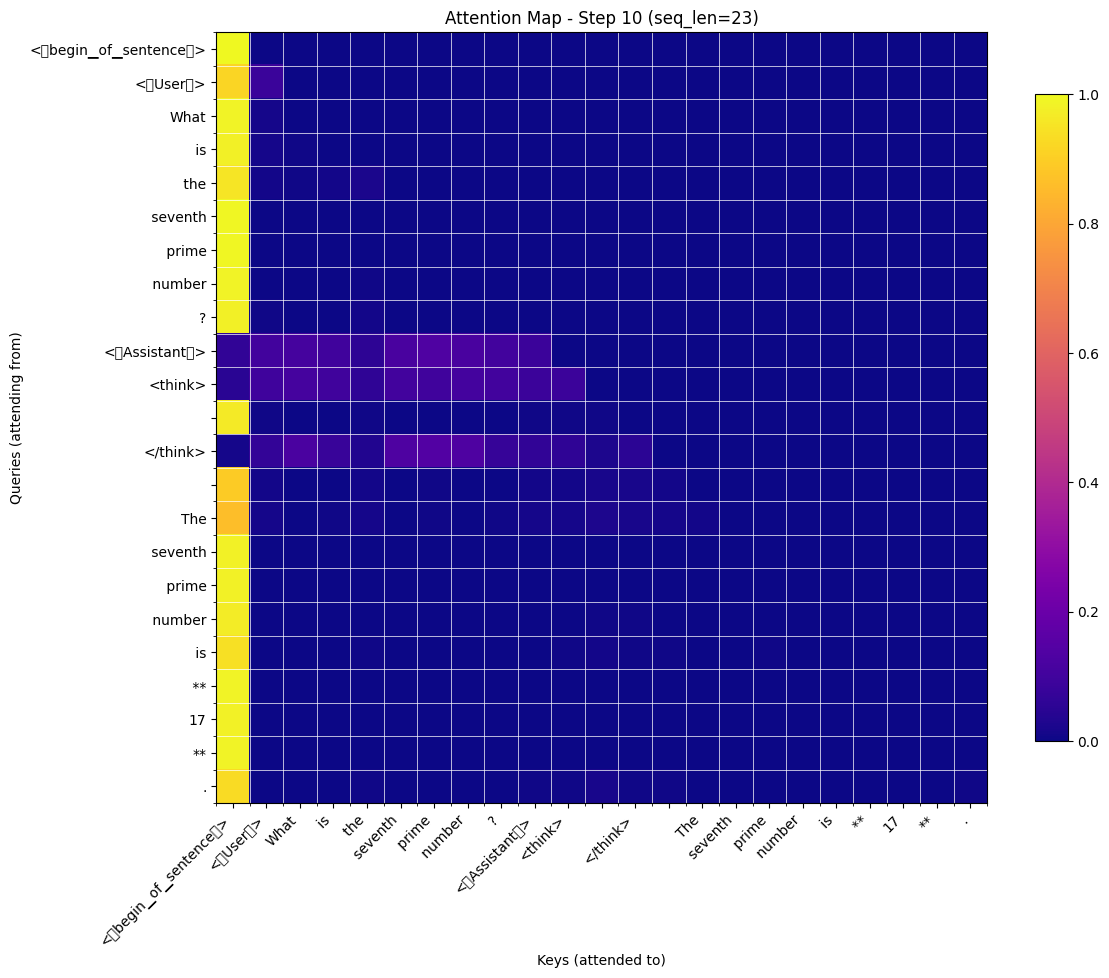

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


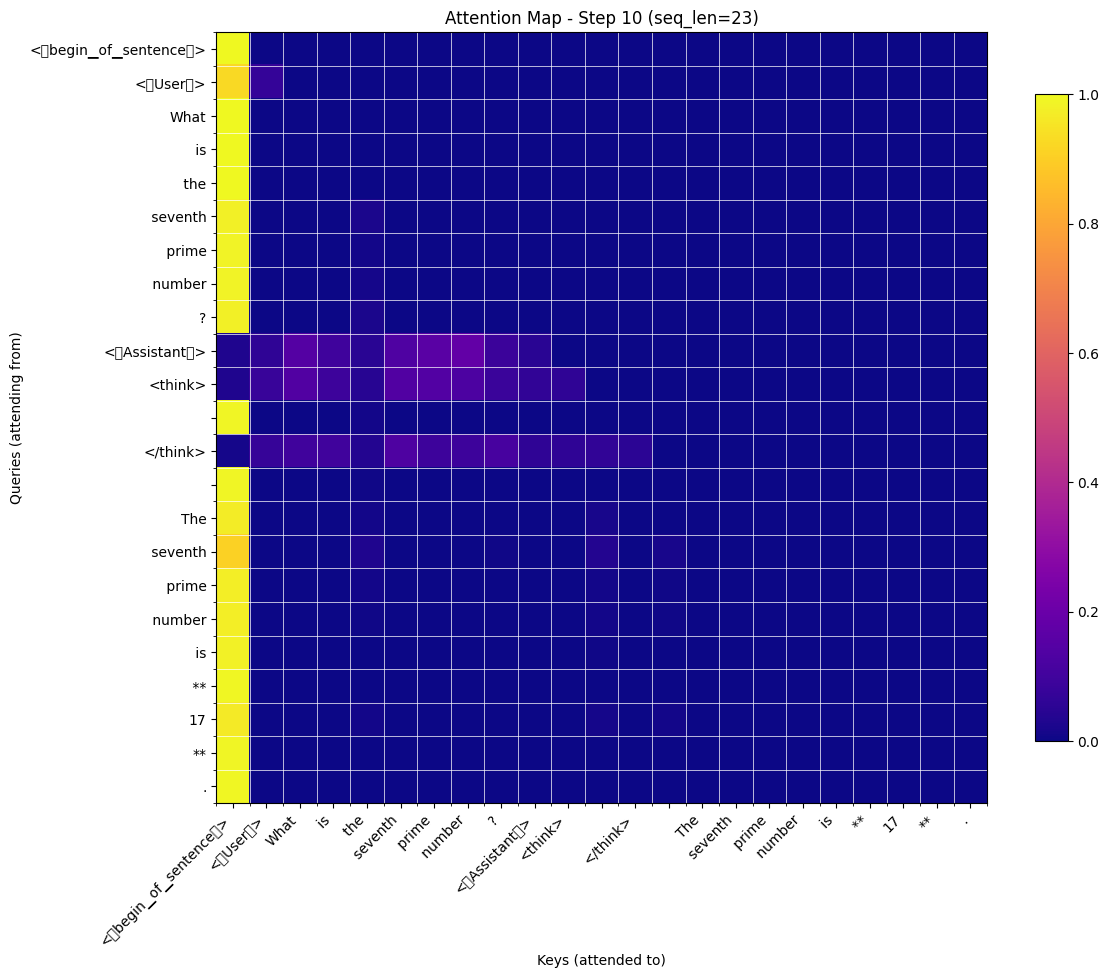

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


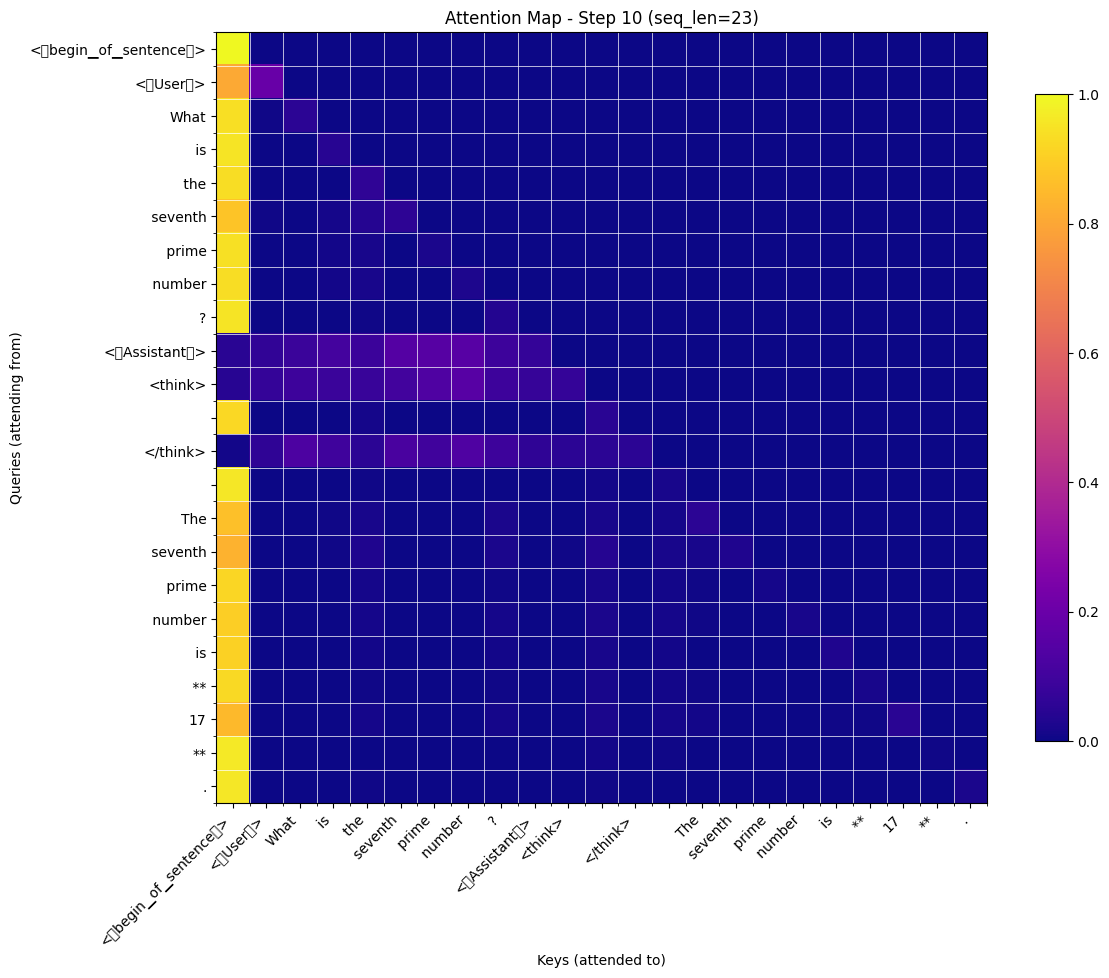

Plotting attention matrix shape: (23, 23)
Sequence length: 23
Tokens: ['<｜begin▁of▁sentence｜>', '<｜User｜>', 'What', ' is', ' the', ' seventh', ' prime', ' number', '?', '<｜Assistant｜>', '<think>', '\n', '</think>', '\n\n', 'The', ' seventh', ' prime', ' number', ' is', ' **', '17', '**', '.']


/tmp/ipykernel_31949/2250864172.py:156: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


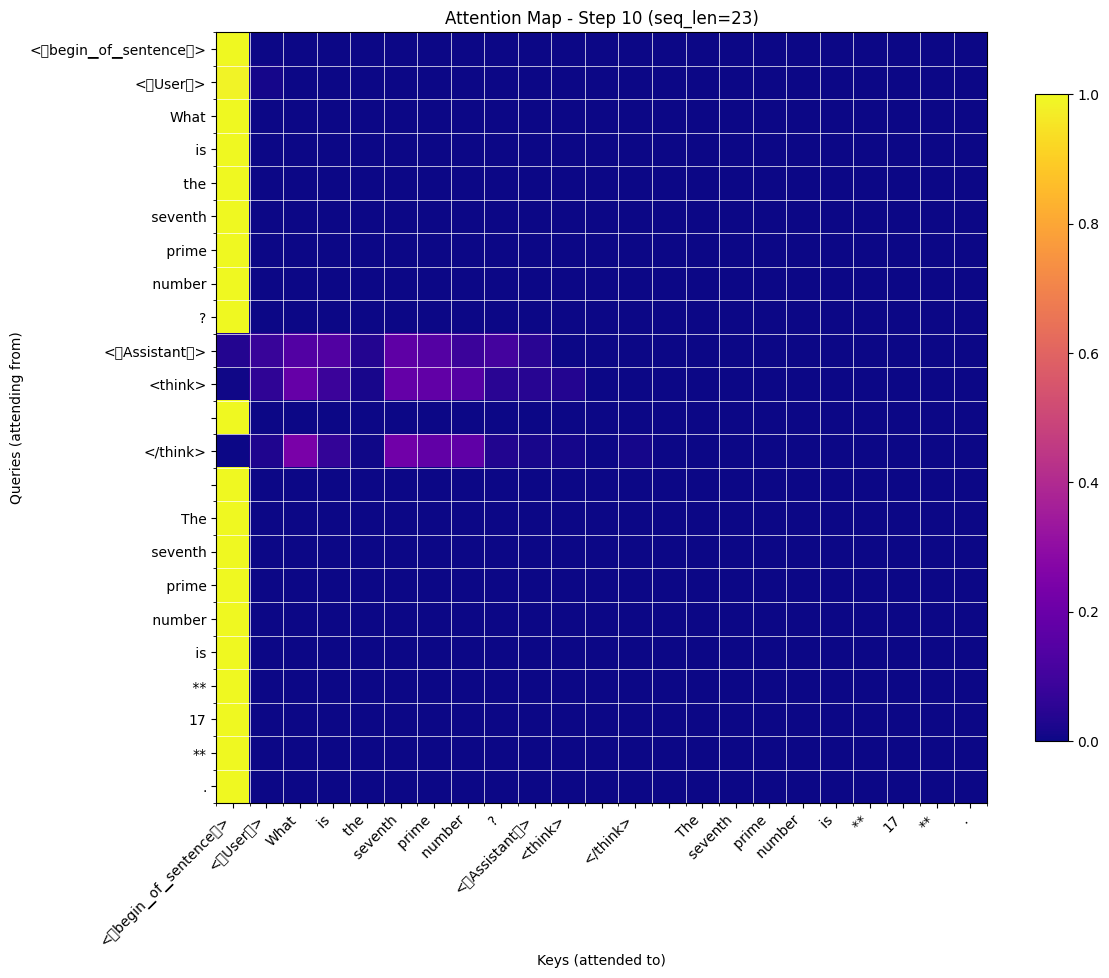

In [17]:
for i in range(32):
    attention_maps = generate_and_return_attention(
        model=model,  # Your model
        prompt=answer_prompt,
        target_head=(0, i),
        max_new_tokens=10,
        do_sample=False
    )
        
    plot_attention_maps(attention_maps)

In [164]:
model.to_tokens(reasoning_prompt)

tensor([[128000, 128011,   3923,    374,    279,  31487,  10461,   1396,     30,
         128012, 128013,    198]], device='cuda:0')

/tmp/ipykernel_26720/2523515856.py:23: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/workspace/reasoning_vector_research/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


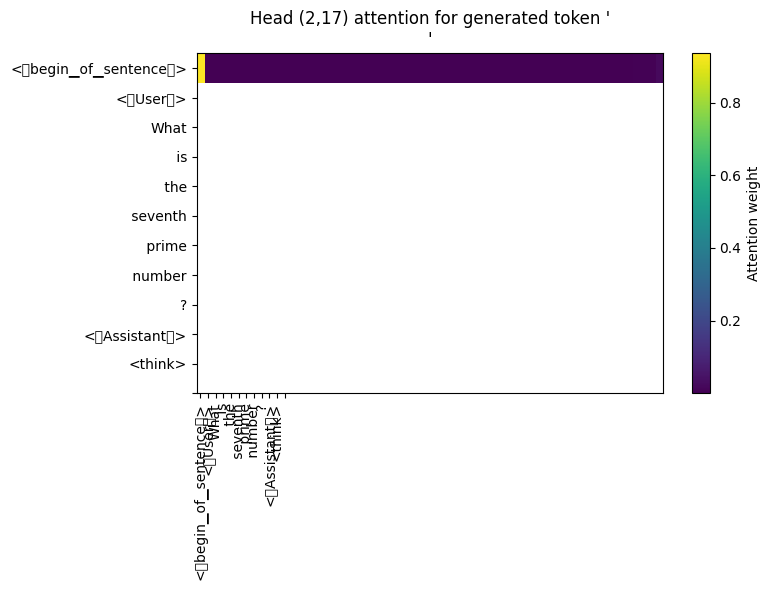

In [166]:
# --- 2. Tokenize and decode each token in full_text ---
token_ids = model.to_tokens(reasoning_prompt)[0].tolist()  # list of token IDs
token_strs = [model.to_string(torch.tensor([tid])) for tid in token_ids]

# --- 3. Pick which step’s attention to plot ---
#   attention_weights[0] is the prompt-encoding head-attn matrix,
#   attention_weights[1] is the first generated token’s head-attn matrix, etc.
step_to_plot = len(attention_pattern_reasoning["attention_weights"]) - 1  # last generated token
attn_matrix = attention_pattern_reasoning["attention_weights"][step_to_plot].numpy()  # shape (seq_len, seq_len)

# --- 4. Plot the attention matrix as a heatmap ---
plt.figure(figsize=(8, 6))
plt.imshow(attn_matrix, aspect='auto')
plt.colorbar(label="Attention weight")

# Label axes with token strings; rotate x-axis labels for readability
plt.xticks(ticks=np.arange(len(token_strs)), labels=token_strs, rotation=90)
plt.yticks(ticks=np.arange(len(token_strs)), labels=token_strs)

# Title to indicate which generated token this corresponds to
gen_idx = token_ids.index(token_ids[-1])  # index of last token
plt.title(f"Head (2,17) attention for generated token '{token_strs[gen_idx]}'")
plt.tight_layout()
plt.show()

In [64]:
generate_with_patching(
    prompt_base=answer_prompt,
    prompt_patch=reasoning_prompt,
    target_head=(2, 17),
    max_new_tokens=500,
    base_mode="answering",
    do_sample=False,
)

 42%|████▏     | 210/500 [00:15<00:21, 13.62it/s]


<｜User｜>What is the seventh prime number?<｜Assistant｜><think>
To determine the seventh prime number, I'll start by listing the prime numbers in order.

First, I know that 2 is the smallest and only even prime number.

Next, 3 is the second prime number.

Then, 5 comes after 3 as the third prime.

Following that, 7 is the fourth prime number.

The fifth prime number is 11.

After that, 13 is the sixth prime number.

Finally, 17 is the seventh prime number.
</think>

To find the **seventh prime number**, let's list the prime numbers in order until we reach the seventh one.

1. **2** - The first prime number.
2. **3** - The second prime number.
3. **5** - The third prime number.
4. **7** - The fourth prime number.
5. **11** - The fifth prime number.
6. **13** - The sixth prime number.
7. **17** - The seventh prime number.

**Answer:** \(\boxed{17}\)
decoded_acts: [tensor([ 1.4451e-02,  3.4259e-03,  3.9232e-03,  3.5688e-03, -6.7116e-03,
         4.1471e-03,  1.1510e-02,  4.3943e-03, -9.639

100%|██████████| 210/210 [00:15<00:00, 13.68it/s]


"<｜User｜>What is the seventh prime number?<｜Assistant｜><think>\nTo determine the seventh prime number, I'll start by listing the prime numbers in order.\n\nFirst, I know that 2 is the smallest and only even prime number.\n\nNext, 3 is the second prime number.\n\nThen, 5 comes after 3 as the third prime.\n\nFollowing that, 7 is the fourth prime number.\n\nThe fifth prime number is 11.\n\nAfter that, 13 is the sixth prime number.\n\nFinally, 17 is the seventh prime number.\n</think>\n\nTo find the **seventh prime number**, let's list the prime numbers in order until we reach the seventh one.\n\n1. **2** - The first prime number.\n2. **3** - The second prime number.\n3. **5** - The third prime number.\n4. **7** - The fourth prime number.\n5. **11** - The fifth prime number.\n6. **13** - The sixth prime number.\n7. **17** - The seventh prime number.\n\n**Answer:** \\(\\boxed{17}\\)"

In [21]:
model.to_string([1,2,3])

'"#$'